# Início/Isotropia all molecules

In [1]:
import numpy as np
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.base import clone
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import StackingRegressor, VotingRegressor
import seaborn as sns
import pickle
from allfunc1 import *
from IPython.display import clear_output

IndentationError: unexpected indent (allfunc1.py, line 292)

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
df_pol = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/DataBase/expd_apolar_molecules.CSV")
#df_pol = df_pol.drop(df_pol.loc[np.isnan(df_pol['axx'])].index)
df_pol.reset_index(drop=True, inplace = True)
df_pol['AlphaB'].fillna(df_pol.iloc[24:32,3], inplace=True)


In [4]:
df_pol[['Molecule','Formula','Ei','Alpha','pi_bond','Expt']]

Molecule  Formula    Ei  Alpha  pi_bond  Expt
0                       Butane    C4H10  10.6   8.10        0    35
1                      Pentane    C5H12  10.4  10.00        0    60
2                       Hexane    C6H14  10.2  11.80        0    80
3                      Heptane    C7H16   9.9  13.70        0   105
4                       Octane    C8H18  10.0  15.50        0   115
5                       Nonane    C9H20  10.0  17.40        0   145
6                     Dodecane   C12H26   9.9  22.90        0   220
7                   Hexadecane   C16H34   9.9  30.30        0   310
8                     Ethylene     C2H4  10.5   4.20        1    20
9                 Cyclopropane     C3H6   9.9   5.70        0    10
10                 Cyclohexane    C6H12   9.9  11.80        0    80
11                     Benzene     C6H6   9.3  10.40        3   150
12                 Naphthalene    C10H8   8.2  16.60        5   300
13             2-3-butanedione   C4H6O2   9.3   8.20        2    77
14                  IsoPentane    C5H12  10.3  10.00        0    60
15                 TetraDecane   C14H30   9.9  26.60        0   260
16                     Propane     C3H8  11.1   6.30        0    10
17         Tetrachloroethylene    C2Cl4   9.3  12.30        1    57
18  1-2-trans-Dichloroethylene  C2H2Cl2   9.6   8.15        1    15
19             Carbondisulfide      CS2  10.1   8.70        2    75

In [5]:
df_pol[['Molecule','Formula','Ei','Alpha','pi_bond','Expt']].corr()

Ei     Alpha   pi_bond      Expt
Ei       1.000000 -0.248777 -0.761480 -0.510426
Alpha   -0.248777  1.000000 -0.121485  0.892635
pi_bond -0.761480 -0.121485  1.000000  0.297124
Expt    -0.510426  0.892635  0.297124  1.000000

In [6]:
df_pol.loc[df_pol['pi_bond']==0][['Molecule','Formula','Molecule Type', 'Alpha','Expt','pi_bond']].reset_index(drop=True)

Molecule Formula       Molecule Type  Alpha  Expt  pi_bond
0         Butane   C4H10  Alkane and related    8.1    35        0
1        Pentane   C5H12  Alkane and related   10.0    60        0
2         Hexane   C6H14  Alkane and related   11.8    80        0
3        Heptane   C7H16  Alkane and related   13.7   105        0
4         Octane   C8H18  Alkane and related   15.5   115        0
5         Nonane   C9H20  Alkane and related   17.4   145        0
6       Dodecane  C12H26  Alkane and related   22.9   220        0
7     Hexadecane  C16H34  Alkane and related   30.3   310        0
8   Cyclopropane    C3H6                Ring    5.7    10        0
9    Cyclohexane   C6H12                Ring   11.8    80        0
10    IsoPentane   C5H12  Alkane and related   10.0    60        0
11   TetraDecane  C14H30  Alkane and related   26.6   260        0
12       Propane    C3H8  Alkane and related    6.3    10        0

In [7]:
px.scatter_matrix(df_pol, dimensions=['Ei','AlphaB','Expt','pi_bond'], hover_name='Molecule')

In [8]:
px.scatter(df_pol, x='Alpha', y='Expt', title="Expt vs Alpha")

In [9]:
px.scatter(df_pol.loc[df_pol['pi_bond']==0], x='Alpha', y='Expt', title="Expt vs Alpha")

In [10]:
highlighting_dots(df_pol.loc[df_pol['pi_bond']==0],'Alpha','Expt',[8,9,10])

In [11]:
alkane_molecules = df_pol.loc[[i for i in range(len(df_pol)) if 'Alkane' in df_pol['Molecule Type'][i]]]
df_pol.drop([i for i in range(len(df_pol)) if 'Alkane' in df_pol['Molecule Type'][i]])

Molecule  Formula Molecule Type  N of Carbon    Ei  \
9                 Cyclopropane     C3H6          Ring          NaN   9.9   
10                 Cyclohexane    C6H12          Ring          NaN   9.9   
11                     Benzene     C6H6          Ring          NaN   9.3   
12                 Naphthalene    C10H8          Ring          NaN   8.2   
13             2-3-butanedione   C4H6O2         Other          NaN   9.3   
17         Tetrachloroethylene    C2Cl4         Other          NaN   9.3   
18  1-2-trans-Dichloroethylene  C2H2Cl2     Chlorated          NaN   9.6   
19             Carbondisulfide      CS2         Other          NaN  10.1   

    Alpha  Expt    DYS  SG  PauloPred     axx     ayy    azz     AlphaB  \
9    5.70    10    1.0 NaN       10.0   5.750   5.750  5.035   5.511667   
10  11.80    80   68.0 NaN       83.0  11.290  11.290  9.778  10.786000   
11  10.40   150  149.0 NaN      148.0  12.271  12.271  6.671  10.404333   
12  16.60   300  296.0 NaN      301.0  25.712  18.700  9.826  18.079333   
13   8.20    77   92.0 NaN       79.0   9.758   9.073  6.117   8.316000   
17  12.30    57    NaN NaN        NaN  15.103  13.932  7.814  12.283000   
18   8.15    15    NaN NaN        NaN  12.534   6.722  5.563   8.273000   
19   8.70    75    NaN NaN        NaN  13.902   5.234  5.234   8.123333   

    pi_bond  
9         0  
10        0  
11        3  
12        5  
13        2  
17        1  
18        1  
19        2

In [12]:
corr = df_pol[['Ei','Alpha','Expt']].corr()
corr

Ei     Alpha      Expt
Ei     1.000000 -0.248777 -0.510426
Alpha -0.248777  1.000000  0.892635
Expt  -0.510426  0.892635  1.000000

In [13]:
df_pol.describe()

N of Carbon         Ei      Alpha        Expt         DYS          SG  \
count    12.000000  20.000000  20.000000   20.000000   17.000000    8.000000   
mean      7.583333   9.915000  12.932500  109.200000  115.764706  135.500000   
std       4.420167   0.602866   6.935953   94.098269  100.785372   81.177055   
min       2.000000   8.200000   4.200000   10.000000  -17.000000   26.000000   
25%       4.750000   9.825000   8.187500   51.500000   54.000000   79.250000   
50%       6.500000   9.900000  11.100000   78.500000   92.000000  130.500000   
75%       9.750000  10.225000  15.775000  146.250000  149.000000  181.500000   
max      16.000000  11.100000  30.300000  310.000000  306.000000  264.000000   

        PauloPred        axx        ayy        azz     AlphaB    pi_bond  
count   14.000000  17.000000  17.000000  17.000000  17.000000  20.000000  
mean   122.000000  13.096941  10.150647   8.183176  10.476922   0.750000  
std     95.408434   5.465676   4.035507   3.002566   3.907074   1.332785  
min     10.000000   5.429000   3.766000   3.346000   4.180333   0.000000  
25%     59.250000   9.758000   6.722000   5.726000   8.123333   0.000000  
50%     94.000000  12.271000   9.851000   7.814000   9.953667   0.000000  
75%    147.000000  15.103000  12.658000   9.826000  12.283000   1.000000  
max    308.000000  25.712000  18.700000  14.012000  18.079333   5.000000

In [14]:
x = df_pol[['Ei','Alpha']].values
y = df_pol[['Expt']].values
x_alpha = df_pol[['Ei','axx','ayy','azz']].values

x_pi = df_pol[['Ei','Alpha','pi_bond']].values
x_alpha_pi = df_pol[['Ei','axx','ayy','azz', 'pi_bond']].values

x.shape, y.shape, x_alpha.shape, x_pi.shape, x_alpha_pi.shape

((20, 2), (20, 1), (20, 4), (20, 3), (20, 5))

## Otimizando Isotropia

In [16]:
#O stacking tem que ser definido e executado primeiro, pois se não alterarei os estimadores básicos como SVR e etc.

ridge = Pipeline([('poli', PolynomialFeatures()), ('reg', linear_model.Ridge())])

svr = SVR(max_iter=5000)

xgb = XGBRegressor(random_state=0)

nn = MLPRegressor(max_iter = 2000, random_state = 0)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

reg1 = StackingRegressor([('poli', ridge), ('svr', svr), ('xgb',xgb), ('nn', nn)], final_estimator= LinearRegression(), cv = kf, n_jobs=-1)
pipe1 = Pipeline([('scaler', RobustScaler()), ('reg', reg1)])
stk_lin = TransformedTargetRegressor(transformer=StandardScaler(), regressor=pipe1)

space_stk_lin = [
    #Polinomial
    Real(1e-5,100, 'log-uniform', name='regressor__reg__poli__reg__alpha'),
    Integer(1,10,name='regressor__reg__poli__poli__degree'),
    #SVR
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__svr__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__svr__gamma'),
    Real(0.1, 1,prior='log-uniform', name = 'regressor__reg__svr__C'),
    #XGBoost
    Real(10e-5,0.2,  "log-uniform", name='regressor__reg__xgb__learning_rate'),
    Integer(100,2000,name = 'regressor__reg__xgb__n_estimators'),
    Integer(1,15,name='regressor__reg__xgb__max_depth'),
    Real(0.1, 1, name='regressor__reg__xgb__subsample'),
    #MLP
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__nn__activation'),
    Real(0,1e-3, name='regressor__reg__nn__alpha'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer')
]

#params_stk = ['tanh', 0.00029156446664498157, 12, 20, 0.5596277554095808, 0.5499611271712672, 1e-07, RobustScaler(), StandardScaler()]
#att_model(stk_lin, space_stk_lin, params_stk, neural=True, stacked=True)

In [29]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scaling', MinMaxScaler()),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scaling"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]
params_poli = [0.1847625735942012, False, False, 1, True, False, MinMaxScaler(), MinMaxScaler()]
att_model(ridge, space_poli, params_poli)

In [30]:
pipe = Pipeline([('scale',StandardScaler()),('reg',SVR(max_iter=10000))])
svr = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]

params_svr = ['poly', 'auto', 2, 6.831777820514685, 3.490324997821676, 0.01, MinMaxScaler(), RobustScaler()]
att_model(svr, space_svr, params_svr)

In [31]:
xgb = XGBRegressor(random_state=0)

space_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]
params_xgb = [0.16275933495310135, 2000, 15, 4, 5.527844082402412, 0.5707851946807937, 1.0, 1.0, 0.9932722794572536]
att_model(xgb,space_xgb,params_xgb)

In [32]:
pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    #Real(0,1e-3, name='regressor__reg__alpha'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]
params_nn = ['tanh', 0.00029156446664498157, 12, 20, 0.5596277554095808, 0.5499611271712672, 1e-07, RobustScaler(), StandardScaler()]
att_model(nn, space_nn, params_nn, neural=True)

In [33]:
#Antes de otimizar todo mundo preciso criar lista com estimadores, seus nomes 
#e seus espaços:
estim=[svr, xgb, nn, ridge]
estim_names = ['svr','xgb','nn','poli']
spaces = [space_svr, space_xgb,space_nn, space_poli]


In [22]:
#Otimizando com cv = 5 e shuffle: 0.51,0.42, 0.40,0.36
estim_list = opt_all(estim,estim_names,x,y,5,spaces, shuffle=True, random_state=0)

Estamos em stacked
Iteration No: 1 started. Evaluating function at random point.


ValueError: Invalid parameter 'n_hidden_layer' for estimator TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler', RobustScaler()),
                                                     ('reg',
                                                      StackingRegressor(cv=KFold(n_splits=10, random_state=0, shuffle=True),
                                                                        estimators=[('poli',
                                                                                     Pipeline(steps=[('poli',
                                                                                                      PolynomialFeatures()),
                                                                                                     ('reg',
                                                                                                      Ridge())])),
                                                                                    ('svr',
                                                                                     SVR(max_iter=5000)),
                                                                                    ('xgb',
                                                                                     XGBRegressor(base_score=None,
                                                                                                  booster=None,
                                                                                                  callbacks=None,
                                                                                                  colsample_bylevel=No...
                                                                                                  max_cat_to_onehot=None,
                                                                                                  max_delta_step=None,
                                                                                                  max_depth=None,
                                                                                                  max_leaves=None,
                                                                                                  min_child_weight=None,
                                                                                                  missing=nan,
                                                                                                  monotone_constraints=None,
                                                                                                  n_estimators=100,
                                                                                                  n_jobs=None,
                                                                                                  num_parallel_tree=None,
                                                                                                  predictor=None,
                                                                                                  random_state=0, ...)),
                                                                                    ('nn',
                                                                                     MLPRegressor(max_iter=2000,
                                                                                                  random_state=0))],
                                                                        final_estimator=LinearRegression(),
                                                                        n_jobs=-1))]),
                           transformer=StandardScaler()). Valid parameters are: ['check_inverse', 'func', 'inverse_func', 'regressor', 'transformer'].

In [26]:
stk_opt = gp_optimize(stk_lin, x, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.1531
Function value obtained: 1.2458
Current minimum: 1.2458
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.9633
Function value obtained: 1.2109
Current minimum: 1.2109
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7431
Function value obtained: 1.1675
Current minimum: 1.1675
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.2414
Function value obtained: 0.9837
Current minimum: 0.9837
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.3633
Function value obtained: 0.9971
Current minimum: 0.9837
Iteration No: 6 started. Evaluating

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.06442e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.3701e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.338e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_rid

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.7676
Function value obtained: 0.9744
Current minimum: 0.6050
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.0342
Function value obtained: 1.4310
Current minimum: 0.6050
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 6.5426
Function value obtained: 1.1132
Current minimum: 0.6050
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.8741
Function value obtained: 1.0869
Current minimum: 0.6050
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 13.8466
Function value obtained: 0.8719
Current minimum: 0.6050
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.35376e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.81883e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.43169e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.16508e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.8826
Function value obtained: 0.6913
Current minimum: 0.6050
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 2.4975
Function value obtained: 1.1563
Current minimum: 0.6050
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.38097e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.61476e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.21988e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.2901e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 2.5116
Function value obtained: 0.7560
Current minimum: 0.6050
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.2213
Function value obtained: 0.6539
Current minimum: 0.6050
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 4.0688
Function value obtained: 1.3102
Current minimum: 0.6050
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 4.0925
Function value obtained: 0.6302
Current minimum: 0.6050
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 3.5095
Function value obtained: 1.1803
Current minimum: 0.6050
Iteration No: 34 started. Evaluating function at random point.
Iteration No: 34 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.666e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.13793e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.82399e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ri

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 14.2337
Function value obtained: 0.9130
Current minimum: 0.6050
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 5.0202
Function value obtained: 1.1495
Current minimum: 0.6050
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 5.3431
Function value obtained: 1.3057
Current minimum: 0.6050
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 3.5486
Function value obtained: 1.0147
Current minimum: 0.6050
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 3.2723
Function value obtained: 1.2772
Current minimum: 0.6050
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.71519e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assu

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 1.4681
Function value obtained: 0.8558
Current minimum: 0.6050
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 13.4742
Function value obtained: 1.2206
Current minimum: 0.6050
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10458e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.08982e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.9390
Function value obtained: 1.4362
Current minimum: 0.6050
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 6.2172
Function value obtained: 1.2447
Current minimum: 0.6050
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 2.9633
Function value obtained: 0.8253
Current minimum: 0.6050
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 6.1825
Function value obtained: 0.9455
Current minimum: 0.6050
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 5.5238
Function value obtained: 0.6709
Current minimum: 0.6050
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.01387e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.41837e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.16759e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.42661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 4.6310
Function value obtained: 0.8126
Current minimum: 0.5533
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 5.8302
Function value obtained: 1.1149
Current minimum: 0.5533
Iteration No: 104 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.00357e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.29179e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.98474e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.81228e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 5.1957
Function value obtained: 1.7750
Current minimum: 0.5533
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 4.5851
Function value obtained: 1.4028
Current minimum: 0.5533
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 6.8954
Function value obtained: 0.7046
Current minimum: 0.5533
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 6.8149
Function value obtained: 1.1297
Current minimum: 0.5533
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 7.3176
Function value obtained: 0.6136
Current minimum: 0.5533
Iteration No: 109 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.01387e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.41837e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.16759e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.42661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 8.8868
Function value obtained: 1.3163
Current minimum: 0.5533
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 6.1714
Function value obtained: 0.7366
Current minimum: 0.5533
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 7.7199
Function value obtained: 1.3069
Current minimum: 0.5533
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 9.4330
Function value obtained: 0.7561
Current minimum: 0.5533
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 6.3485
Function value obtained: 0.5351
Current minimum: 0.5351
Iteration No: 119 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.37541e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.44877e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 8.4034
Function value obtained: 0.9101
Current minimum: 0.4483
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 5.1098
Function value obtained: 0.7039
Current minimum: 0.4483
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 9.2393
Function value obtained: 0.5926
Current minimum: 0.4483
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 5.3405
Function value obtained: 0.4727
Current minimum: 0.4483
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 6.9541
Function value obtained: 1.3013
Current minimum: 0.4483
Iteration No: 140 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.71519e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assu

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 7.5806
Function value obtained: 1.3953
Current minimum: 0.4483
Iteration No: 144 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.82647e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.66899e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.82669e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.78002e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 7.9914
Function value obtained: 0.7691
Current minimum: 0.4483
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 7.2261
Function value obtained: 1.0348
Current minimum: 0.4483
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 9.2240
Function value obtained: 0.9451
Current minimum: 0.4483
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 7.6093
Function value obtained: 1.0971
Current minimum: 0.4483
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 8.3279
Function value obtained: 0.6941
Current minimum: 0.4483
Iteration No: 149 st

In [27]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.11393218497353985, 5, 'rbf', 'auto', 0.9344312767569978, 0.0002751825581305233, 1023, 12, 0.22124396929632306, 'tanh', 3.610129717520308e-05, 4, 10]
Valor de função:  0.4483150058882398


In [19]:
pred_df = create_pred_df(df_pol, estim_list, estim_names, x, y)
np.round(pred_df,2)

Molecule  Formula  Ei (meV)  Alpha (AA³)  Expt (meV)  \
0                       Butane    C4H10      10.6         8.10          35   
1                      Pentane    C5H12      10.4        10.00          60   
2                       Hexane    C6H14      10.2        11.80          80   
3                      Heptane    C7H16       9.9        13.70         105   
4                       Octane    C8H18      10.0        15.50         115   
5                       Nonane    C9H20      10.0        17.40         145   
6                     Ethylene     C2H4      10.5         4.20          20   
7                 Cyclopropane     C3H6       9.9         5.70          10   
8                  Cyclohexane    C6H12       9.9        11.80          80   
9                      Benzene     C6H6       9.3        10.40         150   
10                 Naphthalene    C10H8       8.2        16.60         300   
11             2-3-butanedione   C4H6O2       9.3         8.20          77   
12                  IsoPentane    C5H12      10.3        10.00          60   
13                     Propane     C3H8      11.1         6.30          10   
14         Tetrachloroethylene    C2Cl4       9.3        12.30          57   
15  1-2-trans-Dichloroethylene  C2H2Cl2       9.6         8.15          15   
16             Carbondisulfide      CS2      10.1         8.70          75   

      DYS     SG  PauloPred  axx (AA³)  ayy (AA³)  azz (AA³)  AlphaB (AA³)  \
0    31.0   26.0       39.0       9.31       7.68       7.24          8.08   
1    54.0   56.0       54.0      11.72       9.39       8.74          9.95   
2    77.0   87.0       75.0      14.32      10.99      10.23         11.85   
3   100.0  117.0      105.0      16.91      12.66      11.72         13.76   
4   123.0  144.0      119.0      19.60      14.26      13.19         15.68   
5   146.0  168.0      144.0      21.31      14.93      14.01         16.75   
6   -17.0    NaN       20.0       5.43       3.77       3.35          4.18   
7     1.0    NaN       10.0       5.75       5.75       5.04          5.51   
8    68.0    NaN       83.0      11.29      11.29       9.78         10.79   
9   149.0    NaN      148.0      12.27      12.27       6.67         10.40   
10  296.0    NaN      301.0      25.71      18.70       9.83         18.08   
11   92.0    NaN       79.0       9.76       9.07       6.12          8.32   
12   57.0    NaN        NaN      10.88       9.85       8.86          9.87   
13   10.0    NaN        NaN       6.84       6.06       5.73          6.21   
14    NaN    NaN        NaN      15.10      13.93       7.81         12.28   
15    NaN    NaN        NaN      12.53       6.72       5.56          8.27   
16    NaN    NaN        NaN      13.90       5.23       5.23          8.12   

    pi_bond     svr         xgb      nn    poli  
0         0   38.41   35.169998   23.90   28.40  
1         0   59.30   59.950001   54.42   46.86  
2         0   80.36   74.730003   85.19   69.86  
3         0  104.29  103.690002  119.68  102.79  
4         0  117.25  103.750000  140.10  116.62  
5         0  126.00  169.669998  153.45  127.31  
6         1    9.27   17.820000   14.73    2.87  
7         0   36.75   12.980000   16.71   15.55  
8         0   79.93   78.400002   82.55   71.33  
9         3   93.39  153.119995   99.06   87.67  
10        5  186.62  273.910004  233.87  282.28  
11        2   76.29   81.250000   72.99   58.28  
12        0   61.35   59.980000   56.88   49.27  
13        0    9.32   10.110000   14.73   11.53  
14        1  108.77   71.190002  122.51  114.11  
15        1   67.65   14.920000   61.82   51.22  
16        2   52.61   74.970001   42.22   39.04

## Otimizando com Pi Bond e Isotropia

In [25]:
# Com o acréscimo de Pi Bond, terei que mudar o scaling e consequentemente os espaços
# de otimização.

In [15]:
# Pra coordenadas em X.
scaler = ColumnTransformer([('scale', 
                              RobustScaler(),
                             [0,1]
                            )], remainder='passthrough')

In [38]:
#O stacking tem que ser definido e executado primeiro, pois se não alterarei os estimadores básicos como SVR e etc.

ridge = Pipeline([('poli', PolynomialFeatures()), ('reg', linear_model.Ridge())])

svr = SVR(max_iter=5000)

xgb = XGBRegressor(random_state=0)

nn = MLPRegressor(max_iter = 2000, random_state = 0)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

reg1 = StackingRegressor([('poli', ridge), ('svr', svr), ('xgb',xgb), ('nn', nn)], final_estimator= LinearRegression(), cv = kf, n_jobs=-1)
pipe1 = Pipeline([('scaler', scaler), ('reg', reg1)])
stk_lin_pi = TransformedTargetRegressor(transformer=StandardScaler(), regressor=pipe1)

space_stk_lin = [
    #Polinomial
    Real(1e-5,100, 'log-uniform', name='regressor__reg__poli__reg__alpha'),
    Integer(1,10,name='regressor__reg__poli__poli__degree'),
    #SVR
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__svr__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__svr__gamma'),
    Real(0.1, 1,prior='log-uniform', name = 'regressor__reg__svr__C'),
    #XGBoost
    Real(10e-5,0.2,  "log-uniform", name='regressor__reg__xgb__learning_rate'),
    Integer(100,2000,name = 'regressor__reg__xgb__n_estimators'),
    Integer(1,15,name='regressor__reg__xgb__max_depth'),
    Real(0.1, 1, name='regressor__reg__xgb__subsample'),
    #MLP
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__nn__activation'),
    Real(0,1e-3, name='regressor__reg__nn__alpha'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer')
]

params_stk = [0.00018635207895368688, 2, 'poly', 'auto', 0.5125078685552176, 0.03472035335524569, 791, 3, 0.6802609059351543, 'relu', 0.0009322492029932768, 16, 20]
att_model(stk_lin_pi, space_stk_lin, params_stk, neural=True, stacked=True)

In [16]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge_pi = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_pi_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]
poli_params = [0.0010229038937673283, False, False, 2, False, False, MinMaxScaler(), RobustScaler()]
att_model(ridge_pi, space_pi_poli, poli_params)

In [22]:
pipe = Pipeline([('scale',scaler),('reg',SVR(max_iter=10000))])
svr_pi = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_pi_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]
svr_params_pi = ['rbf', 'auto', 10, 3.0251458495873367, 4.998645856983394, 0.01, MinMaxScaler(), RobustScaler()]
att_model(svr_pi, space_pi_svr, svr_params_pi)

In [18]:
xgb_pi = XGBRegressor(random_state=0)

space_pi_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

xgb_params_pi = [0.0880371281688603, 1998, 1, 2, 0.0, 0.25053190374738665, 0.1, 0.19161212081152593, 0.28234931604964586]
att_model(xgb_pi, space_pi_xgb, xgb_params_pi)

In [19]:
pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn_pi = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_pi_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    #Real(0,1e-3, name='regressor__reg__alpha'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]
nn_params = ['relu', 0.000982677191257576, 17, 14, 0.591803189583539, 0.46103581456245735, 2.853478437728824e-06, 
             MinMaxScaler(), RobustScaler()]
att_model(nn_pi, space_pi_nn, nn_params, neural=True)

In [23]:
#Antes de otimizar todo mundo preciso criar lista com estimadores, seus nomes 
#e seus espaços:
estim_pi=[svr_pi,xgb_pi,nn_pi, ridge_pi]
estim_pi_names = ['svr_pi','xgb_pi','nn_pi','poli_pi']
spaces_pi = [space_pi_svr, space_pi_xgb,space_pi_nn, space_pi_poli]


In [ ]:
#Primeira rodada pra moléculas polares
estim_list = opt_all(estim,estim_names,x_pi,y,5,spaces, shuffle=True, random_state=0)

---------Polarizabilidade Isotrópica---------


Para o estimador svr_pi, os parâmetros são: ['rbf', 'auto', 10, 3.0251458495873367, 4.998645856983394, 0.01, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.33913917097452284

Para o estimador xgb_pi, os parâmetros são: [0.0880371281688603, 1998, 1, 2, 0.0, 0.25053190374738665, 0.1, 0.19161212081152593, 0.28234931604964586]
Cujo score de teste é: 0.39912246564550746

Para o estimador nn_pi, os parâmetros são: ['relu', 0.000982677191257576, 17, 14, 0.591803189583539, 0.46103581456245735, 2.853478437728824e-06, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.2231886394930625

Para o estimador poli_pi, os parâmetros são: [0.0010229038937673283, False, False, 2, False, False, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.183483753799217



In [48]:
stk_opt_pi = gp_optimize(stk_lin_pi, x_pi, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.9560
Function value obtained: 0.9374
Current minimum: 0.9374
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.4854
Function value obtained: 0.8803
Current minimum: 0.8803
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8725
Function value obtained: 1.0177
Current minimum: 0.8803
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.7435
Function value obtained: 0.8733
Current minimum: 0.8733
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.7032
Function value obtained: 0.6101
Current minimum: 0.6101
Iteration No: 6 started. Evaluating

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.5693
Function value obtained: 0.7908
Current minimum: 0.5235
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.5716
Function value obtained: 1.2609
Current minimum: 0.5235
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 3.7390
Function value obtained: 1.0594
Current minimum: 0.5235
Iteration No: 10 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.82163e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.24662e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.02663e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.2882
Function value obtained: 1.8087
Current minimum: 0.5235
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.1252
Function value obtained: 0.9643
Current minimum: 0.5235
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 5.2206
Function value obtained: 0.3012
Current minimum: 0.3012
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 1.5212
Function value obtained: 0.5168
Current minimum: 0.3012
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 21.5713
Function value obtained: 0.7542
Current minimum: 0.3012
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.94857e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.26699e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.7669e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.30515e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.3093
Function value obtained: 1.2183
Current minimum: 0.3012
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.0149
Function value obtained: 0.3792
Current minimum: 0.3012
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 9.9311
Function value obtained: 0.5610
Current minimum: 0.3012
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.05135e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.98837e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.90244e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.63407e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 3.6657
Function value obtained: 1.6011
Current minimum: 0.3012
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.7765
Function value obtained: 1.3703
Current minimum: 0.3012
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.3713
Function value obtained: 0.8326
Current minimum: 0.3012
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 3.4680
Function value obtained: 0.6581
Current minimum: 0.3012
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 5.1687
Function value obtained: 1.3080
Current minimum: 0.3012
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19154e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21825e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.2670
Function value obtained: 1.2254
Current minimum: 0.3012
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 3.1358
Function value obtained: 1.4807
Current minimum: 0.3012
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.7299e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.87717e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.66539e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.07503e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.3955
Function value obtained: 1.0698
Current minimum: 0.3012
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 2.5988
Function value obtained: 0.6708
Current minimum: 0.3012
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.7999
Function value obtained: 0.5819
Current minimum: 0.3012
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.7490
Function value obtained: 0.6052
Current minimum: 0.3012
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.3409
Function value obtained: 0.6912
Current minimum: 0.3012
Iteration No: 34 started. Evaluating function at random point.
Iteration No: 34 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.4872e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.68685e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.56714e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_r

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 11.5856
Function value obtained: 1.7459
Current minimum: 0.3012
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 3.2047
Function value obtained: 0.9854
Current minimum: 0.3012
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.9205
Function value obtained: 0.6077
Current minimum: 0.3012
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 7.3747
Function value obtained: 0.8573
Current minimum: 0.3012
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.5239
Function value obtained: 0.5894
Current minimum: 0.3012
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.98695e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 3.5392
Function value obtained: 1.5341
Current minimum: 0.3012
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 3.2890
Function value obtained: 1.0674
Current minimum: 0.3012
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.11586e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.03788e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.18575e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 3.1740
Function value obtained: 1.0845
Current minimum: 0.3012
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 6.8949
Function value obtained: 0.7439
Current minimum: 0.3012
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.0617
Function value obtained: 0.9858
Current minimum: 0.3012
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 4.8454
Function value obtained: 1.2175
Current minimum: 0.3012
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 4.0240
Function value obtained: 0.8219
Current minimum: 0.3012
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.36893e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.75413e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.08479e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10176e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 7.3348
Function value obtained: 1.4659
Current minimum: 0.3012
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.4390
Function value obtained: 0.4295
Current minimum: 0.3012
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 9.4029
Function value obtained: 0.7453
Current minimum: 0.3012
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 5.4953
Function value obtained: 1.0598
Current minimum: 0.3012
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 1.0317
Function value obtained: 1.8944
Current minimum: 0.3012
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 12.9337
Function value obtained: 0.4536
Current minimum: 0.2190
Iteration No: 137 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.52422e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.23409e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 5.3821
Function value obtained: 1.2732
Current minimum: 0.2190
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 7.6970
Function value obtained: 0.6724
Current minimum: 0.2190
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 6.7685
Function value obtained: 0.8047
Current minimum: 0.2190
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 17.7819
Function value obtained: 1.2151
Current minimum: 0.2190
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 8.0023
Function value obtained: 0.6695
Current minimum: 0.2190
Iteration No: 142 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.75439e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.78414e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.0082e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_r

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 12.3934
Function value obtained: 1.0919
Current minimum: 0.2190
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 10.1799
Function value obtained: 0.5642
Current minimum: 0.2190
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 7.6079
Function value obtained: 0.4248
Current minimum: 0.2190
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 10.2140
Function value obtained: 1.1165
Current minimum: 0.2190
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 10.0223
Function value obtained: 1.0220
Current minimum: 0.2190


### Otimizando Alpha + Pi Bond

In [15]:
x_alpha_pi = df_pol[['Alpha','pi_bond']].values
x_alpha_pi

array([[ 8.1 ,  0.  ],
       [10.  ,  0.  ],
       [11.8 ,  0.  ],
       [13.7 ,  0.  ],
       [15.5 ,  0.  ],
       [17.4 ,  0.  ],
       [22.9 ,  0.  ],
       [30.3 ,  0.  ],
       [ 4.2 ,  1.  ],
       [ 5.7 ,  0.  ],
       [11.8 ,  0.  ],
       [10.4 ,  3.  ],
       [16.6 ,  5.  ],
       [ 8.2 ,  2.  ],
       [10.  ,  0.  ],
       [26.6 ,  0.  ],
       [ 6.3 ,  0.  ],
       [12.3 ,  1.  ],
       [ 8.15,  1.  ],
       [ 8.7 ,  2.  ]])

In [17]:
# Pra coordenadas em X.
scaler = ColumnTransformer([('scale', 
                              RobustScaler(),
                             [0]
                            )], remainder='passthrough')

In [17]:
#O stacking tem que ser definido e executado primeiro, pois se não alterarei os estimadores básicos como SVR e etc.

ridge = Pipeline([('poli', PolynomialFeatures()), ('reg', linear_model.Ridge())])

svr = SVR(max_iter=10000)

xgb = XGBRegressor(random_state=0)

nn = MLPRegressor(max_iter = 2000, random_state = 0)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

reg1 = StackingRegressor([('poli', ridge), ('svr', svr), ('xgb',xgb), ('nn', nn)], final_estimator= LinearRegression(), cv = kf, n_jobs=-1)
pipe1 = Pipeline([('scaler', scaler), ('reg', reg1)])
stk_lin_pi = TransformedTargetRegressor(transformer=StandardScaler(), regressor=pipe1)

space_stk_lin = [
    #Polinomial
    Real(1e-5,100, 'log-uniform', name='regressor__reg__poli__reg__alpha'),
    Integer(1,10,name='regressor__reg__poli__poli__degree'),
    #SVR
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__svr__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__svr__gamma'),
    Real(0.1, 1,prior='log-uniform', name = 'regressor__reg__svr__C'),
    #XGBoost
    Real(10e-5,0.2,  "log-uniform", name='regressor__reg__xgb__learning_rate'),
    Integer(100,2000,name = 'regressor__reg__xgb__n_estimators'),
    Integer(1,15,name='regressor__reg__xgb__max_depth'),
    Real(0.1, 1, name='regressor__reg__xgb__subsample'),
    #MLP
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__nn__activation'),
    Real(0,1e-3, name='regressor__reg__nn__alpha'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer')
]

params_stk = [0.00018635207895368688, 2, 'poly', 'auto', 0.5125078685552176, 0.03472035335524569, 791, 3, 0.6802609059351543, 'relu', 0.0009322492029932768, 16, 20]
att_model(stk_lin_pi, space_stk_lin, params_stk, neural=True, stacked=True)

In [28]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge_pi = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_pi_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]
poli_params = [0.009625402642610725, True, True, 2, False, False, StandardScaler(), StandardScaler()]
att_model(ridge_pi, space_pi_poli, poli_params)

In [29]:
pipe = Pipeline([('scale',scaler),('reg',SVR(max_iter=10000))])
svr_pi = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_pi_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]
svr_params_pi = ['poly', 'scale', 1, 9.343973127392225, 5.0, 0.14335725340868904, RobustScaler(), StandardScaler()]
att_model(svr_pi, space_pi_svr, svr_params_pi)

In [30]:
xgb_pi = XGBRegressor(random_state=0)

space_pi_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

xgb_params_pi = [0.075453835971372, 701, 2, 2, 3.9366982677649096, 0.3410248148692408, 0.5731808799239341, 0.011066110247378656, 0.7956303321365905]
att_model(xgb_pi, space_pi_xgb, xgb_params_pi)

In [35]:
pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn_pi = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_pi_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    #Real(0,1e-3, name='regressor__reg__alpha'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]
nn_params = ['relu', 0.001, 17, 14, 0.8449968141581649, 0.7198424688247177, 2.994427855360395e-06, StandardScaler(), RobustScaler()]
att_model(nn_pi, space_pi_nn, nn_params, neural=True)

In [22]:
#Antes de otimizar todo mundo preciso criar lista com estimadores, seus nomes 
#e seus espaços:
estim_pi=[svr_pi,xgb_pi,nn_pi, ridge_pi]
estim_pi_names = ['svr_pi','xgb_pi','nn_pi','poli_pi']
spaces_pi = [space_pi_svr, space_pi_xgb,space_pi_nn, space_pi_poli]


In [25]:
#Primeira rodada pra moléculas polares
estim_opt = opt_all(estim_pi,estim_pi_names,x_alpha_pi,y,5,spaces_pi, shuffle=True, random_state=0)

---------Polarizabilidade Isotrópica---------


Para o estimador svr_pi, os parâmetros são: ['poly', 'scale', 1, 9.343973127392225, 5.0, 0.14335725340868904, RobustScaler(), StandardScaler()]
Cujo score de teste é: 0.4126688700394345

Para o estimador xgb_pi, os parâmetros são: [0.075453835971372, 701, 2, 2, 3.9366982677649096, 0.3410248148692408, 0.5731808799239341, 0.011066110247378656, 0.7956303321365905]
Cujo score de teste é: 0.3156538750478296

Para o estimador nn_pi, os parâmetros são: ['relu', 0.001, 17, 14, 0.8449968141581649, 0.7198424688247177, 2.994427855360395e-06, StandardScaler(), RobustScaler()]
Cujo score de teste é: 0.17787462505495932

Para o estimador poli_pi, os parâmetros são: [0.009625402642610725, True, True, 2, False, False, StandardScaler(), StandardScaler()]
Cujo score de teste é: 0.16782236554783123



In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

metrics(reg2,x_alpha_pi,y.ravel(),kf)

Informações sobre validação cruzada: 

Erros Relativos: [0.43020694 0.08545946 0.12542051 0.17403662 0.09053499]
Erro Relativo Médio: 0.18 /// Std of RE: 0.13/// Min and Max REE: 0.0854594570747026, 0.4302069386401858

Erro Relativo do modelo sendo aplicado no data set inteiro: 0.13674236546649418



0.18113170228985243

In [26]:
stk_opt_pi = gp_optimize(stk_lin_pi, x_alpha_pi, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.8921
Function value obtained: 1.1650
Current minimum: 1.1650
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.4938
Function value obtained: 0.4882
Current minimum: 0.4882
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0514
Function value obtained: 1.3818
Current minimum: 0.4882
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.6946
Function value obtained: 1.0959
Current minimum: 0.4882
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.1656
Function value obtained: 0.4349
Current minimum: 0.4349
Iteration No: 6 started. Evaluating

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.76086e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.90312e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.15234e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.12224e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.7699
Function value obtained: 7.6221
Current minimum: 0.2444
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 1.4045
Function value obtained: 1.0569
Current minimum: 0.2444
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.7982
Function value obtained: 0.9141
Current minimum: 0.2444
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.8226
Function value obtained: 0.3488
Current minimum: 0.2444
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 13.6628
Function value obtained: 0.5465
Current minimum: 0.2444
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.10011e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.1394e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.20652e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.59917e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 4.0086
Function value obtained: 3.7207
Current minimum: 0.2364
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 2.0177
Function value obtained: 0.8147
Current minimum: 0.2364
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.4428e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.58305e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.16412e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.68213e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 4.7985
Function value obtained: 2.0303
Current minimum: 0.2364
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.2376
Function value obtained: 1.2076
Current minimum: 0.2364
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.3276
Function value obtained: 0.6762
Current minimum: 0.2364
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.2880
Function value obtained: 0.2394
Current minimum: 0.2364
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.8525
Function value obtained: 0.5617
Current minimum: 0.2364
Iteration No: 34 started. Evaluating function at random point.
Iteration No: 34 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.39667e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.78152e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.34642e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.09864e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 13.6418
Function value obtained: 3.9516
Current minimum: 0.2364
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 2.6158
Function value obtained: 0.5880
Current minimum: 0.2364
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.9451
Function value obtained: 2.1924
Current minimum: 0.2364
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 5.3935
Function value obtained: 1.1032
Current minimum: 0.2364
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.7656
Function value obtained: 0.5792
Current minimum: 0.2364
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 1.4198
Function value obtained: 5.0809
Current minimum: 0.2364
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 19.9342
Function value obtained: 1.5177
Current minimum: 0.2364
Iteration No: 49 started. Evaluating function at random point.
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.2217
Function value obtained: 1.7210
Current minimum: 0.2364
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 50 ended. Evaluation done at random point.
Time taken: 7.6811
Function value obtained: 0.7926
Current minimum: 0.2364
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 2.7469
Function value obtained: 0.6590
Current minimum: 0.2364
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 6.8126
Function value obtained: 0.4138
Current minimum: 0.2364
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 5.8643
Function value obtained: 0.7852
Current minimum: 0.2364
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 5.3576
Function value obtained: 0.7285
Current minimum: 0.2364
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 8.6859
Function value obtained: 0.4196
Current minimum: 0.1646
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 5.7802
Function value obtained: 0.2250
Current minimum: 0.1646
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 6.4526
Function value obtained: 0.5666
Current minimum: 0.1646
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 4.8321
Function value obtained: 0.2015
Current minimum: 0.1646
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 6.4204
Function value obtained: 0.5038
Current minimum: 0.1646
Iteration No: 116 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 10.4871
Function value obtained: 0.2183
Current minimum: 0.1646
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 8.3296
Function value obtained: 0.2449
Current minimum: 0.1646


In [27]:
print("Parâmetros: ", stk_opt_pi.x)
print("Valor de função: ", stk_opt_pi.fun)

Parâmetros:  [0.00018635207895368688, 2, 'poly', 'auto', 0.5125078685552176, 0.03472035335524569, 791, 3, 0.6802609059351543, 'relu', 0.0009322492029932768, 16, 20]
Valor de função:  0.16463956819371228


## Nested-CV

In [54]:
#Primeiro vou pegar os erros pra cada estimador via regime sem PI
cv_scores_nopi = []
train_error_nopi = []
std_nopi = []
dict_errors = {
}
neural = False
for i,j,k in zip(estim, spaces,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x,y,10,5,neural=neural)
    cv_scores_nopi.append(cv_error)
    std_nopi.append(std)
    train_error_nopi.append(train_error)
    dict_errors[f"{k} pred"] = test_pred
    dict_errors[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Out folder 8/10.
Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Out folder 10/10.
Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 6/10.
Out folder 7/10.
Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


In [55]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_nopi)
print("O desvio padrão pra cada algoritmo é:", std_nopi)
print("O erro de treino pra cada algorítmo é:",train_error_nopi)
apolar1_df = pd.DataFrame(dict_errors)


O erro pra cada algorítmo no Nested-CV é: [0.8573720615332381, 0.6093241430691833, 0.7230741357658862, 0.6796086661281101]
O desvio padrão pra cada algoritmo é: [0.81, 0.37, 0.71, 0.67]
O erro de treino pra cada algorítmo é: [0.4128863734054201, 0.16738914754110915, 0.3088629513122791, 0.34984374626850423]


In [30]:
#Pra X stk_lin
nested_cv(stk_lin, space_stk_lin, x,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.2986638434682063
Desvio Padrão: 1.74
Score de Treino: 0.43027302382425725


(1.2986638434682063,
 1.74,
 0.43027302382425725,
 array([ 27.99730556,  29.36409885,  82.59524412,  65.82407414,
         99.67649629, 149.74802406, 199.06074867, 300.2467682 ,
         21.99437593,  42.33749161,  79.40622038,  69.67245062,
        154.05705831,  76.57210191,  67.47806243, 247.88923589,
        -94.03394809, 178.03067384, 116.08252083,  18.06045676]),
 array([2.00076984e-01, 5.10598353e-01, 3.24405515e-02, 3.73104056e-01,
        1.33247858e-01, 3.27449935e-02, 9.51784151e-02, 3.14620381e-02,
        9.97187965e-02, 3.23374916e+00, 7.42224530e-03, 5.35516996e-01,
        4.86476472e-01, 5.55711800e-03, 1.24634374e-01, 4.65798620e-02,
        1.04033948e+01, 2.12334516e+00, 6.73883472e+00, 7.59193910e-01]))

In [96]:
# Usando VotingRegressor
stacked_nested_cv(estim, estim_names, spaces, x, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True, verbose=1)

Cv Score: 0.7329449360780872
Desvio Padrão: 0.69
Score de Treino: 0.287781190898077


(0.7329449360780872,
 0.69,
 0.287781190898077,
 array([ 25.89197334,  56.39490103,  87.89103549,  88.25095187,
        140.95266142, 174.9869854 , 234.15224882, 270.02386831,
         -3.61517055,  29.5781926 ,  79.88059056,  71.31480202,
        168.26200664,  54.98030218,  59.97667137, 257.5054645 ,
         51.45293092, 144.00903631,  57.24086901,  32.46582932]),
 array([2.60229333e-01, 6.00849829e-02, 9.86379436e-02, 1.59514744e-01,
        2.25675317e-01, 2.06806796e-01, 6.43284037e-02, 1.28955264e-01,
        1.18075853e+00, 1.95781926e+00, 1.49261797e-03, 5.24567987e-01,
        4.39126645e-01, 2.85970102e-01, 3.88810480e-04, 9.59436730e-03,
        4.14529309e+00, 1.52647432e+00, 2.81605793e+00, 5.67122276e-01]))

In [ ]:
#Sem utilizar pi-bond
#O erro pra cada algorítmo no Nested-CV é: [0.8573720615332381, 0.6093241430691833, 0.7230741357658862, 0.6796086661281101, 1.2986638434682063]
#O desvio padrão pra cada algoritmo é: [0.81, 0.37, 0.71, 0.67]
#O erro de treino pra cada algorítmo é: [0.4128863734054201, 0.16738914754110915, 0.3088629513122791, 0.34984374626850423]

In [56]:
#Agora com PI
cv_scores_pi = []
train_error_pi = []
std_pi = []
dict_errors_pi = {
}
neural = False
for i,j,k in zip(estim_pi, spaces_pi,estim_pi_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x_pi,y,10,5,neural=neural)
    cv_scores_pi.append(cv_error)
    std_pi.append(std)
    train_error_nopi.append(train_error)
    dict_errors_pi[f"{k} pred"] = test_pred
    dict_errors_pi[f"{k} error"] = test_error

Estamos em svr_pi
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



Out folder 10/10.
Estamos em xgb_pi
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn_pi
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Estamos em poli_pi
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.03237e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assu

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.74683e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.40808e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.63042e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.11225e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.88646e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.05521e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.92204e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.50501e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.74904e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.98028e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.23431e-18): result may not be a

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.17577e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.78179e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.49067e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.76027e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.85036e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.02128e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

In [58]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_pi)
print("O desvio padrão pra cada algoritmo é:", std_pi)
print("O erro de treino pra cada algorítmo é:",train_error_nopi)
apolar2_df = pd.DataFrame(dict_errors_pi)


O erro pra cada algorítmo no Nested-CV é: [0.30388500026887394, 0.6556886361684493, 0.6061355752294845, 0.21566901002610464]
O desvio padrão pra cada algoritmo é: [0.49, 0.46, 0.63, 0.26]
O erro de treino pra cada algorítmo é: [0.4128863734054201, 0.16738914754110915, 0.3088629513122791, 0.34984374626850423, 0.2068720163579374, 0.062080479473362926, 0.15819640333311763, 0.09346186795580465]


In [37]:
#Pra X_pi
nested_cv(stk_lin_pi,space_stk_lin,x_pi,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.5170802244278264
Desvio Padrão: 0.48
Score de Treino: 0.13379625729593164


(0.5170802244278264,
 0.48,
 0.13379625729593164,
 array([ 3.56649054e+01,  5.57605377e+01,  7.46250311e+01,  9.95751239e+01,
         1.21765062e+02,  1.55115128e+02,  2.16522955e+02,  2.68884542e+02,
        -5.13442162e-01,  3.60819629e+01,  7.79196889e+01,  1.59017488e+02,
         1.02626747e+03,  5.43840885e+01,  5.41607700e+01,  3.21868033e+02,
         2.45944000e+01,  7.39543055e+01,  3.35461401e+01,  8.19685605e+01]),
 array([0.0189973 , 0.0706577 , 0.06718711, 0.05166549, 0.05882662,
        0.06975951, 0.01580475, 0.13263051, 1.02567211, 2.60819629,
        0.02600389, 0.06011659, 2.42089158, 0.29371314, 0.0973205 ,
        0.23795397, 1.45944   , 0.29744396, 1.23640934, 0.09291414]))

In [25]:
# Usando VotingRegressor
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x_pi, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.31103749955666216
Desvio Padrão: 0.3
Score de Treino: 0.1099595200030277


(0.31103749955666216,
 0.3,
 0.1099595200030277,
 array([ 28.61391287,  57.32881159,  75.32040943,  87.89351653,
        137.60637031, 149.4486202 , 230.45589732, 297.14296803,
          6.32225666,  16.63996249,  76.73842392, 153.91656822,
        277.70589165,  66.48774467,  57.26868539, 265.00863772,
         24.36364435,  74.70726315,  43.7868033 ,  67.53194657]),
 array([0.18245963, 0.04451981, 0.05849488, 0.16291889, 0.19657713,
        0.03068014, 0.04752681, 0.0414743 , 0.68388717, 0.66399625,
        0.0407697 , 0.02611045, 0.07431369, 0.1365228 , 0.04552191,
        0.01926399, 1.43636444, 0.31065374, 1.91912022, 0.09957405]))

In [ ]:
#stk regressor (0.31103749955666216,0.3,0.1099595200030277)

In [ ]:
#Utilizando pi-bond
#O erro pra cada algorítmo no Nested-CV é: [0.30388500026887394, 0.6556886361684493, 0.6061355752294845, 0.21566901002610464, 0.5170802244278264]
#O desvio padrão pra cada algoritmo é: [0.49, 0.46, 0.63, 0.26]
#O erro de treino pra cada algorítmo é: [0.2068720163579374, 0.062080479473362926, 0.15819640333311763, 0.09346186795580465]

In [64]:
apolar1_df.to_csv("test_apolar_pi_error.csv", index=False)
apolar2_df.to_csv("test_apolar_nopi_error.csv", index=False)

In [50]:
apolar_nopi = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/Mexendo em features e dados/Test errors and preds/test_apolar_nopi_error.csv")
apolar_pi = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/Mexendo em features e dados/Test errors and preds/test_apolar_pi_error.csv")
df_error_nopi = df_pol.copy()
df_error_pi = df_pol.copy()

In [51]:
df_error_nopi['Mean Error'] = np.zeros(x.shape[0])
for i in apolar_nopi:
    if 'pred' not in i:
        df_error_nopi[i] = np.round(apolar_nopi[i],2)
        df_error_nopi['Mean Error'] += apolar_nopi[i]/4
df_error_nopi['Mean Error'] = np.round(df_error_nopi['Mean Error'],2)
df_error_nopi[['Molecule','Formula','Ei','Alpha','Expt','pi_bond','Mean Error']].sort_values(by='Mean Error', ascending=False)

Molecule  Formula    Ei  Alpha  Expt  pi_bond  \
18  1-2-trans-Dichloroethylene  C2H2Cl2   9.6   8.15    15        1   
9                 Cyclopropane     C3H6   9.9   5.70    10        0   
16                     Propane     C3H8  11.1   6.30    10        0   
8                     Ethylene     C2H4  10.5   4.20    20        1   
17         Tetrachloroethylene    C2Cl4   9.3  12.30    57        1   
19             Carbondisulfide      CS2  10.1   8.70    75        2   
12                 Naphthalene    C10H8   8.2  16.60   300        5   
4                       Octane    C8H18  10.0  15.50   115        0   
13             2-3-butanedione   C4H6O2   9.3   8.20    77        2   
0                       Butane    C4H10  10.6   8.10    35        0   
11                     Benzene     C6H6   9.3  10.40   150        3   
6                     Dodecane   C12H26   9.9  22.90   220        0   
7                   Hexadecane   C16H34   9.9  30.30   310        0   
3                      Heptane    C7H16   9.9  13.70   105        0   
2                       Hexane    C6H14  10.2  11.80    80        0   
1                      Pentane    C5H12  10.4  10.00    60        0   
15                 TetraDecane   C14H30   9.9  26.60   260        0   
5                       Nonane    C9H20  10.0  17.40   145        0   
14                  IsoPentane    C5H12  10.3  10.00    60        0   
10                 Cyclohexane    C6H12   9.9  11.80    80        0   

    Mean Error  
18        2.49  
9         1.59  
16        1.33  
8         1.13  
17        0.57  
19        0.29  
12        0.29  
4         0.22  
13        0.19  
0         0.16  
11        0.12  
6         0.11  
7         0.09  
3         0.09  
2         0.06  
1         0.05  
15        0.04  
5         0.04  
14        0.03  
10        0.02

In [52]:
df_error_pi['Mean Error Pi'] = np.zeros(x.shape[0])
for i in apolar_pi:
    if 'pred' not in i:
        df_error_pi[i] = np.round(apolar_pi[i],2)
        df_error_pi['Mean Error Pi'] += apolar_pi[i]/4
df_error_pi['Mean Error Pi'] = np.round(df_error_pi['Mean Error Pi'],2)
df_error_pi[['Molecule','Formula','Ei','Alpha','Expt','pi_bond','Mean Error Pi']].sort_values(by='Mean Error Pi',ascending=False)

Molecule  Formula    Ei  Alpha  Expt  pi_bond  \
16                     Propane     C3H8  11.1   6.30    10        0   
18  1-2-trans-Dichloroethylene  C2H2Cl2   9.6   8.15    15        1   
9                 Cyclopropane     C3H6   9.9   5.70    10        0   
17         Tetrachloroethylene    C2Cl4   9.3  12.30    57        1   
8                     Ethylene     C2H4  10.5   4.20    20        1   
11                     Benzene     C6H6   9.3  10.40   150        3   
19             Carbondisulfide      CS2  10.1   8.70    75        2   
13             2-3-butanedione   C4H6O2   9.3   8.20    77        2   
12                 Naphthalene    C10H8   8.2  16.60   300        5   
7                   Hexadecane   C16H34   9.9  30.30   310        0   
4                       Octane    C8H18  10.0  15.50   115        0   
5                       Nonane    C9H20  10.0  17.40   145        0   
3                      Heptane    C7H16   9.9  13.70   105        0   
1                      Pentane    C5H12  10.4  10.00    60        0   
10                 Cyclohexane    C6H12   9.9  11.80    80        0   
0                       Butane    C4H10  10.6   8.10    35        0   
6                     Dodecane   C12H26   9.9  22.90   220        0   
14                  IsoPentane    C5H12  10.3  10.00    60        0   
2                       Hexane    C6H14  10.2  11.80    80        0   
15                 TetraDecane   C14H30   9.9  26.60   260        0   

    Mean Error Pi  
16           3.14  
18           2.82  
9            2.33  
17           1.43  
8            1.13  
11           0.57  
19           0.56  
13           0.51  
12           0.45  
7            0.23  
4            0.21  
5            0.20  
3            0.17  
1            0.17  
10           0.11  
0            0.10  
6            0.09  
14           0.06  
2            0.06  
15           0.02

In [314]:
cv_scores_pi = [0.8573720615332381, 0.6093241430691833, 0.7230741357658862, 0.6796086661281101, 1.2986638434682063]
cv_scores_nopi = [0.30388500026887394, 0.6556886361684493, 0.6061355752294845, 0.21566901002610464, 0.5170802244278264]
mean_model_score_pi = np.mean(cv_scores_pi)
mean_model_score_nopi = np.mean(cv_scores_nopi)
cv_scores_pi.append(mean_model_score_pi)
cv_scores_nopi.append(mean_model_score_nopi)

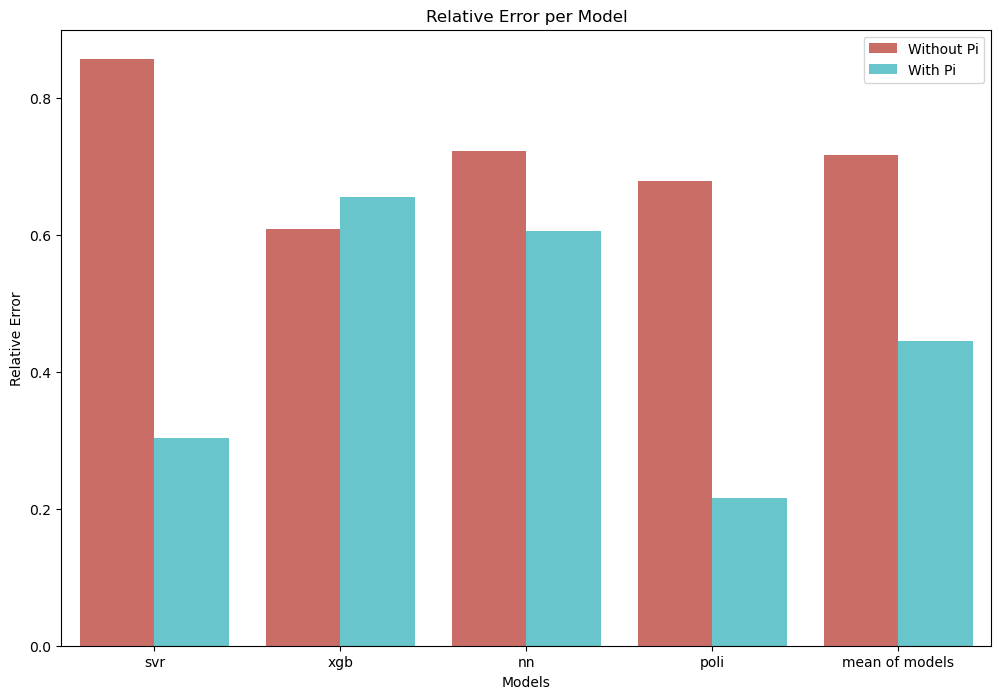

In [91]:
all_error = cv_scores_nopi + cv_scores_pi
plt.figure(figsize=(16,9))
create_fast_graph(all_error, aux_model = ['svr','xgb','nn','poli','mean of models'], title='Relative Error per Model')


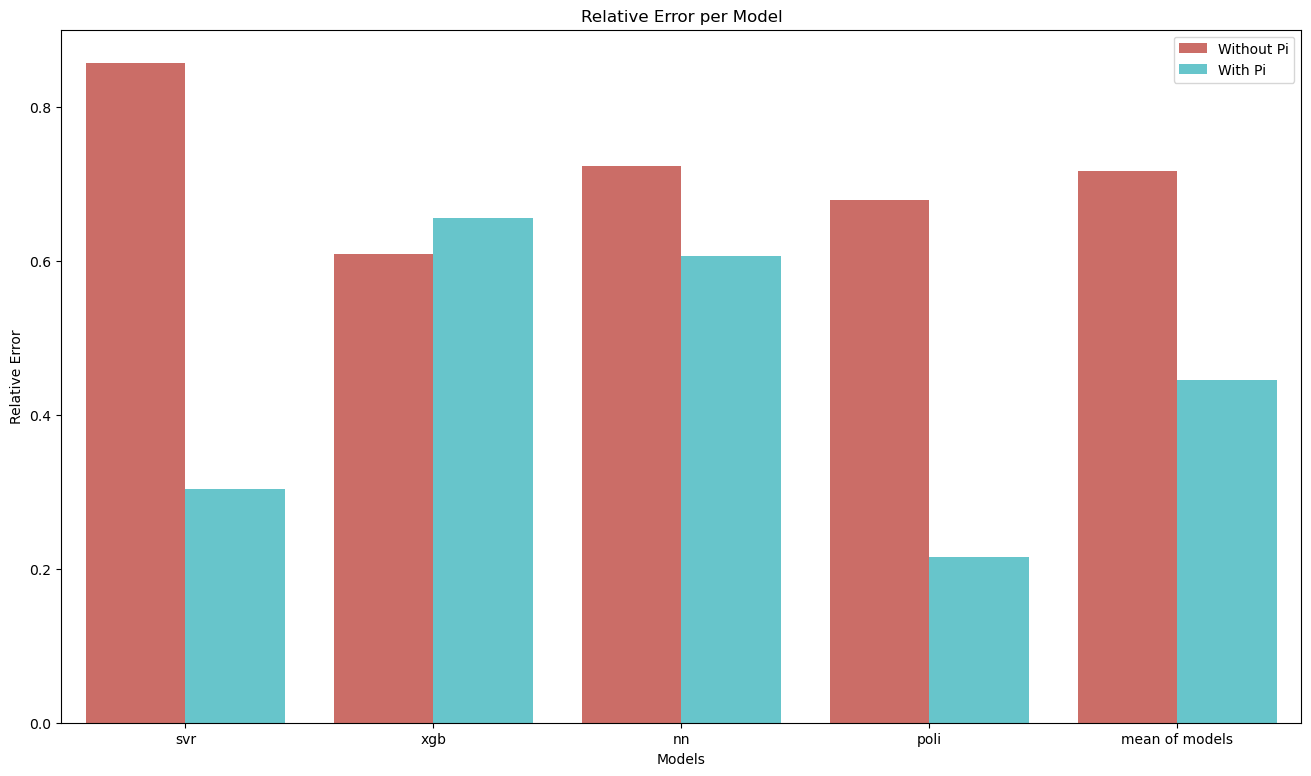

In [315]:
all_error = cv_scores_nopi + cv_scores_pi
plt.figure(figsize=(16,9))
create_fast_graph(all_error, aux_model = ['svr','xgb','nn','poli','mean of models'], title='Relative Error per Model')


### Feature Importance

In [150]:
#Definindo uma função pra gerar o gráfico das feature importance que já tenho + um resultado médio.
def get_feat_graph(df, title='Feature Importance per Model', figsize=(12,6)):
    feats = []
    new_error = []
    name = []
    df['Feature Name'] = df['hue']

    for i in df['hue']:
        if i not in feats:
            feats.append(i)
            name.append('Mean Feature Importance')
    
    for j in feats:
        error = df.loc[df['hue']==j]['Feature Importance'].mean()
        new_error.append(error)
    
    new_dict = {
        'Feature Importance':new_error,
        "Model's":name,
        "Feature Name":feats
    }

    new_df = pd.DataFrame(new_dict)

    new_df = pd.concat([df,new_df])

    plt.figure(figsize=figsize)
    ax = sns.barplot(new_df, x="Model's", y='Feature Importance', hue='Feature Name', palette='hls')
    ax.set_xlabel("Models")
    ax.set_ylabel("Feature Importance")
    ax.set_title(title)

In [67]:
feat_import01 = feat_importance(estim, ['svr','xgb','nn','poli'], ['Ei', 'Alpha'], x, y.ravel(), 
                cv=5, n_rounds=30, title='Iso')

In [68]:
feat_import01

Feature Importance Model's    hue
0            0.042821     svr     Ei
1            0.957179     svr  Alpha
2            0.128097     xgb     Ei
3            0.871903     xgb  Alpha
4            0.302855      nn     Ei
5            0.697145      nn  Alpha
6            0.008163    poli     Ei
7            0.991837    poli  Alpha

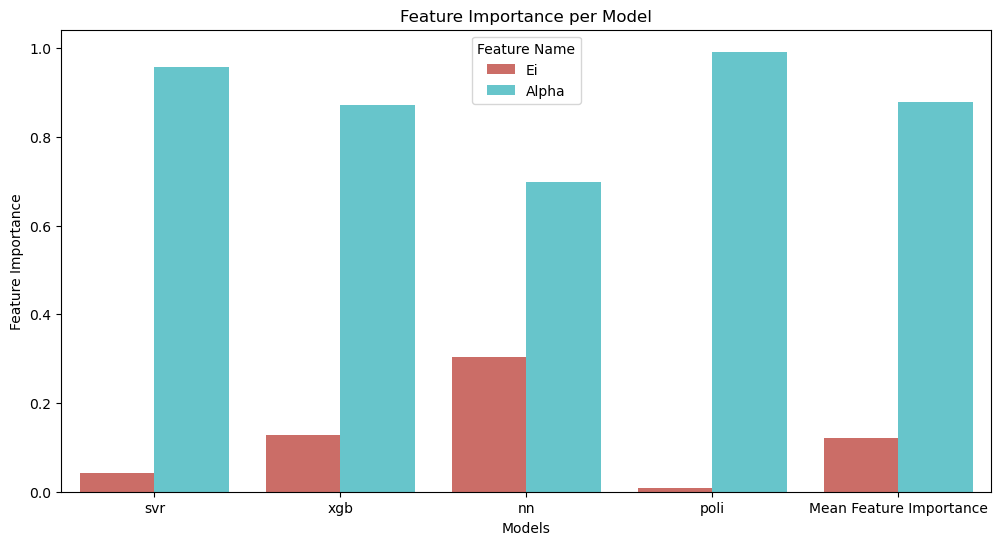

In [69]:
get_feat_graph(feat_import01)

In [73]:
#Iso com PI
feat_import02 = feat_importance(estim_pi, ['svr','xgb','nn','poli'], ['Ei', 'Alpha','Pi-Bond'], x_pi, y.ravel(), 
                cv=5, n_rounds=30, title='Iso Pi-Bond')

In [74]:
feat_import02

Feature Importance Model's      hue
0             0.049845     svr       Ei
1             0.714167     svr    Alpha
2             0.235988     svr  Pi-Bond
3             0.047877     xgb       Ei
4             0.865943     xgb    Alpha
5             0.086180     xgb  Pi-Bond
6             0.038087      nn       Ei
7             0.762776      nn    Alpha
8             0.199137      nn  Pi-Bond
9             0.086263    poli       Ei
10            0.461079    poli    Alpha
11            0.452659    poli  Pi-Bond

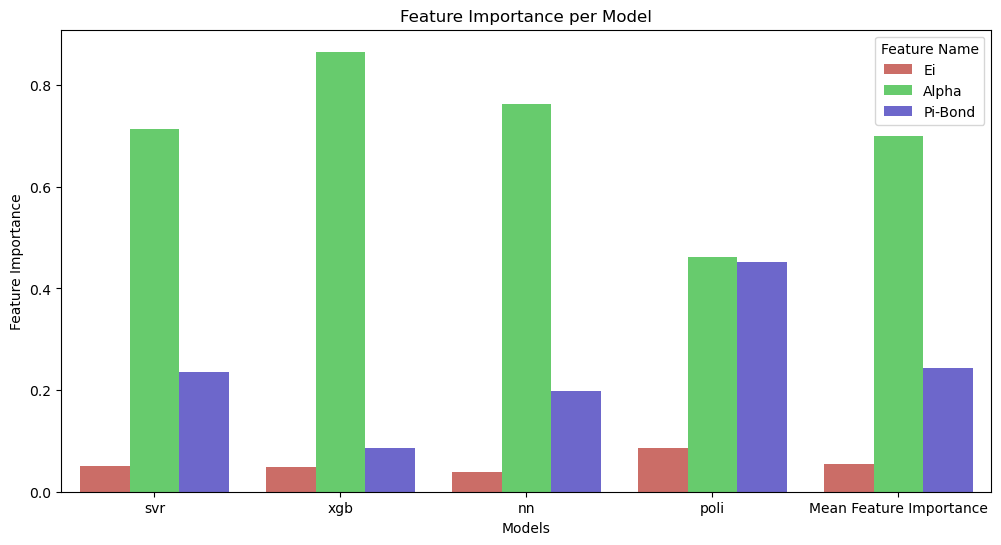

In [93]:
get_feat_graph(feat_import02)

## Feature Selection

### 2 Features

In [61]:
model = [] #Onde vai ficar armazenado a coluna dos modelos
feature_combination = [] #Onde vai ficar a combinação de features
features = np.zeros(x_pi.shape[1])

mean_scores = [] #O erro do evento modelo + conjunto de features
cv_scores = [] #O erro da validação cruzada de cada rodada
std_nopi = [] #Desvio padrão de cada rodade de conjunto de features.
neural = False
for i,j,k in zip(estim, spaces,estim_names): #Iteração sobre cada algoritmo.
    features = ['Ei','Alpha','pi_bond']
    print(f"Estamos em {k}")
    for w in range(len(features)):#Iteração sobre cada conjunto de variáveis
        print(f"Estamos retirando a feature {features[w]}")
        x_var = np.delete(x_pi, w, axis=1) #Criando a variável no qual vai ser treinado o algoritmo
        model.append(k) #Adicionando pra cada rodada o nome do algoritmo
        del features[w] #Deletando a feature que não será usada.
        feature_combination.append(f"{features[0]} + {features[1]}")#Gerando a string que vai definir a configuração de features.
        features = ['Ei','Alpha','pi_bond']

        neural = False
        if 'nn' in k:
            neural = True #Pra sinalizar que se trata de uma rede neural.
        error, std = nested_cv(i,j,x_var,y,10,5,neural=neural)#Nested CV e portanto cv_score
        cv_scores.append(error)
        mean_scores.append(np.mean(error))
        std_nopi.append(std)
#Depois é só criar o gráfico.

Estamos em svr
Estamos retirando a feature Ei
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature Alpha
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature pi_bond
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 7/10.
Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 9/10.
Out folder 10/10.
Estamos em xgb
Estamos retirando a feature Ei
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature Alpha
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature pi_bond
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Estamos retirando a feature Ei
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature Alpha
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos retirando a feature pi_bond
Out folder 1/10.
Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 9/10.
Out folder 10/10.
Estamos em poli
Estamos retirando a feature Ei
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.49297e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.3436e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.36751e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.51301e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.26914e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.42252e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.31589e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.20447e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.21158e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.1724e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.15657e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.33521e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.52458e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.23333e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.88024e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.55992e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.19196e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96612e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.42962e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.99793e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.88024e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.97561e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.53555e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.18247e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.09205e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.78773e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.06125e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.65894e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.50315e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.24445e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.61744e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.45313e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.52928e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.92237e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.79041e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Estamos retirando a feature Alpha
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.97775e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.66672e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.40463e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.41341e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.58421e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.65525e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.56615e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.94566e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.86353e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.78965e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.93818e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.47211e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.91443e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.56864e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.02893e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.08745e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.79521e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.85882e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.35843e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.10661e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.09975e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.08745e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.93529e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.5682e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.89623e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.58488e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.11687e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.5468e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.99399e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.02989e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.06016e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.94472e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.99597e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.79795e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.63499e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.059e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Estamos retirando a feature pi_bond
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


In [62]:
dict_2feat = {
    'Algorithm':model,
    'Error':mean_scores,
    'Feature Combination':feature_combination,
    'Standard Deviation': std_nopi
}
dict_2feat

{'Algorithm': ['svr',
  'svr',
  'svr',
  'xgb',
  'xgb',
  'xgb',
  'nn',
  'nn',
  'nn',
  'poli',
  'poli',
  'poli'],
 'Error': [0.28436930508131925,
  1.5060573166302558,
  1.0510368810345687,
  0.4839390131250137,
  1.2568773699373683,
  0.8873972831688473,
  0.35483888243288614,
  1.7372816632136918,
  0.7131716039333882,
  0.18638900188206636,
  1.6039121733131823,
  0.5993925499047779],
 'Feature Combination': ['Alpha + pi_bond',
  'Ei + pi_bond',
  'Ei + Alpha',
  'Alpha + pi_bond',
  'Ei + pi_bond',
  'Ei + Alpha',
  'Alpha + pi_bond',
  'Ei + pi_bond',
  'Ei + Alpha',
  'Alpha + pi_bond',
  'Ei + pi_bond',
  'Ei + Alpha'],
 'Standard Deviation': [0.26,
  1.64,
  1.12,
  0.3,
  1.39,
  0.73,
  0.35,
  2.1,
  0.68,
  0.21,
  2.12,
  0.61]}

### 1 Feature

In [ ]:
model = [] #Onde vai ficar armazenado a coluna dos modelos
feature_combination = [] #Onde vai ficar a combinação de features
features = ['Ei','Alpha','pi_bond']

mean_scores = [] #O erro do evento modelo + conjunto de features
cv_scores = [] #O erro da validação cruzada de cada rodada
std_nopi = [] #Desvio padrão de cada rodade de conjunto de features.
neural = False
for i,j,k in zip(estim, spaces,estim_names): #Iteração sobre cada algoritmo.
    print(f"Estamos em {k}")
    for w,z in zip([0,1,2], [1,2,0]):#Iteração sobre cada conjunto de variáveis
        restant_feats = features.copy()
        print(restant_feats, w, z)
        print(f"Estamos retirando a feature {restant_feats[w]} e {restant_feats[z]}")
        x_var = np.delete(x_pi, [w,z], axis=1) #Criando a variável no qual vai ser treinado o algoritmo
        model.append(k) #Adicionando pra cada rodada o nome do algoritmo
        restant_feats.remove(features[w]) #Deletando a feature que não será usada.
        restant_feats.remove(features[z]) #Deletando a segunda feature
        feature_combination.append(f"{restant_feats[0]}")#Gerando a string que vai definir a configuração de features.
        restant_feats = features.copy()
        
        neural = False
        if 'nn' in k:
            neural = True #Pra sinalizar que se trata de uma rede neural.
        error, std = nested_cv(i,j,x_var,y,10,5,neural=neural)#Nested CV e portanto cv_score
        cv_scores.append(error)
        mean_scores.append(np.mean(error))
        std_nopi.append(std)
#Depois é só criar o gráfico.

In [74]:
dict_1feat = {
    'Algorithm':model,
    'Error':mean_scores,
    'Feature Combination':feature_combination,
    'Standard Deviation': std_nopi
}
dict_1feat

{'Algorithm': ['svr',
  'svr',
  'svr',
  'xgb',
  'xgb',
  'xgb',
  'nn',
  'nn',
  'nn',
  'poli',
  'poli',
  'poli'],
 'Error': [1.4011716469906097,
  1.7129240486423434,
  0.41086754950562804,
  1.247716728892467,
  1.2614071933493434,
  0.4862614477811755,
  0.7545680259249146,
  0.9053589706062622,
  0.4811031281708245,
  0.657046672859722,
  1.9187300220837649,
  0.5894972884846259],
 'Feature Combination': ['pi_bond',
  'Ei',
  'Alpha',
  'pi_bond',
  'Ei',
  'Alpha',
  'pi_bond',
  'Ei',
  'Alpha',
  'pi_bond',
  'Ei',
  'Alpha'],
 'Standard Deviation': [1.43,
  1.5,
  0.29,
  1.39,
  1.39,
  0.37,
  0.16,
  0.5,
  0.31,
  0.29,
  2.05,
  0.4]}

In [26]:
# Fazendo Feature Selection pra stk_lin ou stk_lin_pi
x0_iso_all = df_pol[['Ei', 'Alpha']].values
x1_iso_all = df_pol[['Alpha','pi_bond']].values
x2_iso_all = df_pol[['Ei','pi_bond']].values

In [39]:
#Pra Ei + Alpha
nested_cv(stk_lin,space_stk_lin,x0_iso_all,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.2986638434682063
Desvio Padrão: 1.74
Score de Treino: 0.43027302382425725


(1.2986638434682063,
 1.74,
 0.43027302382425725,
 array([ 27.99730556,  29.36409885,  82.59524412,  65.82407414,
         99.67649629, 149.74802406, 199.06074867, 300.2467682 ,
         21.99437593,  42.33749161,  79.40622038,  69.67245062,
        154.05705831,  76.57210191,  67.47806243, 247.88923589,
        -94.03394809, 178.03067384, 116.08252083,  18.06045676]),
 array([2.00076984e-01, 5.10598353e-01, 3.24405515e-02, 3.73104056e-01,
        1.33247858e-01, 3.27449935e-02, 9.51784151e-02, 3.14620381e-02,
        9.97187965e-02, 3.23374916e+00, 7.42224530e-03, 5.35516996e-01,
        4.86476472e-01, 5.55711800e-03, 1.24634374e-01, 4.65798620e-02,
        1.04033948e+01, 2.12334516e+00, 6.73883472e+00, 7.59193910e-01]))

In [34]:
# Usando VotingRegressor
stacked_nested_cv(estim, estim_names, spaces, x0_iso_all, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.7329449360780872
Desvio Padrão: 0.69
Score de Treino: 0.287781190898077


(0.7329449360780872,
 0.69,
 0.287781190898077,
 array([ 25.89197334,  56.39490103,  87.89103549,  88.25095187,
        140.95266142, 174.9869854 , 234.15224882, 270.02386831,
         -3.61517055,  29.5781926 ,  79.88059056,  71.31480202,
        168.26200664,  54.98030218,  59.97667137, 257.5054645 ,
         51.45293092, 144.00903631,  57.24086901,  32.46582932]),
 array([2.60229333e-01, 6.00849829e-02, 9.86379436e-02, 1.59514744e-01,
        2.25675317e-01, 2.06806796e-01, 6.43284037e-02, 1.28955264e-01,
        1.18075853e+00, 1.95781926e+00, 1.49261797e-03, 5.24567987e-01,
        4.39126645e-01, 2.85970102e-01, 3.88810480e-04, 9.59436730e-03,
        4.14529309e+00, 1.52647432e+00, 2.81605793e+00, 5.67122276e-01]))

In [40]:
#Pra Alpha + Pi Bond
nested_cv(stk_lin_pi,space_stk_lin,x1_iso_all,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.29433133973895653
Desvio Padrão: 0.26
Score de Treino: 0.1401456446730785


(0.29433133973895653,
 0.26,
 0.1401456446730785,
 array([ 33.8365205 ,  56.03789748,  78.18607788, 100.06107521,
        117.58966895, 150.03974013, 223.64022486, 298.71875001,
         10.57777095,   2.95212576,  77.94915139, 143.93387305,
        457.31509488,  72.51041847,  57.74616404, 274.10420934,
         24.43481298,   9.41053972,  34.79648134,  81.95993419]),
 array([0.03324227, 0.06603504, 0.02267403, 0.04703738, 0.02251886,
        0.03475683, 0.01654648, 0.03639113, 0.47111145, 0.70478742,
        0.02563561, 0.04044085, 0.52438365, 0.05830625, 0.03756393,
        0.05424696, 1.4434813 , 0.83490281, 1.31976542, 0.09279912]))

In [36]:
# Voting Regressor
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x1_iso_all, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.20667456974418807
Desvio Padrão: 0.17
Score de Treino: 0.08057261715055802


(0.20667456974418807,
 0.17,
 0.08057261715055802,
 array([ 29.41427708,  55.41458942,  79.44221547,  98.54777809,
        144.63386147, 164.75846383, 223.99509734, 281.19997171,
          8.54995483,  12.45430767,  78.42722546, 136.07632882,
        239.542839  ,  70.83066849,  59.29264699, 279.63443139,
         19.30765515,  60.97726223,  30.30611733,  75.27911432]),
 array([0.15959208, 0.07642351, 0.00697231, 0.06144973, 0.25768575,
        0.13626527, 0.01815953, 0.09290332, 0.57250226, 0.24543077,
        0.01965968, 0.09282447, 0.20152387, 0.08012119, 0.01178922,
        0.07551704, 0.93076551, 0.06977653, 1.02040782, 0.00372152]))

In [48]:
#Pra Ei + Pi Bond
nested_cv(stk_lin_pi,space_stk_lin,x2_iso_all,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.7995189847691244
Desvio Padrão: 1.98
Score de Treino: 1.4434004660926787


(1.7995189847691244,
 1.98,
 1.4434004660926787,
 array([ 81.33477871,  93.36735667,  93.03404975, 160.03221832,
        134.26146108, 123.06668295, 112.21118662, 142.65208069,
        -23.61932933, 142.65208069, 169.1563861 , 227.72432749,
         80.90647708,  93.52220665, 100.48124371,  97.26638595,
         51.07612829,  80.37392972, 114.86973899, -43.11751684]),
 array([ 1.32385082,  0.55612261,  0.16292562,  0.52411636,  0.16749097,
         0.15126426,  0.48994915,  0.539832  ,  2.18096647, 13.26520807,
         1.11445483,  0.51816218,  0.73031174,  0.21457411,  0.6746874 ,
         0.62589852,  4.10761283,  0.41006894,  6.6579826 ,  1.57490022]))

In [37]:
# Voting Regressor
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x2_iso_all, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 1.3069251175279768
Desvio Padrão: 1.6
Score de Treino: 0.8102741135227369


(1.3069251175279768,
 1.6,
 0.8102741135227369,
 array([ 43.49154264,  25.10513236,  49.52933565,  63.29245142,
         54.38336873,  56.94925838,  72.2875345 , 116.06902894,
         42.28004899, 116.06902894,  42.46735934,  81.54437563,
        116.21396376,  76.34091473,  50.2084844 ,  55.30415918,
         59.2699184 ,  34.13154545,  48.22937255,  49.25443635]),
 array([2.42615504e-01, 5.81581127e-01, 3.80883304e-01, 3.97214748e-01,
        5.27101141e-01, 6.07246494e-01, 6.71420298e-01, 6.25583778e-01,
        1.11400245e+00, 1.06069029e+01, 4.69158008e-01, 4.56370829e-01,
        6.12620121e-01, 8.55954894e-03, 1.63191927e-01, 7.87291695e-01,
        4.92699184e+00, 4.01200957e-01, 2.21529150e+00, 3.43274182e-01]))

## Gráficos feature selection

In [213]:
#Função pra retornar um df com o acréscimo do resultado "médio"
def feat_select(df):
    feat_comb = []
    algorithm = []
    error = []
    for i in df['Feature Combination']:
        if i not in feat_comb:
            feat_comb.append(i)
    for i in feat_comb:
        algorithm.append('Mean Models Error')
        mean_error = df.loc[df['Feature Combination']==i]['Error'].mean()
        error.append(mean_error)
    new_dict = {
        "Error":error,
        "Algorithm":algorithm,
        "Feature Combination":feat_comb
    }
    new_df = pd.DataFrame(new_dict)
    new_df = pd.concat([df,new_df])

    return new_df

In [2]:
feat2_df = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_feature_selection/2feat.csv")
feat2_df.sort_values(by='Error')

Algorithm     Error Feature Combination  Standard Deviation
9       poli  0.186389     Alpha + pi_bond                0.21
0        svr  0.284369     Alpha + pi_bond                0.26
6         nn  0.354839     Alpha + pi_bond                0.35
3        xgb  0.483939     Alpha + pi_bond                0.30
11      poli  0.599393          Ei + Alpha                0.61
8         nn  0.713172          Ei + Alpha                0.68
5        xgb  0.887397          Ei + Alpha                0.73
2        svr  1.051037          Ei + Alpha                1.12
4        xgb  1.256877        Ei + pi_bond                1.39
1        svr  1.506057        Ei + pi_bond                1.64
10      poli  1.603912        Ei + pi_bond                2.12
7         nn  1.737282        Ei + pi_bond                2.10

In [16]:
print(list(feat2_df.loc[feat2_df['Feature Combination']=='Ei + pi_bond']['Error']))

[1.5060573166302558, 1.2568773699373683, 1.7372816632136918, 1.6039121733131825]


In [221]:
all_feat = [0.30388500026887394, 0.6556886361684493, 0.6061355752294845, 0.21566901002610464]
lil_dict = {
    'Error':all_feat,
    'Algorithm':['svr','xgb','nn','poli'],
    'Feature Combination':['All Features','All Features','All Features','All Features']
}
lil_df = pd.DataFrame(lil_dict)
feat2_df = pd.concat([feat2_df, lil_df])

Text(0.5, 1.0, 'Relativer Error per Model')

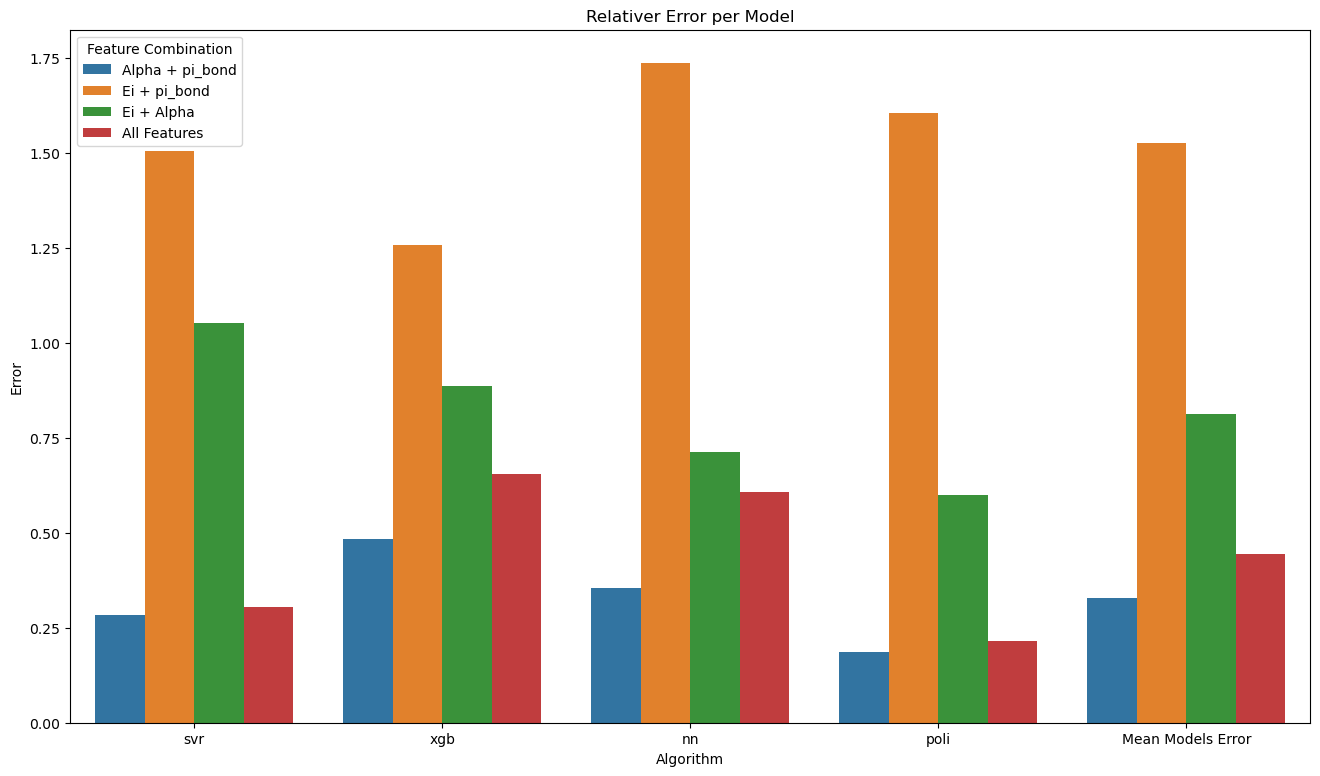

In [224]:
feat2_df = feat_select(feat2_df)
plt.figure(figsize=(16,9))
sns.barplot(feat2_df, x='Algorithm',y='Error',hue='Feature Combination').set_title('Relativer Error per Model')

In [229]:
feat1_df = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_feature_selection/1feat.csv")
feat1_df.sort_values(by='Error')

Algorithm     Error Feature Combination  Standard Deviation
2        svr  0.410868               Alpha                0.29
8         nn  0.481103               Alpha                0.31
5        xgb  0.486261               Alpha                0.37
11      poli  0.589497               Alpha                0.40
9       poli  0.657047             pi_bond                0.29
6         nn  0.754568             pi_bond                0.16
7         nn  0.905359                  Ei                0.50
3        xgb  1.247717             pi_bond                1.39
4        xgb  1.261407                  Ei                1.39
0        svr  1.401172             pi_bond                1.43
1        svr  1.712924                  Ei                1.50
10      poli  1.918730                  Ei                2.05

In [230]:
feat1_df = pd.concat([feat1_df, lil_df])
feat1_df

Algorithm     Error Feature Combination  Standard Deviation
0        svr  1.401172             pi_bond                1.43
1        svr  1.712924                  Ei                1.50
2        svr  0.410868               Alpha                0.29
3        xgb  1.247717             pi_bond                1.39
4        xgb  1.261407                  Ei                1.39
5        xgb  0.486261               Alpha                0.37
6         nn  0.754568             pi_bond                0.16
7         nn  0.905359                  Ei                0.50
8         nn  0.481103               Alpha                0.31
9       poli  0.657047             pi_bond                0.29
10      poli  1.918730                  Ei                2.05
11      poli  0.589497               Alpha                0.40
0        svr  0.303885        All Features                 NaN
1        xgb  0.655689        All Features                 NaN
2         nn  0.606136        All Features                 NaN
3       poli  0.215669        All Features                 NaN

Text(0.5, 1.0, 'Relative Error per Model')

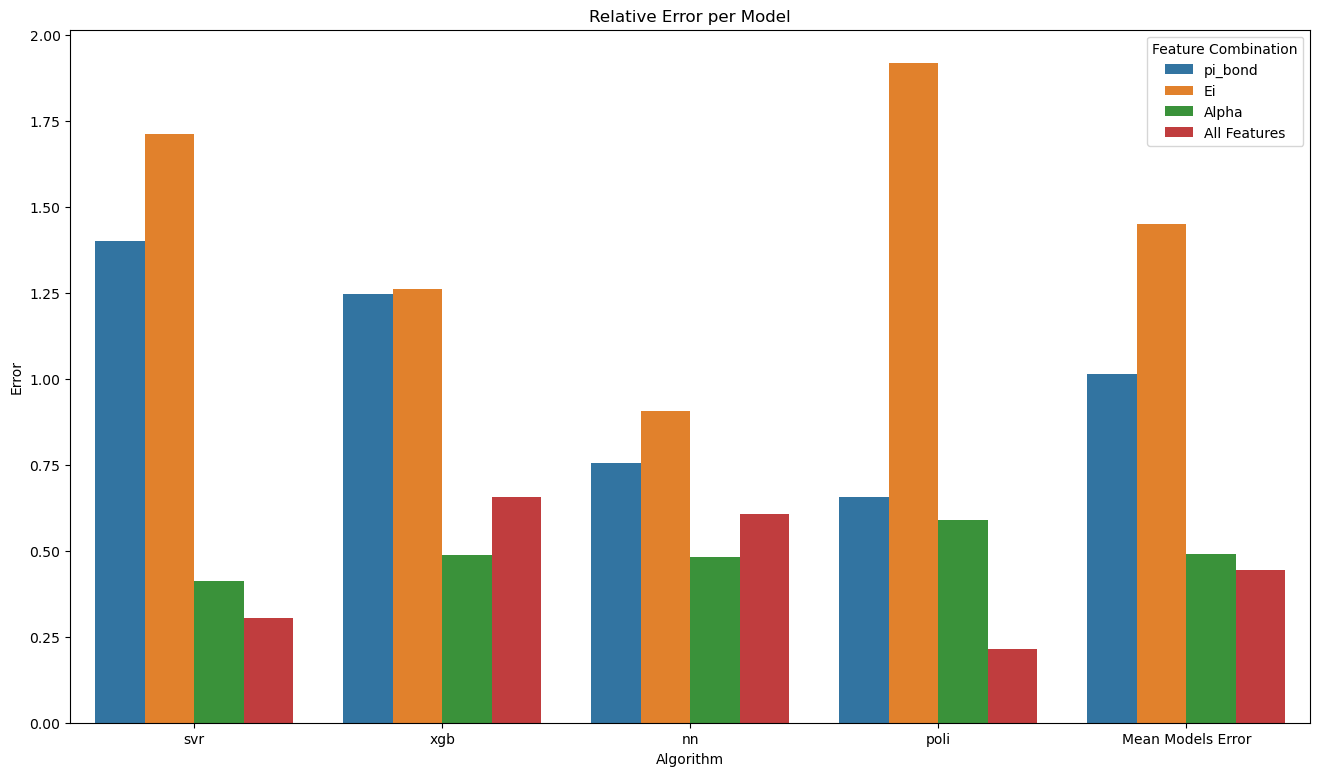

In [231]:
feat1_df = feat_select(feat1_df)
plt.figure(figsize=(16,9))
sns.barplot(feat1_df, x='Algorithm',y='Error',hue='Feature Combination').set_title('Relative Error per Model')

# Anisotropia 17 molecules

In [3]:
import numpy as np
import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.base import clone
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import seaborn as sns
from allfunc1 import *
from IPython.display import clear_output

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
df_pol = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/DataBase/expd_apolar_molecules.CSV")
#df_pol.loc[np.isnan(df_pol['axx'])].index


In [ ]:
df_pol.describe()

N of Carbon         Ei      Alpha        Expt         DYS          SG  \
count    12.000000  20.000000  20.000000   20.000000   17.000000    8.000000   
mean      7.583333   9.915000  12.932500  109.200000  115.764706  135.500000   
std       4.420167   0.602866   6.935953   94.098269  100.785372   81.177055   
min       2.000000   8.200000   4.200000   10.000000  -17.000000   26.000000   
25%       4.750000   9.825000   8.187500   51.500000   54.000000   79.250000   
50%       6.500000   9.900000  11.100000   78.500000   92.000000  130.500000   
75%       9.750000  10.225000  15.775000  146.250000  149.000000  181.500000   
max      16.000000  11.100000  30.300000  310.000000  306.000000  264.000000   

        PauloPred        axx        ayy        azz     AlphaB    pi_bond  
count   14.000000  17.000000  17.000000  17.000000  17.000000  20.000000  
mean   122.000000  13.096941  10.150647   8.183176  10.476922   0.750000  
std     95.408434   5.465676   4.035507   3.002566   3.907074   1.332785  
min     10.000000   5.429000   3.766000   3.346000   4.180333   0.000000  
25%     59.250000   9.758000   6.722000   5.726000   8.123333   0.000000  
50%     94.000000  12.271000   9.851000   7.814000   9.953667   0.000000  
75%    147.000000  15.103000  12.658000   9.826000  12.283000   1.000000  
max    308.000000  25.712000  18.700000  14.012000  18.079333   5.000000

In [39]:
df_pol = pd.read_csv("/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/DataBase/expd_apolar_molecules.CSV")
df_pol = df_pol.drop(df_pol.loc[np.isnan(df_pol['axx'])].index)
df_pol.reset_index(drop=True, inplace = True)

In [ ]:
df_pol.describe()

N of Carbon         Ei      Alpha        Expt         DYS          SG  \
count     9.000000  17.000000  17.000000   17.000000   14.000000    6.000000   
mean      5.444444   9.917647  10.520588   82.000000   84.785714   99.666667   
std       2.297341   0.656920   3.769659   70.851958   79.495698   53.720263   
min       2.000000   8.200000   4.200000   10.000000  -17.000000   26.000000   
25%       4.000000   9.600000   8.150000   35.000000   36.750000   63.750000   
50%       5.000000  10.000000  10.000000   75.000000   72.500000  102.000000   
75%       7.000000  10.300000  12.300000  105.000000  117.250000  137.250000   
max       9.000000  11.100000  17.400000  300.000000  296.000000  168.000000   

        PauloPred        axx        ayy        azz     AlphaB    pi_bond  
count   12.000000  17.000000  17.000000  17.000000  17.000000  17.000000  
mean    98.083333  13.096941  10.150647   8.183176  10.476922   0.882353  
std     77.854711   5.465676   4.035507   3.002566   3.907074   1.409005  
min     10.000000   5.429000   3.766000   3.346000   4.180333   0.000000  
25%     50.250000   9.758000   6.722000   5.726000   8.123333   0.000000  
50%     81.000000  12.271000   9.851000   7.814000   9.953667   0.000000  
75%    125.250000  15.103000  12.658000   9.826000  12.283000   1.000000  
max    301.000000  25.712000  18.700000  14.012000  18.079333   5.000000

In [ ]:
np.round(df_pol[['Molecule','Ei','Alpha','axx','ayy','azz','pi_bond','Expt']],2)

Molecule    Ei  Alpha    axx    ayy    azz  pi_bond  \
0                       Butane  10.6   8.10   9.31   7.68   7.24        0   
1                      Pentane  10.4  10.00  11.72   9.39   8.74        0   
2                       Hexane  10.2  11.80  14.32  10.99  10.23        0   
3                      Heptane   9.9  13.70  16.91  12.66  11.72        0   
4                       Octane  10.0  15.50  19.60  14.26  13.19        0   
5                       Nonane  10.0  17.40  21.31  14.93  14.01        0   
6                     Ethylene  10.5   4.20   5.43   3.77   3.35        1   
7                 Cyclopropane   9.9   5.70   5.75   5.75   5.04        0   
8                  Cyclohexane   9.9  11.80  11.29  11.29   9.78        0   
9                      Benzene   9.3  10.40  12.27  12.27   6.67        3   
10                 Naphthalene   8.2  16.60  25.71  18.70   9.83        5   
11             2-3-butanedione   9.3   8.20   9.76   9.07   6.12        2   
12                  IsoPentane  10.3  10.00  10.88   9.85   8.86        0   
13                     Propane  11.1   6.30   6.84   6.06   5.73        0   
14         Tetrachloroethylene   9.3  12.30  15.10  13.93   7.81        1   
15  1-2-trans-Dichloroethylene   9.6   8.15  12.53   6.72   5.56        1   
16             Carbondisulfide  10.1   8.70  13.90   5.23   5.23        2   

    Expt  
0     35  
1     60  
2     80  
3    105  
4    115  
5    145  
6     20  
7     10  
8     80  
9    150  
10   300  
11    77  
12    60  
13    10  
14    57  
15    15  
16    75

In [ ]:
np.round(df_pol[['Molecule','Ei','Alpha','axx','ayy','azz','pi_bond','Expt']],2).corr()

Ei     Alpha       axx       ayy       azz   pi_bond      Expt
Ei       1.000000 -0.480573 -0.597238 -0.641328 -0.142332 -0.787642 -0.727805
Alpha   -0.480573  1.000000  0.938984  0.933474  0.908715  0.174636  0.772464
axx     -0.597238  0.938984  1.000000  0.871719  0.752686  0.400110  0.843291
ayy     -0.641328  0.933474  0.871719  1.000000  0.786514  0.341583  0.834910
azz     -0.142332  0.908715  0.752686  0.786514  1.000000 -0.209295  0.528448
pi_bond -0.787642  0.174636  0.400110  0.341583 -0.209295  1.000000  0.698683
Expt    -0.727805  0.772464  0.843291  0.834910  0.528448  0.698683  1.000000

In [40]:
x = df_pol[['Ei','Alpha','pi_bond']].values
x_alpha = df_pol[['Ei','axx','ayy','azz', 'pi_bond']].values
x_only_aniso = df_pol[['axx','ayy','azz']].values
x_only_iso = df_pol[['Alpha']].values

y = df_pol[['Expt']].values

y.shape, x_only_aniso.shape, x_alpha.shape

((17, 1), (17, 3), (17, 5))

## Definindo os estimadores

### S/Pi_Bond

In [9]:
#O stacking tem que ser definido e executado primeiro, pois se não alterarei os estimadores básicos como SVR e etc.

ridge = Pipeline([('poli', PolynomialFeatures()), ('reg', linear_model.Ridge())])

svr = SVR(max_iter=5000)

xgb = XGBRegressor(random_state=0)

nn = MLPRegressor(max_iter = 2000, random_state = 0)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

reg1 = StackingRegressor([('poli', ridge), ('svr', svr), ('xgb',xgb), ('nn', nn)], final_estimator= LinearRegression(), cv = kf, n_jobs=-1)
pipe1 = Pipeline([('scaler', RobustScaler()), ('reg', reg1)])
stk_lin = TransformedTargetRegressor(transformer=StandardScaler(), regressor=pipe1)

space_stk_lin = [
    #Polinomial
    Real(1e-5,100, 'log-uniform', name='regressor__reg__poli__reg__alpha'),
    Integer(1,10,name='regressor__reg__poli__poli__degree'),
    #SVR
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__svr__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__svr__gamma'),
    Real(0.1, 1,prior='log-uniform', name = 'regressor__reg__svr__C'),
    #XGBoost
    Real(10e-5,0.2,  "log-uniform", name='regressor__reg__xgb__learning_rate'),
    Integer(100,2000,name = 'regressor__reg__xgb__n_estimators'),
    Integer(1,15,name='regressor__reg__xgb__max_depth'),
    Real(0.1, 1, name='regressor__reg__xgb__subsample'),
    #MLP
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__nn__activation'),
    Real(0,1e-3, name='regressor__reg__nn__alpha'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer')
]

#params_stk = ['tanh', 0.00029156446664498157, 12, 20, 0.5596277554095808, 0.5499611271712672, 1e-07, RobustScaler(), StandardScaler()]
#att_model(stk_lin, space_stk_lin, params_stk, neural=True, stacked=True)

In [41]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scaling', MinMaxScaler()),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scaling"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]

In [42]:
pipe = Pipeline([('scale',StandardScaler()), ('reg',SVR(max_iter=10000))])
svr = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 1,prior='log-uniform', name = 'regressor__reg__C'),
    Real(0.1,0.5,prior='log-uniform', name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]

In [43]:
xgb = XGBRegressor(random_state=0)

space_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

In [44]:
pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    #Real(0,1e-3, name='regressor__reg__alpha'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    #Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]

In [45]:
estim=[svr,xgb,nn, ridge]
estim_names = ['svr','xgb','nn','poli']
spaces = [space_svr, space_xgb,space_nn, space_poli]

### C/Pi_Bond

In [46]:
# Pra coordenadas em X.
scaler = ColumnTransformer([('scale', 
                              StandardScaler(),
                             [0,1]
                            )])
scaler

ColumnTransformer(transformers=[('scale', StandardScaler(), [0, 1])])

In [47]:
#Função pra transformar as colunas corretas, excetuando o pi_bond
def att_scaler(scaler, features):
    if 'pi_bond' in features:
        new_columns = [i for i in range(len(features)) if i!=features.index('pi_bond')]
        new_scaler = ColumnTransformer([('scale', 
                              StandardScaler(),
                             new_columns
                            )])
    scaler = new_scaler
    return scaler

In [48]:
pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge_pi = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())

space_pi_poli = [

    Real(1e-5,100, 'log-uniform', name='regressor__reg__alpha'),
    Categorical([True, False], name = 'regressor__reg__fit_intercept'),
    Categorical([True, False], name = 'regressor__reg__copy_X'),
    Integer(1,10,name='regressor__poli__degree'),
    Categorical([True,False], name='regressor__poli__interaction_only'),
    Categorical([True,False], name = 'regressor__poli__include_bias'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")

]

In [49]:
pipe = Pipeline([('scale',scaler),('reg',SVR(max_iter=10000))])
svr_pi = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)

space_pi_svr = [
    Categorical(['rbf','sigmoid','poly'], name = 'regressor__reg__kernel'),
    Categorical(['scale','auto'], name = 'regressor__reg__gamma'),
    Integer(1,10, name = 'regressor__reg__degree'),
    Real(0, 10, name = 'regressor__reg__coef0'),
    Real(0.1, 5, name = 'regressor__reg__C'),
    Real(0.01, 5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer") 
]

In [50]:
xgb_pi = XGBRegressor(random_state=0)

space_pi_xgb = [
    Real(10e-5,0.2,  "log-uniform", name='learning_rate'),
    Integer(100,2000,name = 'n_estimators'),
    Integer(1,15,name='max_depth'),
    Integer(1,15,name='min_child_weight'),
    Real(0, 6, name='gamma'),
    Real(0.1, 1, name='subsample'),
    Real(0.1,1,name='colsample_bytree'),
    Real(0,1,name="reg_alpha"),
    Real(0,1,name="reg_lambda")
]

In [51]:
pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn_pi = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())

space_pi_nn = [
    Categorical(['tanh','relu','logistic'], name = 'regressor__reg__activation'),
    #Categorical(['adam', 'sgd','lbfgs'], name = 'regressor__reg__solver'),
    #Real(0,1e-3, name='regressor__reg__alpha'),
    Real(1e-6,1e-3,prior='log-uniform', name = 'regressor__reg__learning_rate_init'),
    #Integer(100,3000, name = 'regressor__reg__max_iter'),
    #Real(1e-5,1e-3,name='regressor__reg__tol' ),
    #Real(0,1,name = 'regressor__reg__momentum'),
    Integer(1,20,name='n_hidden_layer'),
    Integer(1,20,name='n_neurons_per_layer'),
    Real(0.5,0.9,name = 'regressor__reg__beta_1'),
    Real(0.5,0.9,name = 'regressor__reg__beta_2'),
    #Real(1e-7, 1e-5, name = 'regressor__reg__epsilon'),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "regressor__scale__scale"),
    Categorical([StandardScaler(),MinMaxScaler(),RobustScaler()], name = "transformer")
    ]

In [52]:
#Antes de otimizar todo mundo preciso criar lista com estimadores, seus nomes 
#e seus espaços:
estim_pi=[svr_pi,xgb_pi,nn_pi, ridge_pi]
estim_pi_names = ['svr_pi','xgb_pi','nn_pi','poli_pi']
spaces_pi = [space_pi_svr, space_pi_xgb,space_pi_nn, space_pi_poli]


## Nested CV for All Combinations

In [108]:
#All features Isotropy
cv_scores_iso = []
train_error_iso = []
std_iso = []
dict_errors = {
}
features = ['Ei','Alpha', 'pi_bond']
scaler=att_scaler(scaler, features)
neural = False
for i,j,k in zip(estim_pi, spaces_pi,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x,y,10,5,neural=neural)
    cv_scores_iso.append(cv_error)
    std_iso.append(std)
    train_error_iso.append(train_error)
    dict_errors[f"{k} pred"] = test_pred
    dict_errors[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 4/10.
Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 8/10.
Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 10/10.
Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.
Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


In [109]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_iso)
print("O desvio padrão pra cada algoritmo é:", std_iso)
print("O erro de treino pra cada algorítmo é:",train_error_iso)
apolar1_df = pd.DataFrame(dict_errors)

O erro pra cada algorítmo no Nested-CV é: [0.8577438290570095, 0.9634033427914103, 0.9048556249955915, 0.8330685869714245]
O desvio padrão pra cada algoritmo é: [1.13, 0.73, 1.01, 0.63]
O erro de treino pra cada algorítmo é: [0.555743725017981, 0.24592095376313, 0.4977072729529574, 0.5008724421718338]


In [40]:
# O erro pra cada algorítmo no Nested-CV é: [0.8577438290570095, 0.9634033427914103, 0.9048556249955915, 0.8330685869714245]
# O desvio padrão pra cada algoritmo é: [1.13, 0.73, 1.01, 0.63]
# O erro de treino pra cada algorítmo é: [0.555743725017981, 0.24592095376313, 0.4977072729529574, 0.5008724421718338]

In [64]:
#Pra x stk
features = ['Ei','Alpha', 'pi_bond']
scaler = att_scaler(scaler, features)
nested_cv(stk_lin_pi, space_stk_lin,x,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.6701150296364455
Desvio Padrão: 0.71
Score de Treino: 0.19826319503116005


(0.6701150296364455,
 0.71,
 0.19826319503116005,
 array([ 27.2083294 ,  58.90250953,  89.49906963,  97.67560353,
        133.65424416, 133.46432635,  -4.10406723,  43.1472216 ,
         82.33387839, 169.18614928,  79.03047632,  34.60706124,
         56.68016194,  31.51845502,  19.31945542,  42.94652079,
         77.82530417]),
 array([0.22261916, 0.01829151, 0.11873837, 0.06975616, 0.16221082,
        0.07955637, 1.20520336, 3.31472216, 0.02917348, 0.12790766,
        0.73656508, 0.55055765, 0.05533063, 2.1518455 , 0.66106219,
        1.86310139, 0.03767072]))

In [53]:
features = ['Ei','Alpha', 'pi_bond']
scaler = att_scaler(scaler, features)
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.8576170069869923
Desvio Padrão: 0.87
Score de Treino: 0.38699639743850206


(0.8576170069869923,
 0.87,
 0.38699639743850206,
 array([ 25.40124552,  55.79577089,  67.86790121,  80.96169661,
        122.12498016, 103.97402643,   2.75942943,  43.91763797,
         74.86354542,  69.99429316, 132.84567403,  37.99765564,
         44.75128135,  29.23613089, 103.70850663,  59.90688843,
         26.58078933]),
 array([0.27425013, 0.07007049, 0.15165123, 0.22893622, 0.06195635,
        0.28293775, 0.86202853, 3.3917638 , 0.06420568, 0.53337138,
        0.55718109, 0.50652395, 0.25414531, 1.92361309, 0.81944748,
        2.99379256, 0.64558948]))

In [41]:
errorx0 = [0.8577438290570095, 0.9634033427914103, 0.9048556249955915, 0.8330685869714245]
mean_error0 = np.mean(errorx0)
errorx0.append(mean_error0)
features = 'All Features w/ Isotropy'
algorithm = ['svr', 'xgb', 'nn', 'poli','Mean Error']

dict_x0 = {
    'Error':errorx0,
    'Feature Combination':features,
    'Model':algorithm
}
df_x0 = pd.DataFrame(dict_x0)

In [94]:
#All features Anisotropy
cv_scores_iso = []
train_error_iso = []
std_iso = []
dict_errors = {
}
features = ['Ei','axx','ayy','azz', 'pi_bond']
scaler=att_scaler(scaler, features)
neural = False
for i,j,k in zip(estim_pi, spaces_pi,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x_alpha,y,10,5,neural=neural)
    cv_scores_iso.append(cv_error)
    std_iso.append(std)
    train_error_iso.append(train_error)
    dict_errors[f"{k} pred"] = test_pred
    dict_errors[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_ite

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 4/10.
Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Estamos em poli
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 3/10.
Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 5/10.
Out folder 6/10.
Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [95]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_iso)
print("O desvio padrão pra cada algoritmo é:", std_iso)
print("O erro de treino pra cada algorítmo é:",train_error_iso)
apolar1_df = pd.DataFrame(dict_errors)

O erro pra cada algorítmo no Nested-CV é: [0.815207450017606, 0.8092087790321199, 1.1388293602722248, 0.6554296437229616]
O desvio padrão pra cada algoritmo é: [1.39, 0.87, 1.83, 1.16]
O erro de treino pra cada algorítmo é: [0.6008128497794727, 0.10511119850655662, 0.5397716482312451, 0.5094389098443364]


In [65]:
#Pra x_alpha stk
features = ['Ei','axx','ayy','azz', 'pi_bond']
scaler = att_scaler(scaler, features)
nested_cv(stk_lin_pi, space_stk_lin,x_alpha,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.6643128031923846
Desvio Padrão: 0.66
Score de Treino: 0.30437501800053435


(0.6643128031923846,
 0.66,
 0.30437501800053435,
 array([ 35.66839573,  61.38480642,  71.71732782, 107.86729008,
        147.67988068, 124.74191936,   9.56264025, -27.37799515,
         74.51065755,  61.29951985, 275.89649146,  26.24127423,
         60.63763417,  15.36772386, 121.87280998,  39.53522387,
        -69.22228057]),
 array([0.01909702, 0.02308011, 0.1035334 , 0.02730752, 0.28417288,
        0.1397109 , 0.52186799, 3.73779952, 0.06861678, 0.59133653,
        0.08034503, 0.65920423, 0.01062724, 0.53677239, 1.13811947,
        1.63568159, 1.92296374]))

In [54]:
features = ['Ei','axx','ayy','azz', 'pi_bond']
scaler = att_scaler(scaler, features)
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x_alpha, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.794453376970047
Desvio Padrão: 1.19
Score de Treino: 0.4375594676630182


(0.794453376970047,
 1.19,
 0.4375594676630182,
 array([ 27.13306513,  58.43863788,  93.91001055,  73.68574345,
        130.71718091, 129.51160228,  13.77513902,  35.15230538,
         59.12111415,  80.49634855, 154.64201839,  81.8638047 ,
         48.62445424,  18.80116465, 120.26362054,  77.23868737,
         78.72552178]),
 array([0.22476957, 0.0260227 , 0.17387513, 0.29823101, 0.13667114,
        0.10681654, 0.31124305, 2.51523054, 0.26098607, 0.46335768,
        0.48452661, 0.06316629, 0.18959243, 0.88011646, 1.10988808,
        4.14924582, 0.04967362]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [0.815207450017606, 0.8092087790321199, 1.1388293602722248, 0.6554296437229616]
# O desvio padrão pra cada algoritmo é: [1.39, 0.87, 1.83, 1.16]
# O erro de treino pra cada algorítmo é: [0.6008128497794727, 0.10511119850655662, 0.5397716482312451, 0.5094389098443364]

In [39]:
errorx1 = [0.815207450017606, 0.8092087790321199, 1.1388293602722248, 0.6554296437229616]
mean_error1 = np.mean(errorx1)
errorx1.append(mean_error1)
features1 = 'All Features w/ Anisotropy'
algorithm0 = ['svr', 'xgb', 'nn', 'poli','Mean Error']

dict_x1 = {
    'Error':errorx1,
    'Feature Combination':features1,
    'Model':algorithm0
}
df_x1 = pd.DataFrame(dict_x1)

In [96]:
#Only isotropy
cv_scores_iso = []
train_error_iso = []
std_iso = []
dict_errors = {
}
neural = False
for i,j,k in zip(estim, spaces,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x_only_iso,y,10,5,neural=neural)
    cv_scores_iso.append(cv_error)
    std_iso.append(std)
    train_error_iso.append(train_error)
    dict_errors[f"{k} pred"] = test_pred
    dict_errors[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


In [97]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_iso)
print("O desvio padrão pra cada algoritmo é:", std_iso)
print("O erro de treino pra cada algorítmo é:",train_error_iso)
apolar1_df = pd.DataFrame(dict_errors)

O erro pra cada algorítmo no Nested-CV é: [0.6333215341407575, 0.5874395016112639, 0.47188539547495384, 0.7666195840065334]
O desvio padrão pra cada algoritmo é: [0.56, 0.56, 0.3, 0.65]
O erro de treino pra cada algorítmo é: [0.47057476940003423, 0.30933948378434584, 0.41391687768501545, 0.41277458549509427]


In [66]:
#Pra x_only_iso stk
nested_cv(stk_lin, space_stk_lin, x_only_iso,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.5090465303159228
Desvio Padrão: 1.3
Score de Treino: 0.5266727276968883


(1.5090465303159228,
 1.3,
 0.5266727276968883,
 array([ 30.63879842,  58.99946211, 110.65517249,  85.67971976,
        336.8247261 , 297.29215131, 134.87078547,  41.39096028,
        110.61395144,  81.75981293, 122.83929087,  14.47845425,
         75.53589578, -56.3036639 , 117.38754262,  55.15384668,
         18.09672348]),
 array([0.12460576, 0.01667563, 0.38318966, 0.18400267, 1.92891066,
        1.0502907 , 5.74353927, 3.13909603, 0.38267439, 0.45493458,
        0.5905357 , 0.81196813, 0.2589316 , 6.63036639, 1.05943057,
        2.67692311, 0.75871035]))

In [55]:
stacked_nested_cv(estim, estim_names, spaces, x_only_iso, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.5661049342436465
Desvio Padrão: 0.37
Score de Treino: 0.3310218615328101


(0.5661049342436465,
 0.37,
 0.3310218615328101,
 array([ 29.72056699,  49.56358618,  69.53579432,  92.49024696,
        129.94957594, 265.2779872 ,  -3.8516848 ,  15.26943328,
         64.86989829,  53.0345217 , 115.41016448,  27.89256931,
         48.70170427,  19.48363048,  74.00273628,  37.20518708,
         32.530154  ]),
 array([0.15084094, 0.17394023, 0.13080257, 0.11914051, 0.12999631,
        0.82950336, 1.19258424, 0.52694333, 0.18912627, 0.64643652,
        0.61529945, 0.63775884, 0.18830493, 0.94836305, 0.29829362,
        1.48034581, 0.56626461]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [0.6333215341407575, 0.5874395016112639, 0.47188539547495384, 0.7666195840065334]
# O desvio padrão pra cada algoritmo é: [0.56, 0.56, 0.3, 0.65]
# O erro de treino pra cada algorítmo é: [0.47057476940003423, 0.30933948378434584, 0.41391687768501545, 0.41277458549509427]

In [38]:
errorx2 =[0.6333215341407575, 0.5874395016112639, 0.47188539547495384, 0.7666195840065334]
mean_error2 = np.mean(errorx2)
errorx2.append(mean_error2)
features2 = 'Only Isotropy'
algorithm0 = ['svr', 'xgb', 'nn', 'poli','Mean Error']

dict_x2 = {
    'Error':errorx2,
    'Feature Combination':features2,
    'Model':algorithm0
}
df_x2 = pd.DataFrame(dict_x2)

In [98]:
#Only anisotropy
cv_scores_aniso = []
train_error_aniso = []
std_aniso = []
dict_errors = {
}
neural = False
for i,j,k in zip(estim, spaces,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x_only_aniso,y,10,5,neural=neural)
    cv_scores_aniso.append(cv_error)
    std_aniso.append(std)
    train_error_aniso.append(train_error)
    dict_errors[f"{k} pred"] = test_pred
    dict_errors[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluate

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [99]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores_aniso)
print("O desvio padrão pra cada algoritmo é:", std_aniso)
print("O erro de treino pra cada algorítmo é:",train_error_aniso)
apolar2_df = pd.DataFrame(dict_errors)

O erro pra cada algorítmo no Nested-CV é: [0.8044244614883093, 0.8849947561640625, 1.0094836811049508, 0.8791904718917835]
O desvio padrão pra cada algoritmo é: [0.98, 1.38, 1.28, 1.07]
O erro de treino pra cada algorítmo é: [0.4813215613773346, 0.3192938113886812, 0.3685482769555368, 0.37120911712007415]


In [67]:
#Pra x_only_aniso stk
nested_cv(stk_lin, space_stk_lin, x_only_aniso,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.9162042711452651
Desvio Padrão: 0.99
Score de Treino: 0.5779590756151836


(0.9162042711452651,
 0.99,
 0.5779590756151836,
 array([ 54.14294614,  64.64948973,  76.93259375, 105.34558568,
        104.48945441, 150.02140818,  12.31772523,  28.91697402,
         64.76014987,  42.97451798,  83.64488006,  32.07723576,
         69.7107328 ,  47.66966975, 172.33476324,  65.17570582,
         59.3411944 ]),
 array([5.46941318e-01, 7.74914955e-02, 3.83425782e-02, 3.29129218e-03,
        9.13960486e-02, 3.46304012e-02, 3.84113739e-01, 1.89169740e+00,
        1.90498127e-01, 7.13503213e-01, 7.21183733e-01, 5.83412523e-01,
        1.61845547e-01, 3.76696698e+00, 2.02341690e+00, 3.34504705e+00,
        2.08784075e-01]))

In [56]:
stacked_nested_cv(estim, estim_names, spaces, x_only_aniso, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.8164118811790926
Desvio Padrão: 1.19
Score de Treino: 0.32191239577169634


(0.8164118811790926,
 1.19,
 0.32191239577169634,
 array([ 36.83164333,  54.1285428 ,  72.06485405,  82.19873195,
        134.61558161, 118.18431712,   2.00541952,  14.41936408,
         66.7458915 ,  56.43663226, 124.56973381,  30.06323091,
         53.22588296,  23.34655729, 120.70395703,  79.94803501,
         25.64873648]),
 array([0.05233267, 0.09785762, 0.09918932, 0.21715493, 0.17057027,
        0.18493574, 0.89972902, 0.44193641, 0.16567636, 0.62375578,
        0.58476755, 0.60956843, 0.11290195, 1.33465573, 1.11761328,
        4.329869  , 0.65801685]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [0.8044244614883093, 0.8849947561640625, 1.0094836811049508, 0.8791904718917835]
# O desvio padrão pra cada algoritmo é: [0.98, 1.38, 1.28, 1.07]
# O erro de treino pra cada algorítmo é: [0.4813215613773346, 0.3192938113886812, 0.3685482769555368, 0.37120911712007415]

In [45]:
errorx3 =[0.8044244614883093, 0.8849947561640625, 1.0094836811049508, 0.8791904718917835]
mean_error3 = np.mean(errorx3)
errorx3.append(mean_error3)
features3 = 'Only Anisotropy'
algorithm0 = ['svr', 'xgb', 'nn', 'poli','Mean Error']

dict_x3 = {
    'Error':errorx3,
    'Feature Combination':features3,
    'Model':algorithm0
}
df_x3 = pd.DataFrame(dict_x3)

<AxesSubplot:xlabel='Model', ylabel='Error'>

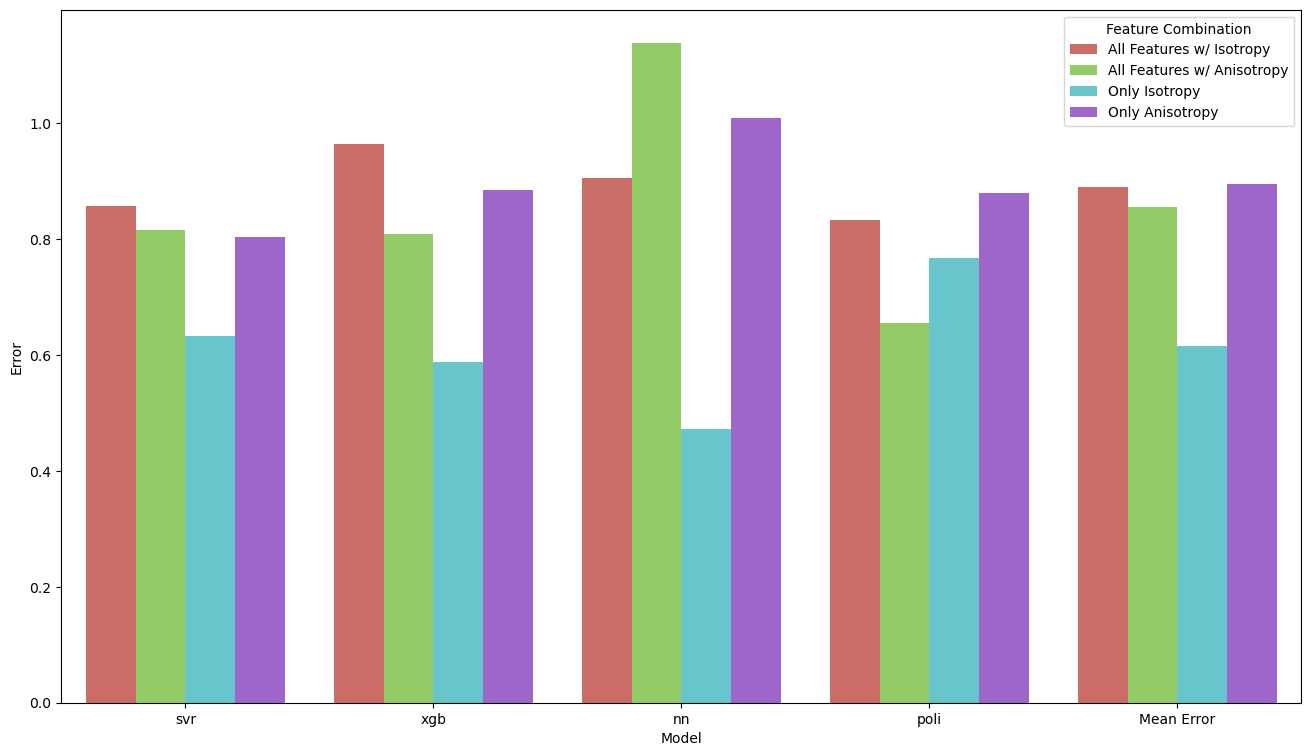

In [312]:
full_df = pd.concat([df_x0,df_x1,df_x2,df_x3])
plt.figure(figsize=(16,9))
sns.barplot(full_df, x='Model',y='Error',hue='Feature Combination', palette='hls',errorbar=('ci', 0))

## Feature Selection Anisotropia

In [57]:
#Combinations of all features (anisotropy besides isotropy)
x0 = df_pol[['axx','ayy','azz','Ei']].values
x1 = df_pol[['axx','ayy','azz','pi_bond']].values
x2 = df_pol[['Ei','pi_bond']].values

In [101]:
#Pra x0
cv_scores0 = []
train_error0 = []
std0 = []
dict_errors0 = {
}
for i,j,k in zip(estim, spaces,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x0,y,10,5,neural=neural)
    cv_scores0.append(cv_error)
    std0.append(std)
    train_error0.append(train_error)
    dict_errors0[f"{k} pred"] = test_pred
    dict_errors0[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 4/10.
Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 6/10.
Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

In [102]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores0)
print("O desvio padrão pra cada algoritmo é:", std0)
print("O erro de treino pra cada algorítmo é:",train_error0)
polar0_df = pd.DataFrame(dict_errors0)
polar0_df.to_csv("x0_polar_error.csv", index=False)

O erro pra cada algorítmo no Nested-CV é: [1.0152723399614774, 1.069177294606293, 1.088765926401479, 0.8608315444325934]
O desvio padrão pra cada algoritmo é: [1.21, 1.47, 1.18, 1.31]
O erro de treino pra cada algorítmo é: [0.5680104206190975, 0.3262087664866024, 0.48923452352730806, 0.4068558258323434]


In [69]:
#Pra x0 stk
nested_cv(stk_lin, space_stk_lin,x0,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.1358725693802356
Desvio Padrão: 1.51
Score de Treino: 0.8067609551654213


(1.1358725693802356,
 1.51,
 0.8067609551654213,
 array([  26.52748168,   65.79853833,  101.58275773,  146.535206  ,
         159.1519735 ,  119.12446571,   -0.69942628,   64.19298295,
          64.06816702,   69.60237391, -165.97328341,   57.17039483,
          56.64671206,   24.87774423,  111.73982829,   84.69724561,
          66.03696033]),
 array([0.24207195, 0.09664231, 0.26978447, 0.39557339, 0.3839302 ,
        0.17845196, 1.03497131, 5.41929829, 0.19914791, 0.53598417,
        1.55324428, 0.25752734, 0.05588813, 1.48777442, 0.96034786,
        4.64648304, 0.1195072 ]))

In [58]:
stacked_nested_cv(estim, estim_names, spaces, x0, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.9771030960372385
Desvio Padrão: 1.28
Score de Treino: 0.3882114626812245


(0.9771030960372385,
 1.28,
 0.3882114626812245,
 array([ 23.1186157 ,  51.70694125,  78.86073075,  58.28973755,
        116.75159129, 104.78042334,  -1.26339883,  30.38324134,
         65.30185065,  72.24077533, 129.17730793,  59.7640211 ,
         50.75827896,  25.47008455, 141.5282798 ,  85.31215518,
         20.5911839 ]),
 array([0.33946812, 0.13821765, 0.01424087, 0.44485964, 0.01523123,
        0.27737639, 1.06316994, 2.03832413, 0.18372687, 0.51839483,
        0.56940897, 0.22384388, 0.15402868, 1.54700846, 1.48295228,
        4.68747701, 0.72545088]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [1.0152723399614774, 1.069177294606293, 1.088765926401479, 0.8608315444325934, 1.1358725693802356]
# O desvio padrão pra cada algoritmo é: [1.21, 1.47, 1.18, 1.31]
# O erro de treino pra cada algorítmo é: [0.5680104206190975, 0.3262087664866024, 0.48923452352730806, 0.4068558258323434]

In [316]:
cv_scores0 = [1.0152723399614774, 1.069177294606293, 1.088765926401479, 0.8608315444325934]

In [103]:
#Pra x1
cv_scores1 = []
train_error1 = []
std1 = []
dict_errors1 = {
}
features = ['axx','ayy','azz','pi_bond']
scaler=att_scaler(scaler, features)

for i,j,k in zip(estim_pi, spaces_pi,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x1,y,10,5,neural=neural,verbose=1)
    cv_scores1.append(cv_error)
    std1.append(std)
    train_error1.append(train_error)
    dict_errors1[f"{k} pred"] = test_pred
    dict_errors1[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0280
Function value obtained: 3.1958
Current minimum: 3.1958
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0214
Function value obtained: 3.2536
Current minimum: 3.1958
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0221
Function value obtained: 3.2536
Current minimum: 3.1958
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0205
Function value obtained: 3.2536
Current minimum: 3.1958
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0199
Function value obtained: 3.2536
Current minimum: 3.1958
Ite

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.5396
Function value obtained: 2.8690
Current minimum: 0.4941
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.3470
Function value obtained: 3.7413
Current minimum: 0.4941
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.2957
Function value obtained: 0.5914
Current minimum: 0.4941
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.2897
Function value obtained: 0.9876
Current minimum: 0.4941
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.2556
Function value obtained: 2.0990
Current minimum: 0.4941
Iteration No: 114 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.2227
Function value obtained: 1.6505
Current minimum: 0.4939
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 1.9394
Function value obtained: 1.6148
Current minimum: 0.4939
Iteration No: 105 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 1.8697
Function value obtained: 65.8879
Current minimum: 0.4939
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.0890
Function value obtained: 0.6792
Current minimum: 0.4939
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.1083
Function value obtained: 3.5605
Current minimum: 0.4939
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2585
Function value obtained: 1.4374
Current minimum: 0.4939
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.4864
Function value obtained: 0.6724
Current minimum: 0.4939
Iteration No: 110 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.8958
Function value obtained: 1.2621
Current minimum: 0.4939
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.8355
Function value obtained: 1.1636
Current minimum: 0.4939
Iteration No: 132 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.8401
Function value obtained: 3.4784
Current minimum: 0.4939
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.8781
Function value obtained: 0.8186
Current minimum: 0.4939
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.0275
Function value obtained: 0.4939
Current minimum: 0.4939
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.7581
Function value obtained: 0.4941
Current minimum: 0.4939
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.7663
Function value obtained: 3.5605
Current minimum: 0.4939
Iteration No: 137 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 68 ended. Evaluation done at random point.
Time taken: 0.0357
Function value obtained: 2.3831
Current minimum: 0.7259
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.0332
Function value obtained: 1.5063
Current minimum: 0.7259
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 0.0387
Function value obtained: 2.5812
Current minimum: 0.7259
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.0331
Function value obtained: 2.9235
Current minimum: 0.7259
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0301
Function value obtained: 1.3804
Current minimum: 0.7259
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.0492
Function value obtained: 7.4984
Current minimum: 0.7259
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 1.8568
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 1.9547
Function value obtained: 0.7298
Current minimum: 0.6658
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.0003
Function value obtained: 1.0440
Current minimum: 0.6658
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.1121
Function value obtained: 1.1667
Current minimum: 0.6658
Iteration No: 108 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.3181
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 110 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.4712
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 111 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.3135
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 112 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.4286
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 113 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.5022
Function value obtained: 0.6658
Current minimum: 0.6658
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.2197
Function value obtained: 0.6978
Current minimum: 0.6658
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.1152
Function value obtained: 0.6258
Current minimum: 0.6258
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.2904
Function value obtained: 0.6474
Current minimum: 0.6258
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.2525
Function value obtained: 0.9926
Current minimum: 0.6258
Iteration No: 118 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.9467
Function value obtained: 0.6437
Current minimum: 0.5481
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 2.7952
Function value obtained: 0.6016
Current minimum: 0.5481
Iteration No: 139 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.0278
Function value obtained: 0.6437
Current minimum: 0.5481
Iteration No: 140 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.0219
Function value obtained: 0.6437
Current minimum: 0.5481
Iteration No: 141 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 2.8342
Function value obtained: 0.6437
Current minimum: 0.5481
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 2.8152
Function value obtained: 0.6658
Current minimum: 0.5481
Iteration No: 143 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.7377
Function value obtained: 0.6437
Current minimum: 0.5481
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 2.8092
Function value obtained: 0.5630
Current minimum: 0.5481
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 2.7786
Function value obtained: 0.7000
Current minimum: 0.5481
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.0841
Function value obtained: 0.5481
Current minimum: 0.5481
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 2.9114
Function value obtained: 0.6658
Current minimum: 0.5481
Iteration No: 148 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 2.9585
Function value obtained: 0.6016
Current minimum: 0.5481
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.0786
Function value obtained: 0.5481
Current minimum: 0.5481
Out folder 4/10.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0229
Function value obtained: 3.6806
Current minimum: 3.6806
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0205
Function value obtained: 3.7156
Current minimum: 3.6806
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0228
Function value obtained: 3.7156
Current minimum: 3.6806
Iteration No: 4 started. Evaluating function at ran

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.7189
Function value obtained: 0.5802
Current minimum: 0.5017
Iteration No: 129 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.5542
Function value obtained: 4.4486
Current minimum: 0.5017
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.6009
Function value obtained: 0.5817
Current minimum: 0.5017
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.6535
Function value obtained: 0.5145
Current minimum: 0.5017
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.5937
Function value obtained: 0.5106
Current minimum: 0.5017
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.5513
Function value obtained: 0.6197
Current minimum: 0.5017
Iteration No: 134 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 66 ended. Evaluation done at random point.
Time taken: 0.0357
Function value obtained: 1.0543
Current minimum: 0.6728
Iteration No: 67 started. Evaluating function at random point.
Iteration No: 67 ended. Evaluation done at random point.
Time taken: 0.0310
Function value obtained: 1.2240
Current minimum: 0.6728
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 0.0386
Function value obtained: 1.2240
Current minimum: 0.6728
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.0372
Function value obtained: 1.1150
Current minimum: 0.6728
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 0.0342
Function value obtained: 1.2240
Current minimum: 0.6728
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.1511
Function value obtained: 0.5425
Current minimum: 0.5302
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.3163
Function value obtained: 0.5422
Current minimum: 0.5302
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.3869
Function value obtained: 0.5736
Current minimum: 0.5302
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.3602
Function value obtained: 0.5426
Current minimum: 0.5302
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.3891
Function value obtained: 0.5426
Current minimum: 0.5302
Iteration No: 149 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.9610
Function value obtained: 0.4874
Current minimum: 0.4204
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.6775
Function value obtained: 0.4136
Current minimum: 0.4136
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.2279
Function value obtained: 0.4874
Current minimum: 0.4136
Iteration No: 120 started. Searching for the next optimal point.
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.6541
Function value obtained: 0.6287
Current minimum: 0.4136
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.7332
Function value obtained: 0.4464
Current minimum: 0.4136
Iteration No: 122 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 2.1082
Function value obtained: 5.5673
Current minimum: 0.8000
Iteration No: 102 started. Searching for the next optimal point.
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.0169
Function value obtained: 0.5474
Current minimum: 0.5474
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.2093
Function value obtained: 0.8280
Current minimum: 0.5474
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.0582
Function value obtained: 0.5461
Current minimum: 0.5461
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.0452
Function value obtained: 0.6330
Current minimum: 0.5461
Iteration No: 106 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.1479
Function value obtained: 0.5461
Current minimum: 0.5461
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.3980
Function value obtained: 0.5419
Current minimum: 0.5419
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.3089
Function value obtained: 0.7915
Current minimum: 0.5419
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.9376
Function value obtained: 0.5419
Current minimum: 0.5419
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.2777
Function value obtained: 0.5454
Current minimum: 0.5419
Iteration No: 116 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.8123
Function value obtained: 0.5461
Current minimum: 0.5419
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.6120
Function value obtained: 0.5461
Current minimum: 0.5419
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.3609
Function value obtained: 0.7858
Current minimum: 0.5419
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.4738
Function value obtained: 3.2617
Current minimum: 0.5419
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.4551
Function value obtained: 0.5634
Current minimum: 0.5419
Iteration No: 127 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.6160
Function value obtained: 11.9973
Current minimum: 0.5419
Iteration No: 128 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.5783
Function value obtained: 5.1884
Current minimum: 0.5419
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.4245
Function value obtained: 1.4425
Current minimum: 0.5419
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.5539
Function value obtained: 0.7562
Current minimum: 0.5419
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.7427
Function value obtained: 0.8008
Current minimum: 0.5419
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.6076
Function value obtained: 0.6776
Current minimum: 0.5419
Iteration No: 133 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.2668
Function value obtained: 2.7551
Current minimum: 0.6624
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.0941
Function value obtained: 0.7939
Current minimum: 0.6624
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.3900
Function value obtained: 0.9783
Current minimum: 0.6624
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2800
Function value obtained: 0.7212
Current minimum: 0.6624
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.2806
Function value obtained: 0.5066
Current minimum: 0.5066
Iteration No: 110 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.8027
Function value obtained: 1.7383
Current minimum: 0.4932
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.8407
Function value obtained: 0.4973
Current minimum: 0.4932
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.7718
Function value obtained: 0.7511
Current minimum: 0.4932
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.4335
Function value obtained: 1.5870
Current minimum: 0.4932
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.4911
Function value obtained: 0.5099
Current minimum: 0.4932
Iteration No: 120 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 1.8947
Function value obtained: 1.2675
Current minimum: 0.5830
Iteration No: 102 started. Searching for the next optimal point.
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.0047
Function value obtained: 1.3458
Current minimum: 0.5830
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 1.9424
Function value obtained: 2.0711
Current minimum: 0.5830
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.0998
Function value obtained: 0.5005
Current minimum: 0.5005
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.0360
Function value obtained: 0.5178
Current minimum: 0.5005
Iteration No: 106 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 2.8188
Function value obtained: 0.2532
Current minimum: 0.2514
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.0059
Function value obtained: 0.2532
Current minimum: 0.2514
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 2.9983
Function value obtained: 0.2532
Current minimum: 0.2514
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.1746
Function value obtained: 0.2684
Current minimum: 0.2514
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.3145
Function value obtained: 0.2530
Current minimum: 0.2514
Iteration No: 147 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 70 ended. Evaluation done at random point.
Time taken: 0.0411
Function value obtained: 2.7321
Current minimum: 0.7980
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.0336
Function value obtained: 2.8402
Current minimum: 0.7980
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0355
Function value obtained: 1.7855
Current minimum: 0.7980
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.0328
Function value obtained: 2.8402
Current minimum: 0.7980
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 0.0349
Function value obtained: 1.6236
Current minimum: 0.7980
Iteration No: 75 started. Evaluating function at random point.
Iteration No: 75 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.1340
Function value obtained: 1.0573
Current minimum: 0.6865
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.5561
Function value obtained: 1.2898
Current minimum: 0.6865
Iteration No: 109 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.3987
Function value obtained: 4.9577
Current minimum: 0.6865
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.2365
Function value obtained: 0.9432
Current minimum: 0.6865
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.5120
Function value obtained: 0.5135
Current minimum: 0.5135
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.4979
Function value obtained: 0.4607
Current minimum: 0.4607
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.4227
Function value obtained: 0.4676
Current minimum: 0.4607
Iteration No: 114 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.7954
Function value obtained: 8.7874
Current minimum: 0.4465
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.5060
Function value obtained: 0.4533
Current minimum: 0.4465
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.6608
Function value obtained: 2.8402
Current minimum: 0.4465
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.2844
Function value obtained: 0.5783
Current minimum: 0.4465
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.4089
Function value obtained: 2.8402
Current minimum: 0.4465
Iteration No: 128 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.8245
Function value obtained: 7.3328
Current minimum: 0.4465
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.6899
Function value obtained: 0.5329
Current minimum: 0.4465
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.6830
Function value obtained: 0.4697
Current minimum: 0.4465
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 2.5823
Function value obtained: 0.4683
Current minimum: 0.4465
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 2.6862
Function value obtained: 0.5482
Current minimum: 0.4465
Iteration No: 140 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.7486
Function value obtained: 0.9986
Current minimum: 0.5743
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3261
Function value obtained: 1.2435
Current minimum: 0.5743
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0359
Function value obtained: 0.9742
Current minimum: 0.5743
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3884
Function value obtained: 0.8127
Current minimum: 0.5743
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0320
Function value obtained: 5.2176
Current minimum: 0.5743
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.6875
Function value obtained: 0.9499
Current minimum: 0.5743
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0454
Function value obtained: 2.0892
Current minimum: 0.5743
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 2.9664
Function value obtained: 0.7961
Current minimum: 0.5743
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.1009
Function value obtained: 1.8475
Current minimum: 0.5743
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2038
Function value obtained: 1.4164
Current minimum: 0.5743
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 6.9205
Function value obtained: 1.1178
Current minimum: 0.5743
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0458
Function value obtained: 1.9011
Current minimum: 0.5743
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1466
Function value obtained: 1.6228
Current minimum: 0.5743
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.5785
Function value obtained: 0.6601
Current minimum: 0.5743
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 1.8215
Function value obtained: 1.8066
Current minimum: 0.5743
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 70 ended. Evaluation done at random point.
Time taken: 6.1392
Function value obtained: 0.8122
Current minimum: 0.5743
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.8391
Function value obtained: 0.9995
Current minimum: 0.5743
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0351
Function value obtained: 1.1292
Current minimum: 0.5743
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.6276
Function value obtained: 2.3615
Current minimum: 0.5743
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 0.4721
Function value obtained: 0.8177
Current minimum: 0.5743
Iteration No: 75 started. Evaluating function at random point.
Iteration No: 75 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 3.2246
Function value obtained: 0.9311
Current minimum: 0.5693
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.1843
Function value obtained: 1.1224
Current minimum: 0.5693
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 4.5589
Function value obtained: 1.0070
Current minimum: 0.5693
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 3.3743
Function value obtained: 0.6123
Current minimum: 0.5693
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.0862
Function value obtained: 3.4751
Current minimum: 0.5693
Iteration No: 109 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.7794
Function value obtained: 1.1079
Current minimum: 0.6309
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3391
Function value obtained: 1.3454
Current minimum: 0.6309
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0317
Function value obtained: 0.9960
Current minimum: 0.6309
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.4503
Function value obtained: 0.9659
Current minimum: 0.6309
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0354
Function value obtained: 5.3741
Current minimum: 0.6309
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.6919
Function value obtained: 0.8116
Current minimum: 0.6309
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0525
Function value obtained: 2.0797
Current minimum: 0.6309
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 2.8078
Function value obtained: 1.0838
Current minimum: 0.6309
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0884
Function value obtained: 1.7437
Current minimum: 0.6309
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1655
Function value obtained: 1.3209
Current minimum: 0.6309
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.4225
Function value obtained: 1.0795
Current minimum: 0.6309
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0475
Function value obtained: 1.8744
Current minimum: 0.6309
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1179
Function value obtained: 1.5642
Current minimum: 0.6309
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3643
Function value obtained: 0.9064
Current minimum: 0.6309
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 2.7517
Function value obtained: 1.5264
Current minimum: 0.6309
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 70 ended. Evaluation done at random point.
Time taken: 5.9882
Function value obtained: 1.0788
Current minimum: 0.6004
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.6807
Function value obtained: 0.9630
Current minimum: 0.6004
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0360
Function value obtained: 1.0050
Current minimum: 0.6004
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.7154
Function value obtained: 2.3866
Current minimum: 0.6004
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 0.4942
Function value obtained: 0.8273
Current minimum: 0.6004
Iteration No: 75 started. Evaluating function at random point.
Iteration No: 75 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 4.0047
Function value obtained: 1.3314
Current minimum: 0.4805
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.3979
Function value obtained: 0.4992
Current minimum: 0.4805
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.4452
Function value obtained: 0.5903
Current minimum: 0.4805
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.8360
Function value obtained: 0.5043
Current minimum: 0.4805
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 2.8038
Function value obtained: 1.8871
Current minimum: 0.4805
Iteration No: 147 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.7266
Function value obtained: 0.8174
Current minimum: 0.6115
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3004
Function value obtained: 1.0836
Current minimum: 0.6115
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0281
Function value obtained: 0.8211
Current minimum: 0.6115
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.4961
Function value obtained: 1.3921
Current minimum: 0.6115
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0331
Function value obtained: 4.7569
Current minimum: 0.6115
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.8733
Function value obtained: 0.7686
Current minimum: 0.6115
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0529
Function value obtained: 1.6556
Current minimum: 0.6115
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 2.8822
Function value obtained: 1.1345
Current minimum: 0.6115
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.1303
Function value obtained: 1.5003
Current minimum: 0.6115
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1498
Function value obtained: 1.1039
Current minimum: 0.6115
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.2784
Function value obtained: 0.9406
Current minimum: 0.6060
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0420
Function value obtained: 1.5019
Current minimum: 0.6060
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.0935
Function value obtained: 1.2925
Current minimum: 0.6060
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.4920
Function value obtained: 0.9859
Current minimum: 0.6060
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.6028
Function value obtained: 1.4568
Current minimum: 0.6060
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 70 ended. Evaluation done at random point.
Time taken: 6.1071
Function value obtained: 0.7174
Current minimum: 0.5591
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.6980
Function value obtained: 0.8038
Current minimum: 0.5591
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0293
Function value obtained: 0.8762
Current minimum: 0.5591
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.6430
Function value obtained: 2.0112
Current minimum: 0.5591
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 0.5905
Function value obtained: 0.8270
Current minimum: 0.5591
Iteration No: 75 started. Evaluating function at random point.
Iteration No: 75 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 9.4831
Function value obtained: 2.6203
Current minimum: 0.5591
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.0233
Function value obtained: 0.6498
Current minimum: 0.5591
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.2174
Function value obtained: 0.9694
Current minimum: 0.5591
Iteration No: 105 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 3.4905
Function value obtained: 0.9997
Current minimum: 0.5591
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.0034
Function value obtained: 0.6092
Current minimum: 0.5591
Iteration No: 107 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 3.3433
Function value obtained: 1.2529
Current minimum: 0.5591
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2370
Function value obtained: 2.4884
Current minimum: 0.5591
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.1082
Function value obtained: 0.7753
Current minimum: 0.5591
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.6322
Function value obtained: 0.8408
Current minimum: 0.5591
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.1037
Function value obtained: 0.7922
Current minimum: 0.5591
Iteration No: 112 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 3.5667
Function value obtained: 0.6039
Current minimum: 0.5591
Iteration No: 123 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 4.3808
Function value obtained: 0.6163
Current minimum: 0.5591
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.6824
Function value obtained: 3.0115
Current minimum: 0.5591
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.3114
Function value obtained: 0.7196
Current minimum: 0.5591
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.4156
Function value obtained: 0.6622
Current minimum: 0.5591
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 3.3924
Function value obtained: 0.6701
Current minimum: 0.5591
Iteration No: 128 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 4.3238
Function value obtained: 0.9144
Current minimum: 0.5587
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.0317
Function value obtained: 0.5499
Current minimum: 0.5499
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.0013
Function value obtained: 0.4828
Current minimum: 0.4828
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 2.9801
Function value obtained: 0.5270
Current minimum: 0.4828
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.1707
Function value obtained: 0.5233
Current minimum: 0.4828
Iteration No: 150 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.1863
Function value obtained: 0.9461
Current minimum: 0.4687
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0437
Function value obtained: 2.1238
Current minimum: 0.4687
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1220
Function value obtained: 1.6732
Current minimum: 0.4687
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3074
Function value obtained: 0.9135
Current minimum: 0.4687
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 2.0926
Function value obtained: 1.9030
Current minimum: 0.4687
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.6198
Function value obtained: 0.9407
Current minimum: 0.7027
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3312
Function value obtained: 1.2603
Current minimum: 0.7027
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0393
Function value obtained: 1.0211
Current minimum: 0.7027
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.4569
Function value obtained: 0.7961
Current minimum: 0.7027
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0336
Function value obtained: 5.5276
Current minimum: 0.7027
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.8292
Function value obtained: 0.9616
Current minimum: 0.6609
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0455
Function value obtained: 2.2262
Current minimum: 0.6609
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.6723
Function value obtained: 1.0960
Current minimum: 0.6609
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0975
Function value obtained: 1.8750
Current minimum: 0.6609
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1643
Function value obtained: 1.3835
Current minimum: 0.6609
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.3600
Function value obtained: 1.1222
Current minimum: 0.6017
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0470
Function value obtained: 2.0059
Current minimum: 0.6017
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1239
Function value obtained: 1.6457
Current minimum: 0.6017
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.5778
Function value obtained: 0.8646
Current minimum: 0.6017
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5443
Function value obtained: 1.8114
Current minimum: 0.6017
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 41 ended. Evaluation done at random point.
Time taken: 4.3216
Function value obtained: 1.3772
Current minimum: 0.6017
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 1.7641
Function value obtained: 1.5108
Current minimum: 0.6017
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.0360
Function value obtained: 2.6456
Current minimum: 0.6017
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.0596
Function value obtained: 1.7935
Current minimum: 0.6017
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.0417
Function value obtained: 1.8730
Current minimum: 0.6017
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 70 ended. Evaluation done at random point.
Time taken: 6.1910
Function value obtained: 0.8773
Current minimum: 0.6017
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 0.7332
Function value obtained: 0.9290
Current minimum: 0.6017
Iteration No: 72 started. Evaluating function at random point.
Iteration No: 72 ended. Evaluation done at random point.
Time taken: 0.0376
Function value obtained: 1.0180
Current minimum: 0.6017
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 0.6221
Function value obtained: 2.4279
Current minimum: 0.6017
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 0.4514
Function value obtained: 0.8909
Current minimum: 0.6017
Iteration No: 75 started. Evaluating function at random point.
Iteration No: 75 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 5.5996
Function value obtained: 0.8547
Current minimum: 0.5508
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 3.4660
Function value obtained: 0.6709
Current minimum: 0.5508
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 3.2850
Function value obtained: 1.0888
Current minimum: 0.5508
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.0985
Function value obtained: 0.8553
Current minimum: 0.5508
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 8.9967
Function value obtained: 0.6729
Current minimum: 0.5508
Iteration No: 107 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.1855
Function value obtained: 0.8747
Current minimum: 0.4090
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0475
Function value obtained: 1.6695
Current minimum: 0.4090
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1905
Function value obtained: 1.2729
Current minimum: 0.4090
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.5910
Function value obtained: 0.6678
Current minimum: 0.4090
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 2.1600
Function value obtained: 1.0866
Current minimum: 0.4090
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 5.0586
Function value obtained: 1.6090
Current minimum: 0.3396
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 4.1234
Function value obtained: 0.5053
Current minimum: 0.3396
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 4.9619
Function value obtained: 0.5612
Current minimum: 0.3396
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 4.5621
Function value obtained: 0.3660
Current minimum: 0.3396
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 4.9332
Function value obtained: 0.4290
Current minimum: 0.3396
Iteration No: 140 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 6.9953
Function value obtained: 1.1345
Current minimum: 0.6235
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0464
Function value obtained: 2.0558
Current minimum: 0.6235
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1846
Function value obtained: 1.4896
Current minimum: 0.6235
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.4905
Function value obtained: 0.7400
Current minimum: 0.6235
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5520
Function value obtained: 1.6614
Current minimum: 0.6235
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

In [104]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores1)
print("O desvio padrão pra cada algoritmo é:", std1)
print("O erro de treino pra cada algorítmo é:",train_error1)
polar1_df = pd.DataFrame(dict_errors1)
polar1_df.to_csv("x1_polar_error.csv", index=False)

O erro pra cada algorítmo no Nested-CV é: [0.6764931923356459, 0.5750660857560128, 0.8009079819090521, 0.633181220994915]
O desvio padrão pra cada algoritmo é: [0.69, 0.65, 0.85, 0.93]
O erro de treino pra cada algorítmo é: [0.2925580067378209, 0.0746656404348275, 0.3549487729035147, 0.4577771065568587]


In [71]:
#Pra x1 stk
features = ['axx','ayy','azz','pi_bond']
scaler = att_scaler(scaler, features)
nested_cv(stk_lin_pi, space_stk_lin,x1, y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.44592314324977594
Desvio Padrão: 0.44
Score de Treino: 0.16389870478528884


(0.44592314324977594,
 0.44,
 0.16389870478528884,
 array([ 13.93774558,  56.09735624,  80.65172466, 117.6046298 ,
        134.42161985, 136.22779912,   8.44674756,   3.74453055,
         75.07659688, 137.22850109, 263.47947404,  97.74618816,
         50.39767839,  -4.52314588,  -7.5069826 ,  38.62739676,
         72.14284485]),
 array([0.6017787 , 0.06504406, 0.00814656, 0.12004409, 0.16888365,
        0.06049794, 0.57766262, 0.62554695, 0.06154254, 0.08514333,
        0.12173509, 0.26943102, 0.16003869, 1.45231459, 1.13170145,
        1.57515978, 0.0380954 ]))

In [59]:
features = ['axx','ayy','azz','pi_bond']
scaler = att_scaler(scaler, features)
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x1, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.6838283988309513
Desvio Padrão: 0.8
Score de Treino: 0.3286046195977888


(0.6838283988309513,
 0.8,
 0.3286046195977888,
 array([ 29.361766  ,  64.08011164,  85.54968133,  92.7765138 ,
        128.60274356, 142.84549718,  -1.6060567 ,  20.80758812,
         67.44138332,  72.712118  , 143.08447287,  53.20382704,
         53.93508721,  32.0678323 , 102.54181533,  58.30837886,
         40.05600363]),
 array([0.1610924 , 0.06800186, 0.06937102, 0.11641415, 0.11828473,
        0.01485864, 1.08030283, 1.08075881, 0.15698271, 0.51525255,
        0.52305176, 0.30904121, 0.10108188, 2.20678323, 0.79897922,
        2.88722526, 0.46591995]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [0.6764931923356459, 0.5750660857560128, 0.8009079819090521, 0.633181220994915, 0.44592314324977594]
# O desvio padrão pra cada algoritmo é: [0.69, 0.65, 0.85, 0.93, 0.44]
# O erro de treino pra cada algorítmo é: [0.2925580067378209, 0.0746656404348275, 0.3549487729035147, 0.4577771065568587, 0.16]

In [317]:
cv_scores1 = [0.6764931923356459, 0.5750660857560128, 0.8009079819090521, 0.633181220994915]

In [105]:
#Pra x2
cv_scores2 = []
train_error2 = []
std2 = []
dict_errors2 = {
}
    
features = ['Ei','pi_bond']
scaler=att_scaler(scaler, features)

for i,j,k in zip(estim_pi, spaces_pi,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x2,y,10,5,neural=neural)
    cv_scores2.append(cv_error)
    std2.append(std)
    train_error2.append(train_error)
    dict_errors2[f"{k} pred"] = test_pred
    dict_errors2[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449

Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The obje

Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The obje

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449

Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Estamos em poli
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 3/10.
Out folder 4/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

Out folder 9/10.
Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The o

In [106]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores2)
print("O desvio padrão pra cada algoritmo é:", std2)
print("O erro de treino pra cada algorítmo é:",train_error2)
polar2_df = pd.DataFrame(dict_errors2)
polar2_df.to_csv("x2_polar_error.csv", index=False)

O erro pra cada algorítmo no Nested-CV é: [1.0963391983555506, 1.012743682037893, 1.3157547217423733, 0.9962428047569614]
O desvio padrão pra cada algoritmo é: [1.59, 0.8, 1.34, 0.69]
O erro de treino pra cada algorítmo é: [0.7099314675554503, 0.6591708690454209, 0.7143965882857359, 0.6901595997491227]


In [42]:
features = ['Ei','pi_bond']
scaler = att_scaler(scaler, features)
nested_cv(stk_lin_pi, space_stk_lin,x2, y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.153637821687459
Desvio Padrão: 1.48
Score de Treino: 1.0925606045154121


(1.153637821687459,
 1.48,
 1.0925606045154121,
 array([ 51.91062522,  62.03331503,  60.78575417,  28.31580516,
         39.78400597,  57.93413389,  31.19637657,  96.73431074,
         79.81978196,  71.80663893, -24.8591054 ,  75.23857749,
         91.41423119,  20.69587088,  67.78907152,  61.07688359,
         43.6412096 ]),
 array([4.83160720e-01, 3.38885839e-02, 2.40178073e-01, 7.30325665e-01,
        6.54052122e-01, 6.00454249e-01, 5.59818828e-01, 8.67343107e+00,
        2.25272549e-03, 5.21289074e-01, 1.08286368e+00, 2.28756170e-02,
        5.23570520e-01, 1.06958709e+00, 1.89281956e-01, 3.07179224e+00,
        4.18117205e-01]))

In [60]:
features = ['Ei','pi_bond']
scaler = att_scaler(scaler, features)
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x2, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 1.0971145283114432
Desvio Padrão: 1.0
Score de Treino: 0.6426784559321591


(1.0971145283114432,
 1.0,
 0.6426784559321591,
 array([ 13.66792332,  21.79377677,  26.07628131,  24.5916378 ,
         30.27133848,  38.26038134,  19.58894819,  75.1490441 ,
         33.85156139,  55.28604437, 108.8415695 ,  39.49684603,
         32.43120851,  18.93351924,  13.71203695,  51.97726786,
         24.21669355]),
 array([0.60948791, 0.63677039, 0.67404648, 0.76579393, 0.73677097,
        0.7361353 , 0.02055259, 6.51490441, 0.57685548, 0.63142637,
        0.63719477, 0.48705395, 0.45947986, 0.89335192, 0.75943795,
        2.46515119, 0.67711075]))

In [ ]:
# O erro pra cada algorítmo no Nested-CV é: [1.0963391983555506, 1.012743682037893, 1.3157547217423733, 0.9962428047569614]
# O desvio padrão pra cada algoritmo é: [1.59, 0.8, 1.34, 0.69]
# O erro de treino pra cada algorítmo é: [0.7099314675554503, 0.6591708690454209, 0.7143965882857359, 0.6901595997491227]

In [318]:
cv_scores2 = [1.0963391983555506, 1.012743682037893, 1.3157547217423733, 0.9962428047569614]

### Gráfico Feature Selection Anisotropy

In [319]:
#all features with anisotropy
all_feat_scores = [0.815207450017606, 0.8092087790321199, 1.1388293602722248, 0.6554296437229616]

In [320]:
only_aniso = [0.8044244614883093, 0.8849947561640625, 1.0094836811049508, 0.8791904718917835]

In [321]:
mean_cv_scores = [np.mean(cv_scores0),np.mean(cv_scores1),np.mean(cv_scores2), np.mean(all_feat_scores),np.mean(only_aniso)]
cv_scores0.append(mean_cv_scores[0])
cv_scores1.append(mean_cv_scores[1])
cv_scores2.append(mean_cv_scores[2])
all_feat_scores.append(mean_cv_scores[3])
only_aniso.append(mean_cv_scores[4])

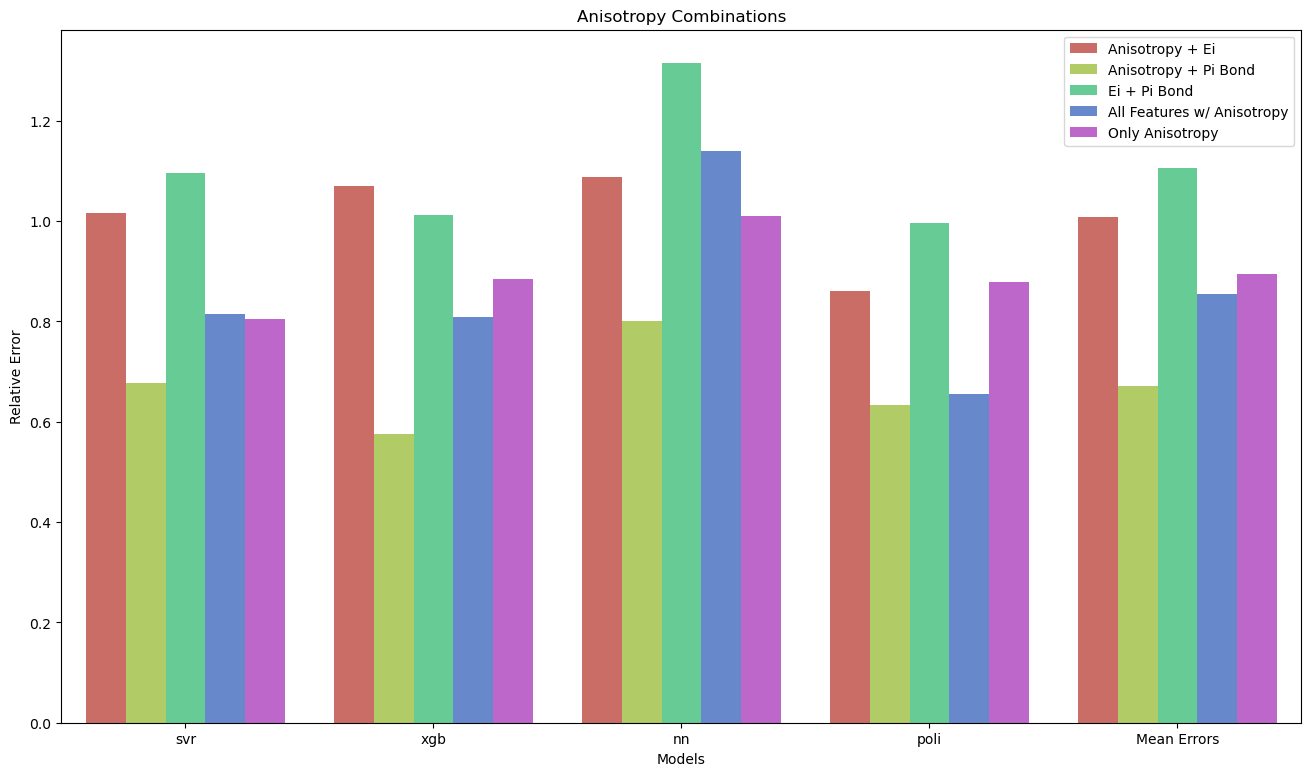

In [322]:
plt.figure(figsize=(16,9))
all_cv_error = cv_scores0 + cv_scores1 + cv_scores2 + all_feat_scores + only_aniso
create_fast_graph(all_cv_error, aux_model=['svr','xgb','nn','poli','Mean Errors'],hue=['Anisotropy + Ei', 
                                                                                       'Anisotropy + Pi Bond', 'Ei + Pi Bond','All Features w/ Anisotropy','Only Anisotropy'], title = 'Anisotropy Combinations')

## Feature Importance

In [ ]:
#Pra fazer feature importance tenho que otimizar cada algoritmo individualmente
#pra cada possibilidade de features utilizadas.

In [24]:
#All features isotropy
features = ['Ei','Alpha', 'pi_bond']
scaler = att_scaler(scaler, features)
estim_all_iso = opt_all(estim_pi,estim_names,x,y,5,spaces_pi, shuffle=True )

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'auto', 3, 2.1267777129688827, 2.753831793129262, 0.26831919749502264, MinMaxScaler(), StandardScaler()]
Cujo score de teste é: 0.668444852256448

Para o estimador xgb, os parâmetros são: [0.01902985846076779, 2000, 1, 2, 0.821696706457828, 0.7657156005966218, 1.0, 0.30381769906309053, 0.7812618436658332]
Cujo score de teste é: 0.3928502413411674

Para o estimador nn, os parâmetros são: ['tanh', 8.760559174820615e-05, 6, 12, 0.5056928322398396, 0.648670015161599, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.5664292035119308

Para o estimador poli, os parâmetros são: [0.44105488826838396, False, False, 10, False, False, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5776288128042285



In [22]:
stk_opt = gp_optimize(stk_lin, x, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.44941e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.61031e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.86315e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.0047e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.0285
Function value obtained: 12.5275
Current minimum: 12.5275
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.7793
Function value obtained: 0.8125
Current minimum: 0.8125
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.9077
Function value obtained: 12.1667
Current minimum: 0.8125
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.1988
Function value obtained: 0.9994
Current minimum: 0.8125
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.5086
Function value obtained: 2.1372
Current minimum: 0.8125
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluatio

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.6781
Function value obtained: 2.8590
Current minimum: 0.8125
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 3.0161
Function value obtained: 0.8579
Current minimum: 0.8125
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.1259
Function value obtained: 1.0329
Current minimum: 0.8125
Iteration No: 10 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.1119e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.6332
Function value obtained: 19.6034
Current minimum: 0.8125
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.4787
Function value obtained: 5.4831
Current minimum: 0.8125
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 5.1286
Function value obtained: 1.5210
Current minimum: 0.8125
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 1.4358
Function value obtained: 1.2078
Current minimum: 0.8125
Iteration No: 14 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 22.0938
Function value obtained: 1.5564
Current minimum: 0.8125
Iteration No: 15 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.10883e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.54291e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.45807e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 2.8634
Function value obtained: 23.3379
Current minimum: 0.8125
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 3.9520
Function value obtained: 3.3443
Current minimum: 0.8125
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.0950
Function value obtained: 3.2432
Current minimum: 0.8125
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.9798
Function value obtained: 0.7711
Current minimum: 0.7711
Iteration No: 19 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.55523e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.40259e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.1889
Function value obtained: 6.3661
Current minimum: 0.7711
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.8938
Function value obtained: 0.9745
Current minimum: 0.7711
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 9.6682
Function value obtained: 0.7666
Current minimum: 0.7666
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.65793e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.12955e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.27917e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.31529e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 3.5741
Function value obtained: 7.3926
Current minimum: 0.7666
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.4732
Function value obtained: 2.6740
Current minimum: 0.7666
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.3388
Function value obtained: 1.0876
Current minimum: 0.7666
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 3.7543
Function value obtained: 1.4851
Current minimum: 0.7666
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 5.8107
Function value obtained: 0.8911
Current minimum: 0.7666
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.11757e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.7591e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in s

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.2105
Function value obtained: 2.6295
Current minimum: 0.7666
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 3.2033
Function value obtained: 2.0466
Current minimum: 0.7666
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.40866e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.22355e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.3131
Function value obtained: 1.2529
Current minimum: 0.7666
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 2.5354
Function value obtained: 2.4455
Current minimum: 0.7666
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.8969
Function value obtained: 0.7634
Current minimum: 0.7634
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.8987
Function value obtained: 0.5870
Current minimum: 0.5870
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 3.3423
Function value obtained: 0.7595
Current minimum: 0.5870
Iteration No: 34 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.35161e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.52109e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.29634e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.40781e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 2.4198
Function value obtained: 2.5606
Current minimum: 0.5870
Iteration No: 35 started. Evaluating function at random point.
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 2.0543
Function value obtained: 6.2552
Current minimum: 0.5870
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 3.0881
Function value obtained: 1.1721
Current minimum: 0.5870
Iteration No: 37 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.1202e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.50982e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.61008e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.35671e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 37 ended. Evaluation done at random point.
Time taken: 1.8330
Function value obtained: 6.3571
Current minimum: 0.5870
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.9887
Function value obtained: 1.3819
Current minimum: 0.5870
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 14.7339
Function value obtained: 1.2408
Current minimum: 0.5870
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 6.7607
Function value obtained: 0.8091
Current minimum: 0.5870
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.11757e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.7591e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned ma

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 11.2923
Function value obtained: 6.2757
Current minimum: 0.5870
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 3.7437
Function value obtained: 2.0675
Current minimum: 0.5870
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 5.0804
Function value obtained: 1.5151
Current minimum: 0.5870
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 6.0822
Function value obtained: 0.5846
Current minimum: 0.5846
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.2448
Function value obtained: 0.4291
Current minimum: 0.4291
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.05292e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.29013e-18): result may not be a

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 4.1500
Function value obtained: 29.9189
Current minimum: 0.4291
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 3.0984
Function value obtained: 2.2931
Current minimum: 0.4291
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.79537e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.9904
Function value obtained: 52.0348
Current minimum: 0.4291
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.74146e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.02649e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.2017e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.35086e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 6.6339
Function value obtained: 8.6818
Current minimum: 0.4291
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 2.9752
Function value obtained: 1.1262
Current minimum: 0.4291
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 5.1014
Function value obtained: 1.2367
Current minimum: 0.4291
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 4.2826
Function value obtained: 1.8294
Current minimum: 0.4291
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 5.1778
Function value obtained: 1.6125
Current minimum: 0.4291
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.65417e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.19298e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.21446e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.13874e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 67 ended. Evaluation done at random point.
Time taken: 1.8959
Function value obtained: 2.0046
Current minimum: 0.4291
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 2.4651
Function value obtained: 2.3087
Current minimum: 0.4291
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.6878
Function value obtained: 2.5647
Current minimum: 0.4291
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 3.1336
Function value obtained: 0.9819
Current minimum: 0.4291
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 7.1855
Function value obtained: 0.6223
Current minimum: 0.4291
Iteration No: 72 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.8311e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.82944e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.65474e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.65653e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 72 ended. Evaluation done at random point.
Time taken: 2.0321
Function value obtained: 1.7242
Current minimum: 0.4291
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 2.4191
Function value obtained: 25.4178
Current minimum: 0.4291
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 1.9827
Function value obtained: 0.6418
Current minimum: 0.4291
Iteration No: 75 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.20188e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10893e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.3255e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.07308e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 75 ended. Evaluation done at random point.
Time taken: 2.0253
Function value obtained: 5.0683
Current minimum: 0.4291
Iteration No: 76 started. Evaluating function at random point.
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 10.5184
Function value obtained: 0.9179
Current minimum: 0.4291
Iteration No: 77 started. Evaluating function at random point.
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 2.7168
Function value obtained: 1.3481
Current minimum: 0.4291
Iteration No: 78 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.96971e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.89766e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.68954e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.18108e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 7.2296
Function value obtained: 8.2290
Current minimum: 0.4291
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.4325
Function value obtained: 1.0894
Current minimum: 0.4291
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 8.9531
Function value obtained: 1.1817
Current minimum: 0.4291
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 5.1026
Function value obtained: 1.7958
Current minimum: 0.4291
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 0.9720
Function value obtained: 1.3631
Current minimum: 0.4291
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.0413e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.08181e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10095e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.02639e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 86 ended. Evaluation done at random point.
Time taken: 2.0542
Function value obtained: 19.3947
Current minimum: 0.4291
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 4.6688
Function value obtained: 2.2320
Current minimum: 0.4291
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 3.5100
Function value obtained: 0.6805
Current minimum: 0.4291
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 3.5406
Function value obtained: 0.8889
Current minimum: 0.4291
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 5.5324
Function value obtained: 0.7577
Current minimum: 0.4291
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.38594e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12971e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.51945e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.45084e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 6.7565
Function value obtained: 8.6876
Current minimum: 0.4291
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 6.0635
Function value obtained: 0.5302
Current minimum: 0.4291
Iteration No: 106 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.1202e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.50982e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.61008e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.35671e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 4.3500
Function value obtained: 7.3754
Current minimum: 0.4291
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 6.3231
Function value obtained: 6.0221
Current minimum: 0.4291
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 6.8019
Function value obtained: 1.1159
Current minimum: 0.4291
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 4.7904
Function value obtained: 0.9261
Current minimum: 0.4291
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 6.0687
Function value obtained: 0.8839
Current minimum: 0.4291
Iteration No: 111 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.11757e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 5.8205
Function value obtained: 8.1160
Current minimum: 0.4291
Iteration No: 120 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.46934e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.52362e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.29676e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 5.7585
Function value obtained: 4.4871
Current minimum: 0.4291
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 22.0582
Function value obtained: 2.2951
Current minimum: 0.4291
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 4.3519
Function value obtained: 4.9029
Current minimum: 0.4291
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 5.9489
Function value obtained: 12.6137
Current minimum: 0.4291
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 5.0424
Function value obtained: 2.2536
Current minimum: 0.4291
Iteration No: 125 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.17754e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.60576e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 8.1043
Function value obtained: 1.7644
Current minimum: 0.4291
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 8.5300
Function value obtained: 1.0637
Current minimum: 0.4291
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 6.4796
Function value obtained: 1.0891
Current minimum: 0.4291
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 4.2260
Function value obtained: 2.7487
Current minimum: 0.4291
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 7.5758
Function value obtained: 1.1998
Current minimum: 0.4291
Iteration No: 131 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.26903e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.17972e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.42504e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2215e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 9.5882
Function value obtained: 1.2170
Current minimum: 0.4291
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 7.2712
Function value obtained: 1.6339
Current minimum: 0.4291
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 7.1487
Function value obtained: 2.1123
Current minimum: 0.4291
Iteration No: 137 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.80409e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.69989e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 6.9931
Function value obtained: 1.7350
Current minimum: 0.4291
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 7.6523
Function value obtained: 1.0450
Current minimum: 0.4291
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 10.8803
Function value obtained: 1.1612
Current minimum: 0.4291
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 7.1950
Function value obtained: 8.1013
Current minimum: 0.4291
Iteration No: 141 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.11757e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.7591e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in s

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 7.2552
Function value obtained: 2.3847
Current minimum: 0.4291
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 7.3070
Function value obtained: 1.3724
Current minimum: 0.4291
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 6.5754
Function value obtained: 14.6679
Current minimum: 0.4291
Iteration No: 144 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.07993e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.0713e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.96876e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.54788e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 7.5684
Function value obtained: 7.6689
Current minimum: 0.4291
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 4.7761
Function value obtained: 3.9413
Current minimum: 0.4291
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 8.2149
Function value obtained: 1.5751
Current minimum: 0.4291
Iteration No: 147 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.71713e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.12417e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.96985e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 8.1176
Function value obtained: 3.3400
Current minimum: 0.4291
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 7.1057
Function value obtained: 1.1655
Current minimum: 0.4291
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 5.6136
Function value obtained: 3.3053
Current minimum: 0.4291
Iteration No: 150 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.07439e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.08714e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.8804e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.69511e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 5.3855
Function value obtained: 1.2576
Current minimum: 0.4291


In [23]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.001642159855124113, 3, 'rbf', 'scale', 0.38028300162498324, 0.00941471294000514, 552, 9, 0.23128313865516903, 'relu', 0.0006255279710627108, 8, 18]
Valor de função:  0.4291080123163096


In [60]:
features = ['Ei','Alpha', 'pi_bond']
scaler = att_scaler(scaler, features)

stk0_params = [0.001642159855124113, 3, 'rbf', 'scale', 0.38028300162498324, 0.00941471294000514, 552, 9, 
 0.23128313865516903, 'relu', 0.0006255279710627108, 8, 18]

att_model(stk_lin, space_stk_lin, stk0_params, neural=True, stacked=True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge0 = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge0_params = [0.44105488826838396, False, False, 10, False, False, MinMaxScaler(), MinMaxScaler()]
att_model(ridge0, space_pi_poli, ridge0_params)

pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr0 = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr0_params=['rbf', 'auto', 3, 2.1267777129688827, 2.753831793129262, 0.26831919749502264, MinMaxScaler(), StandardScaler()]
att_model(svr0, space_pi_svr, svr0_params)

xgb0 = XGBRegressor(random_state=0)
xgb0_params = [0.01902985846076779, 2000, 1, 2, 0.821696706457828, 0.7657156005966218, 1.0, 0.30381769906309053, 0.7812618436658332]
att_model(xgb0, space_pi_xgb, xgb0_params)

pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn0 = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn0_params = ['tanh', 8.760559174820615e-05, 6, 12, 0.5056928322398396, 0.648670015161599, MinMaxScaler(), RobustScaler()]
att_model(nn0, space_pi_nn,nn0_params,neural=True)

estim_list0 = [svr0,xgb0,nn0, ridge0, stk_lin]

In [61]:
pickle.dump(estim_list0, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_iso_x.sav', 'wb'))

In [25]:
#All features anisotropy
features = ['Ei','axx','ayy','azz', 'pi_bond']
scaler = att_scaler(scaler, features)
estim_all_aniso = opt_all(estim_pi,estim_names,x_alpha,y,5,spaces_pi, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'auto', 4, 10.0, 4.12629176972727, 0.22979410270824313, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.7299142750440366

Para o estimador xgb, os parâmetros são: [0.02341064403187755, 2000, 8, 2, 4.867820742745614, 0.5405336411852726, 0.1, 0.36663390817453567, 0.26617577363149697]
Cujo score de teste é: 0.4333832645841662

Para o estimador nn, os parâmetros são: ['relu', 0.0005053328653584299, 3, 6, 0.5, 0.8855152749648642, StandardScaler(), StandardScaler()]
Cujo score de teste é: 0.578268102375841

Para o estimador poli, os parâmetros são: [0.3418358852249387, False, False, 1, True, False, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5704631580765787



In [31]:
stk_opt = gp_optimize(stk_lin, x_alpha, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.24693e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.70026e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.57684e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.91852e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.8403
Function value obtained: 8.9593
Current minimum: 8.9593
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.6184
Function value obtained: 0.6092
Current minimum: 0.6092
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.6960
Function value obtained: 7.3425
Current minimum: 0.6092
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6029
Function value obtained: 3.4853
Current minimum: 0.6092
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.2410
Function value obtained: 2.1626
Current minimum: 0.6092
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation d

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.79644e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.96457e-19): result may not be a

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.4629
Function value obtained: 35.5330
Current minimum: 0.6092
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.2771
Function value obtained: 2.0783
Current minimum: 0.6092
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.5527
Function value obtained: 1.4367
Current minimum: 0.6092
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 3.0010
Function value obtained: 0.7346
Current minimum: 0.6092
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 17.8566
Function value obtained: 1.4214
Current minimum: 0.6092
Iteration No: 15 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.16483e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.57031e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.43322e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.56566e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.0908
Function value obtained: 22.4757
Current minimum: 0.6092
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 3.4705
Function value obtained: 3.8243
Current minimum: 0.6092
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 5.7328
Function value obtained: 3.0466
Current minimum: 0.6092
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.3700
Function value obtained: 0.8169
Current minimum: 0.6092
Iteration No: 19 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.42725e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.67955e-18): result may not be a

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.2266
Function value obtained: 7.1454
Current minimum: 0.6092
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 6.4206
Function value obtained: 0.9273
Current minimum: 0.6092
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 2.1192
Function value obtained: 0.3937
Current minimum: 0.3937
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2179e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.31555e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.91465e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_r

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 3.5953
Function value obtained: 7.4075
Current minimum: 0.3937
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 5.1993
Function value obtained: 2.6326
Current minimum: 0.3937
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.8648
Function value obtained: 1.0603
Current minimum: 0.3937
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 3.8638
Function value obtained: 1.9476
Current minimum: 0.3937
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 6.9037
Function value obtained: 1.3295
Current minimum: 0.3937
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.18838e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.66273e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.45711e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 4.0368
Function value obtained: 15.9514
Current minimum: 0.3937
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 3.3098
Function value obtained: 0.8310
Current minimum: 0.3937
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.481e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.83185e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned mat

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.4317
Function value obtained: 5.6491
Current minimum: 0.3937
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.4338
Function value obtained: 1.8845
Current minimum: 0.3937
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.7099
Function value obtained: 0.8598
Current minimum: 0.3937
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.3930
Function value obtained: 1.0242
Current minimum: 0.3937
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.7310
Function value obtained: 0.5656
Current minimum: 0.3937
Iteration No: 34 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.88276e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.00293e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.79948e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.82395e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 1.8909
Function value obtained: 2.6517
Current minimum: 0.3937
Iteration No: 35 started. Evaluating function at random point.
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 1.9437
Function value obtained: 5.7305
Current minimum: 0.3937
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 2.6304
Function value obtained: 1.2030
Current minimum: 0.3937
Iteration No: 37 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.91488e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.43091e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.12037e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.98612e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 37 ended. Evaluation done at random point.
Time taken: 1.3078
Function value obtained: 6.7119
Current minimum: 0.3937
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 2.3833
Function value obtained: 1.2273
Current minimum: 0.3937
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 8.9038
Function value obtained: 1.1394
Current minimum: 0.3937
Iteration No: 40 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 40 ended. Evaluation done at random point.
Time taken: 21.9798
Function value obtained: 0.7211
Current minimum: 0.3937
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.76548e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.45711e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.28431e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 4.4295
Function value obtained: 11.2841
Current minimum: 0.3937
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 3.6546
Function value obtained: 1.5638
Current minimum: 0.3937
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.4549
Function value obtained: 1.5186
Current minimum: 0.3937
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 5.8129
Function value obtained: 0.5518
Current minimum: 0.3937
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.1327
Function value obtained: 0.6991
Current minimum: 0.3937
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.79644e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 4.0285
Function value obtained: 17.7465
Current minimum: 0.3937
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 20.3432
Function value obtained: 1.6869
Current minimum: 0.3937
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.16414e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.55676e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 3.6524
Function value obtained: 40.0477
Current minimum: 0.3937
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.68198e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyt

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 8.4533
Function value obtained: 5.2457
Current minimum: 0.3937
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.3257
Function value obtained: 1.7364
Current minimum: 0.3937
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 5.3932
Function value obtained: 1.4931
Current minimum: 0.3937
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 4.0685
Function value obtained: 0.8922
Current minimum: 0.3937
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 7.2119
Function value obtained: 9.4192
Current minimum: 0.3937
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.3986e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.18046e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.98363e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.82902e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 67 ended. Evaluation done at random point.
Time taken: 1.9291
Function value obtained: 4.2564
Current minimum: 0.3937
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 1.2505
Function value obtained: 2.1857
Current minimum: 0.3937
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 1.2647
Function value obtained: 2.5901
Current minimum: 0.3937
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 4.3799
Function value obtained: 1.1665
Current minimum: 0.3937
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 4.2662
Function value obtained: 1.6398
Current minimum: 0.3937
Iteration No: 72 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.61531e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.95013e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.95291e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.72873e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 72 ended. Evaluation done at random point.
Time taken: 2.2271
Function value obtained: 2.9161
Current minimum: 0.3937
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 2.8807
Function value obtained: 6.0110
Current minimum: 0.3937
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 1.9460
Function value obtained: 1.0324
Current minimum: 0.3937
Iteration No: 75 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.80371e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.57515e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.93056e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.16559e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 75 ended. Evaluation done at random point.
Time taken: 2.3384
Function value obtained: 7.0353
Current minimum: 0.3937
Iteration No: 76 started. Evaluating function at random point.
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 4.4229
Function value obtained: 1.0048
Current minimum: 0.3937
Iteration No: 77 started. Evaluating function at random point.
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 4.1498
Function value obtained: 2.1733
Current minimum: 0.3937
Iteration No: 78 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.31759e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.32804e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 3.9567
Function value obtained: 11.1431
Current minimum: 0.3937
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.5908
Function value obtained: 1.0470
Current minimum: 0.3937
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 5.8154
Function value obtained: 1.8432
Current minimum: 0.3937
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 1.7274
Function value obtained: 1.5516
Current minimum: 0.3937
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 1.8803
Function value obtained: 1.5373
Current minimum: 0.3937
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.22197e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.76436e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.09833e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.90475e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 86 ended. Evaluation done at random point.
Time taken: 6.6418
Function value obtained: 9.4765
Current minimum: 0.3937
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 3.4860
Function value obtained: 1.0972
Current minimum: 0.3937
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 4.7048
Function value obtained: 1.4061
Current minimum: 0.3937
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 5.1587
Function value obtained: 1.2617
Current minimum: 0.3937
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 3.9989
Function value obtained: 0.8262
Current minimum: 0.3937
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.39333e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.00803e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.96039e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.50572e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 5.9909
Function value obtained: 2.1082
Current minimum: 0.3937
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 6.6184
Function value obtained: 0.5093
Current minimum: 0.3937
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 6.3430
Function value obtained: 2.5337
Current minimum: 0.3937
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 6.5286
Function value obtained: 8.3057
Current minimum: 0.3937
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 6.9018
Function value obtained: 1.1391
Current minimum: 0.3937
Iteration No: 130 st

In [32]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.5097019855148801, 2, 'poly', 'auto', 0.17161370272480006, 0.2, 100, 7, 0.48248945680959543, 'relu', 0.00035057336715841475, 3, 4]
Valor de função:  0.34494611259407454


In [63]:
features = ['Ei','axx','ayy','azz', 'pi_bond']
scaler = att_scaler(scaler, features)

params_stk = [0.5097019855148801, 2, 'poly', 'auto', 0.17161370272480006, 0.2, 100, 7, 0.48248945680959543, 'relu', 0.00035057336715841475, 3, 4]
att_model(stk_lin, space_stk_lin, params_stk, neural=True, stacked=True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge01 = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge01_params = [0.3418358852249387, False, False, 1, True, False, MinMaxScaler(), MinMaxScaler()]
att_model(ridge01, space_pi_poli, ridge01_params)

pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr01 = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr01_params = ['rbf', 'auto', 4, 10.0, 4.12629176972727, 0.22979410270824313, MinMaxScaler(), RobustScaler()]
att_model(svr01, space_pi_svr, svr01_params)

xgb01 = XGBRegressor(random_state=0)
xgb01_params = [0.02341064403187755, 2000, 8, 2, 4.867820742745614, 0.5405336411852726, 0.1, 0.36663390817453567, 0.26617577363149697]
att_model(xgb01, space_pi_xgb, xgb01_params)

pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn01 = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn01_params = ['relu', 0.0005053328653584299, 3, 6, 0.5, 0.8855152749648642, StandardScaler(), StandardScaler()]
att_model(nn01, space_pi_nn, nn01_params, neural=True)

estim_list01 = [svr01,xgb01,nn01, ridge01, stk_lin]

In [64]:
pickle.dump(estim_list01, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_aniso_x_alpha.sav', 'wb'))

In [30]:
#For x0
estim_x0 = opt_all(estim,estim_names,x0,y,5,spaces, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['poly', 'auto', 1, 8.926952549812876, 0.2536558170926532, 0.11053057241463789, StandardScaler(), RobustScaler()]
Cujo score de teste é: 0.6503873210851081

Para o estimador xgb, os parâmetros são: [0.13503613919814744, 2000, 15, 1, 5.629068114783932, 0.7459529850215744, 0.1, 0.6428082010798158, 0.0]
Cujo score de teste é: 0.4615674749861102

Para o estimador nn, os parâmetros são: ['tanh', 1.615475139349842e-05, 2, 20, 0.6792571327728232, 0.8750540901350461, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5853368682015223

Para o estimador poli, os parâmetros são: [100.0, False, False, 8, False, True, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5036031678775972



In [38]:
stk_opt = gp_optimize(stk_lin, x0, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.1888
Function value obtained: 1.7319
Current minimum: 1.7319
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.5168
Function value obtained: 1.3250
Current minimum: 1.3250
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3319
Function value obtained: 2.4543
Current minimum: 1.3250
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.4254
Function value obtained: 1.5442
Current minimum: 1.3250
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.3698
Function value obtained: 0.9572
Current minimum: 0.9572
Iteration No: 6 started. Evaluating

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 21.7874
Function value obtained: 1.5344
Current minimum: 0.9572
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.9491
Function value obtained: 8.3096
Current minimum: 0.9572
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 4.7362
Function value obtained: 1.1849
Current minimum: 0.9572
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.9188
Function value obtained: 1.3040
Current minimum: 0.9572
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.7903
Function value obtained: 1.3036
Current minimum: 0.9572
Iteration No: 19 started. Evaluating function at random point.
Iteration No: 19 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.50789e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.00362e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.85674e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.98918e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 4.4805
Function value obtained: 1.2101
Current minimum: 0.7217
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 3.0676
Function value obtained: 1.3098
Current minimum: 0.7217
Iteration No: 29 started. Evaluating function at random point.
Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.7662
Function value obtained: 3.5256
Current minimum: 0.7217
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 2.7353
Function value obtained: 1.2732
Current minimum: 0.7217
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.2278
Function value obtained: 1.0656
Current minimum: 0.7217
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.81028e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.19539e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.23155e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 4.3809
Function value obtained: 1.8703
Current minimum: 0.7217
Iteration No: 48 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 48 ended. Evaluation done at random point.
Time taken: 19.5887
Function value obtained: 1.3586
Current minimum: 0.7217
Iteration No: 49 started. Evaluating function at random point.
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 3.2538
Function value obtained: 1.7177
Current minimum: 0.7217
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 4.9279
Function value obtained: 1.0400
Current minimum: 0.7217
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.5118
Function value obtained: 1.6079
Current minimum: 0.7217
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 3.7308
Function value obtained: 1.5144
Current minimum: 0.7217
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 20.9369
Function value obtained: 1.0171
Current minimum: 0.7217
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 9.3615
Function value obtained: 0.6920
Current minimum: 0.6920
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 7.9471
Function value obtained: 1.3030
Current minimum: 0.6920


In [39]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [100.0, 5, 'sigmoid', 'scale', 0.1, 0.00010872880216226332, 1821, 15, 1.0, 'relu', 0.0006228259817356844, 1, 20]
Valor de função:  0.6919651765247543


In [65]:
stk_params = [100.0, 5, 'sigmoid', 'scale', 0.1, 0.00010872880216226332, 1821, 15, 1.0, 'relu', 0.0006228259817356844, 1, 20]
att_model(stk_lin, space_stk_lin, stk_params, neural=True, stacked=True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scaling', MinMaxScaler()),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge04 = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge04_params = [100.0, False, False, 8, False, True, MinMaxScaler(), MinMaxScaler()]
att_model(ridge04, space_poli, ridge04_params)

pipe = Pipeline([('scale',StandardScaler()), ('reg',SVR(max_iter=10000))])
svr04 = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr04_params=['poly', 'auto', 1, 8.926952549812876, 0.2536558170926532, 0.11053057241463789, StandardScaler(), RobustScaler()]
att_model(svr04, space_svr, svr04_params)

xgb04 = XGBRegressor(random_state=0)
xgb04_params = [0.13503613919814744, 2000, 15, 1, 5.629068114783932, 0.7459529850215744, 0.1, 0.6428082010798158, 0.0]
att_model(xgb04, space_xgb, xgb04_params)

pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn04 = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn04_params = ['tanh', 1.615475139349842e-05, 2, 20, 0.6792571327728232, 0.8750540901350461, MinMaxScaler(), MinMaxScaler()]
att_model(nn04, space_nn,nn04_params,neural=True)

estim_list04 = [svr04,xgb04,nn04, ridge04, stk_lin]

In [66]:
pickle.dump(estim_list04, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_aniso_x0.sav', 'wb'))

In [31]:
#For x1
features = ['axx','ayy','azz','pi_bond']
scaler=att_scaler(scaler, features)
estim_x1 = opt_all(estim_pi,estim_names,x1,y,5,spaces_pi, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'scale', 10, 0.80556356314543, 3.5461496920187416, 0.03310100222994736, StandardScaler(), RobustScaler()]
Cujo score de teste é: 0.47344913093549856

Para o estimador xgb, os parâmetros são: [0.030610984196617678, 1106, 1, 2, 4.9511399541416505, 0.6947954697144164, 0.1, 0.45358934845050625, 1.0]
Cujo score de teste é: 0.306324069209967

Para o estimador nn, os parâmetros são: ['relu', 0.0007968258085188755, 4, 18, 0.6319742603484855, 0.8556933286924002, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5308440814334018

Para o estimador poli, os parâmetros são: [1.7764727893242926, False, True, 7, True, True, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.49542073503913764



In [42]:
stk_opt = gp_optimize(stk_lin, x1, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.2813e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.59239e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.50786e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.35595e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.3180
Function value obtained: 23.9030
Current minimum: 23.9030
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.0472
Function value obtained: 2.2049
Current minimum: 2.2049
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3709
Function value obtained: 5.2830
Current minimum: 2.2049
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.3558
Function value obtained: 5.3102
Current minimum: 2.2049
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.2211
Function value obtained: 4.3449
Current minimum: 2.2049
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.76234e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96479e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.8226
Function value obtained: 52.6253
Current minimum: 0.8048
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 3.0626
Function value obtained: 27.5134
Current minimum: 0.8048
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.6642
Function value obtained: 2.4675
Current minimum: 0.8048
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 1.6609
Function value obtained: 0.9116
Current minimum: 0.8048
Iteration No: 14 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 21.1673
Function value obtained: 2.0095
Current minimum: 0.8048
Iteration No: 15 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.28443e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.14022e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.19159e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.14715e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.7859
Function value obtained: 16.5910
Current minimum: 0.8048
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 4.5321
Function value obtained: 1.1574
Current minimum: 0.8048
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.8187
Function value obtained: 3.7182
Current minimum: 0.8048
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 3.9478
Function value obtained: 0.8052
Current minimum: 0.8048
Iteration No: 19 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.50762e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.69465e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.15357e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.31305e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.3349
Function value obtained: 1.7223
Current minimum: 0.8048
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 4.2412
Function value obtained: 0.4072
Current minimum: 0.4072
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 4.3425
Function value obtained: 0.6848
Current minimum: 0.4072
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.45468e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.07942e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.60188e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.59002e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 3.5638
Function value obtained: 30.4369
Current minimum: 0.4072
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.2024
Function value obtained: 1.8137
Current minimum: 0.4072
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.5021
Function value obtained: 1.5866
Current minimum: 0.4072
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 4.7221
Function value obtained: 7.2097
Current minimum: 0.4072
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 9.7444
Function value obtained: 0.7195
Current minimum: 0.4072
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.73505e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.90761e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.59597e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.6275
Function value obtained: 16.6990
Current minimum: 0.4072
Iteration No: 28 started. Evaluating function at random point.
Iteration No: 28 ended. Evaluation done at random point.
Time taken: 1.3691
Function value obtained: 3.6632
Current minimum: 0.4072
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.69314e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.68911e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.61472e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.84836e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 4.1610
Function value obtained: 18.0829
Current minimum: 0.4072
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 2.6527
Function value obtained: 6.1050
Current minimum: 0.4072
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.0599
Function value obtained: 1.1520
Current minimum: 0.4072
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.4412
Function value obtained: 0.5324
Current minimum: 0.4072
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.4979
Function value obtained: 0.7427
Current minimum: 0.4072
Iteration No: 34 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.05364e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.83681e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.28727e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.55696e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 1.8447
Function value obtained: 2.4958
Current minimum: 0.4072
Iteration No: 35 started. Evaluating function at random point.
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 2.6045
Function value obtained: 2.3703
Current minimum: 0.4072
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 2.9784
Function value obtained: 1.0945
Current minimum: 0.4072
Iteration No: 37 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.73423e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.75601e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.01287e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.7087e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 37 ended. Evaluation done at random point.
Time taken: 1.7072
Function value obtained: 8.8354
Current minimum: 0.4072
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.7338
Function value obtained: 2.5710
Current minimum: 0.4072
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 9.1450
Function value obtained: 1.4353
Current minimum: 0.4072
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 4.8935
Function value obtained: 2.9368
Current minimum: 0.4072
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.71653e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.03028e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.42588e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 2.1320
Function value obtained: 14.7408
Current minimum: 0.4072
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 3.8039
Function value obtained: 1.2515
Current minimum: 0.4072
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.5453
Function value obtained: 1.4894
Current minimum: 0.4072
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 3.8649
Function value obtained: 2.8863
Current minimum: 0.4072
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.6565
Function value obtained: 0.8549
Current minimum: 0.4072
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96479e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 4.2403
Function value obtained: 98.0632
Current minimum: 0.4072
Iteration No: 48 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 48 ended. Evaluation done at random point.
Time taken: 24.4894
Function value obtained: 1.2681
Current minimum: 0.4072
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.10744e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.37312e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.00104e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.7727
Function value obtained: 88.4944
Current minimum: 0.4072
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.54852e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.28155e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.85936e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.65434e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 5.2227
Function value obtained: 27.3662
Current minimum: 0.4072
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.1094
Function value obtained: 1.5520
Current minimum: 0.4072
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 4.1361
Function value obtained: 1.1844
Current minimum: 0.4072
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 3.8769
Function value obtained: 0.5991
Current minimum: 0.4072
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 5.0803
Function value obtained: 20.6954
Current minimum: 0.4072
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended.

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.06275e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.04043e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.03539e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.07786e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 67 ended. Evaluation done at random point.
Time taken: 2.7603
Function value obtained: 6.4637
Current minimum: 0.4072
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 2.5315
Function value obtained: 5.0917
Current minimum: 0.4072
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 1.2406
Function value obtained: 6.5372
Current minimum: 0.4072
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 5.7884
Function value obtained: 0.9809
Current minimum: 0.4072
Iteration No: 71 started. Evaluating function at random point.
Iteration No: 71 ended. Evaluation done at random point.
Time taken: 1.8044
Function value obtained: 2.2502
Current minimum: 0.4072
Iteration No: 72 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.71299e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.77344e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.23081e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.44132e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 72 ended. Evaluation done at random point.
Time taken: 10.9787
Function value obtained: 4.4446
Current minimum: 0.4072
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 3.0488
Function value obtained: 73.8189
Current minimum: 0.4072
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 2.5176
Function value obtained: 1.1750
Current minimum: 0.4072
Iteration No: 75 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.79137e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2742e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.25636e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.95646e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 75 ended. Evaluation done at random point.
Time taken: 3.1105
Function value obtained: 32.8008
Current minimum: 0.4072
Iteration No: 76 started. Evaluating function at random point.
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 4.3487
Function value obtained: 0.5336
Current minimum: 0.4072
Iteration No: 77 started. Evaluating function at random point.
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 3.8711
Function value obtained: 1.6789
Current minimum: 0.4072
Iteration No: 78 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.66984e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.31202e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 12.2083
Function value obtained: 6.9575
Current minimum: 0.4072
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.2299
Function value obtained: 0.8250
Current minimum: 0.4072
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 3.3865
Function value obtained: 1.3523
Current minimum: 0.4072
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 4.3364
Function value obtained: 2.6132
Current minimum: 0.4072
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 8.9178
Function value obtained: 2.1338
Current minimum: 0.4072
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.08281e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.70331e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.85928e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 5.9149
Function value obtained: 8.3955
Current minimum: 0.4072
Iteration No: 103 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.69641e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.55094e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.89642e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.83812e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 6.2258
Function value obtained: 8.7485
Current minimum: 0.4072
Iteration No: 104 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2708e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.1961e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/py

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 5.5841
Function value obtained: 7.3761
Current minimum: 0.4072
Iteration No: 105 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.50442e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.78709e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 7.3808
Function value obtained: 25.3633
Current minimum: 0.4072
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 8.9265
Function value obtained: 0.6498
Current minimum: 0.4072
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 4.6859
Function value obtained: 8.2423
Current minimum: 0.4072
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 5.3441
Function value obtained: 11.5338
Current minimum: 0.4072
Iteration No: 109 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2708e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.1961e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/py

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 6.7343
Function value obtained: 3.7955
Current minimum: 0.4072
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 11.8294
Function value obtained: 2.0865
Current minimum: 0.4072
Iteration No: 111 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96479e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in s

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 11.9946
Function value obtained: 43.0043
Current minimum: 0.4072
Iteration No: 112 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.76559e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.59895e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.38155e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.0018e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 9.8081
Function value obtained: 7.3346
Current minimum: 0.4072
Iteration No: 113 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.96479e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.49738e-18): result may not be a

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 6.5023
Function value obtained: 19.2512
Current minimum: 0.4072
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 4.9607
Function value obtained: 7.6855
Current minimum: 0.4072
Iteration No: 115 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.25443e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.27982e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.64922e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.40928e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 6.6842
Function value obtained: 5.7351
Current minimum: 0.4072
Iteration No: 116 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10845e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.15489e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.93101e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 5.3233
Function value obtained: 17.6877
Current minimum: 0.4072
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 7.7090
Function value obtained: 0.8264
Current minimum: 0.4072
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 5.0068
Function value obtained: 1.1208
Current minimum: 0.4072
Iteration No: 119 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.42922e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.06461e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in 

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 9.6903
Function value obtained: 19.7228
Current minimum: 0.4072
Iteration No: 120 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 11.6536
Function value obtained: 0.6171
Current minimum: 0.4072
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 5.6205
Function value obtained: 1.0864
Current minimum: 0.4072
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 16.9875
Function value obtained: 3.0029
Current minimum: 0.4072
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 6.8485
Function value obtained: 1.4194
Current minimum: 0.4072
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 7.1506
Function value obtained: 0.6012
Current minimum: 0.4072
Iteration No: 125 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.61207e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.07035e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.11827e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 5.3510
Function value obtained: 5.2356
Current minimum: 0.4072
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 8.9242
Function value obtained: 0.6801
Current minimum: 0.4072
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 7.2515
Function value obtained: 0.5838
Current minimum: 0.4072
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 8.0504
Function value obtained: 0.5578
Current minimum: 0.4072
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 7.8845
Function value obtained: 0.6786
Current minimum: 0.4072
Iteration No: 139 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 10.9667
Function value obtained: 15.3917
Current minimum: 0.4072
Iteration No: 141 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 8.2886
Function value obtained: 6.6807
Current minimum: 0.4072
Iteration No: 142 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2708e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.1961e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/py

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 6.2118
Function value obtained: 4.7114
Current minimum: 0.4072
Iteration No: 143 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.81296e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.99121e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.2708e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_r

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 11.2267
Function value obtained: 1.5981
Current minimum: 0.4072
Iteration No: 144 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.78907e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.38592e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.16893e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.41343e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 9.7681
Function value obtained: 6.6632
Current minimum: 0.4072
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 7.3749
Function value obtained: 0.8795
Current minimum: 0.4072
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 7.8789
Function value obtained: 0.8932
Current minimum: 0.4072
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 9.4425
Function value obtained: 0.5754
Current minimum: 0.4072
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 4.4947
Function value obtained: 1.3745
Current minimum: 0.4072
Iteration No: 149 st

In [43]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.00027168166820236027, 2, 'poly', 'scale', 0.10726374725204586, 0.029231452342630335, 276, 4, 0.7743289753569158, 'relu', 4.5614637150886434e-05, 5, 6]
Valor de função:  0.40723497462808933


In [67]:
features = ['axx','ayy','azz','pi_bond']
scaler=att_scaler(scaler, features)

stk_params = [0.00027168166820236027, 2, 'poly', 'scale', 0.10726374725204586, 0.029231452342630335, 276, 4, 0.7743289753569158, 'relu', 4.5614637150886434e-05, 5, 6]
att_model(stk_lin, space_stk_lin, stk_params, neural=True, stacked=True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge05 = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge05_params = [1.7764727893242926, False, True, 7, True, True, MinMaxScaler(), MinMaxScaler()]
att_model(ridge05, space_pi_poli, ridge05_params)

pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr05 = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr05_params = ['rbf', 'scale', 10, 0.80556356314543, 3.5461496920187416, 0.03310100222994736, StandardScaler(), RobustScaler()]
att_model(svr05, space_pi_svr, svr05_params)

xgb05 = XGBRegressor(random_state=0)
xgb05_params = [0.030610984196617678, 1106, 1, 2, 4.9511399541416505, 0.6947954697144164, 0.1, 0.45358934845050625, 1.0]
att_model(xgb05, space_pi_xgb, xgb05_params)

pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn05 = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn05_params = ['relu', 0.0007968258085188755, 4, 18, 0.6319742603484855, 0.8556933286924002, MinMaxScaler(), MinMaxScaler()]
att_model(nn05, space_pi_nn, nn05_params, neural=True)

estim_list05 = [svr05,xgb05,nn05, ridge05, stk_lin]

In [68]:
pickle.dump(estim_list05, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_aniso_x1.sav', 'wb'))

In [32]:
#For x2
features = ['Ei','pi_bond']
scaler=att_scaler(scaler, features)
estim_x2 = opt_all(estim_pi,estim_names,x2,y,5,spaces_pi, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'scale', 3, 10.0, 5.0, 0.01, MinMaxScaler(), StandardScaler()]
Cujo score de teste é: 1.095782003396645

Para o estimador xgb, os parâmetros são: [0.00012471962102619113, 1781, 7, 5, 5.14862565792158, 0.5575657278013979, 0.8164257640155681, 0.17527034684322967, 1.0]
Cujo score de teste é: 0.6839402805071646

Para o estimador nn, os parâmetros são: ['relu', 1e-06, 15, 20, 0.5562617300956849, 0.6584487255598425, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.7206129208598815

Para o estimador poli, os parâmetros são: [54.18870269863904, False, False, 8, False, False, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.6848785111156694



In [46]:
stk_opt = gp_optimize(stk_lin, x2, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.29192e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.35628e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.17528e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.59483e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.6752
Function value obtained: 7.2766
Current minimum: 7.2766
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.7985
Function value obtained: 1.4015
Current minimum: 1.4015
Iteration No: 3 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0721
Function value obtained: 1.4902
Current minimum: 1.4015
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.1558
Function value obtained: 2.7897
Current minimum: 1.4015
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.5550
Function value obtained: 2.0628
Current minimum: 1.4015
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.5054
Function value obtained: 1.4936
Current minimum: 1.4015
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 5.3856
Function value obtained: 4.3163
Current minimum: 1.4015
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation d

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.38695e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.3418
Function value obtained: 17.3345
Current minimum: 1.0907
Iteration No: 11 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.4960
Function value obtained: 9.7135
Current minimum: 1.0907
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 6.1606
Function value obtained: 2.3523
Current minimum: 1.0907
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.7749
Function value obtained: 1.3647
Current minimum: 1.0907
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 14.0060
Function value obtained: 1.7277
Current minimum: 1.0907
Iteration No: 15 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.12885e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.7136e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.91876e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.0832e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/py

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.0362
Function value obtained: 27.8716
Current minimum: 1.0907
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 4.7819
Function value obtained: 2.9484
Current minimum: 1.0907
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 4.3035
Function value obtained: 2.6383
Current minimum: 1.0907
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.9970
Function value obtained: 1.9553
Current minimum: 1.0907
Iteration No: 19 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.28699e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.70156e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.3145e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_r

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.0625
Function value obtained: 7.7101
Current minimum: 1.0907
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 5.2797
Function value obtained: 0.8871
Current minimum: 0.8871
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 7.1923
Function value obtained: 1.1211
Current minimum: 0.8871
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.56481e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.33658e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.47397e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.40665e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 4.7751
Function value obtained: 7.5792
Current minimum: 0.8871
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 4.8522
Function value obtained: 2.6294
Current minimum: 0.8871
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.4454
Function value obtained: 1.4310
Current minimum: 0.8871
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 4.8372
Function value obtained: 2.6418
Current minimum: 0.8871
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 7.9652
Function value obtained: 1.7048
Current minimum: 0.8871
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.99923e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 5.4767
Function value obtained: 33.5017
Current minimum: 0.8871
Iteration No: 28 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 28 ended. Evaluation done at random point.
Time taken: 3.1464
Function value obtained: 5.0082
Current minimum: 0.8871
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.00991e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.05341e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.32499e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 4.0717
Function value obtained: 3.3653
Current minimum: 0.8871
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.1369
Function value obtained: 2.1556
Current minimum: 0.8871
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 4.1485
Function value obtained: 1.5224
Current minimum: 0.8871
Iteration No: 32 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.6558
Function value obtained: 1.0161
Current minimum: 0.8871
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 3.4957
Function value obtained: 1.4778
Current minimum: 0.8871
Iteration No: 34 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.31607e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.63637e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.63512e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.55044e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 2.0629
Function value obtained: 3.7880
Current minimum: 0.8871
Iteration No: 35 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.87257e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.95845e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.16318e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.20754e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 35 ended. Evaluation done at random point.
Time taken: 2.3936
Function value obtained: 3.4210
Current minimum: 0.8871
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 3.2563
Function value obtained: 1.4632
Current minimum: 0.8871
Iteration No: 37 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.81668e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.027e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.6541e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.91628e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/pyt

Iteration No: 37 ended. Evaluation done at random point.
Time taken: 2.4814
Function value obtained: 2.9771
Current minimum: 0.8871
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.5928
Function value obtained: 1.6332
Current minimum: 0.8871
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 2.0782
Function value obtained: 1.5866
Current minimum: 0.8871
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 7.9983
Function value obtained: 1.1166
Current minimum: 0.8871
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.17121e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 14.1032
Function value obtained: 15.1321
Current minimum: 0.8871
Iteration No: 42 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 42 ended. Evaluation done at random point.
Time taken: 3.6128
Function value obtained: 3.0348
Current minimum: 0.8871
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 5.1162
Function value obtained: 2.8015
Current minimum: 0.8871
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 6.6801
Function value obtained: 1.2522
Current minimum: 0.8871
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 3.1124
Function value obtained: 1.4468
Current minimum: 0.8871
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 3.6245
Function value obtained: 1.2569
Current minimum: 0.8871
Iteration No: 47 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 1.5150
Function value obtained: 12.1355
Current minimum: 0.8871
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 13.6805
Function value obtained: 1.6861
Current minimum: 0.8871
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.16593e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.71165e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: U

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.2322
Function value obtained: 2.7289
Current minimum: 0.8871
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.6088e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.70524e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.37442e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.66346e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 6.2000
Function value obtained: 2.0695
Current minimum: 0.8871
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 5.0255
Function value obtained: 1.5165
Current minimum: 0.8871
Iteration No: 52 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 52 ended. Evaluation done at random point.
Time taken: 5.7559
Function value obtained: 1.0956
Current minimum: 0.8871
Iteration No: 53 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 53 ended. Evaluation done at random point.
Time taken: 7.2651
Function value obtained: 1.3436
Current minimum: 0.8871
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 6.3826
Function value obtained: 18.3817
Current minimum: 0.8871
Iteration No: 55 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 55 ended. Evaluation done at random point.
Time taken: 1.2156
Function value obtained: 1.6733
Current minimum: 0.8871
Iteration No: 56 started. Evaluating function at random point.
Iteration No: 56 ended. Evaluation done at random point.
Time taken: 2.6494
Function value obtained: 1.8246
Current minimum: 0.8871
Iteration No: 57 started. Evaluating function at random point.
Iteration No: 57 ended. Evaluation done at random point.
Time taken: 2.7858
Function value obtained: 3.8726
Current minimum: 0.8871
Iteration No: 58 started. Evaluating function at random point.
Iteration No: 58 ended. Evaluation done at random point.
Time taken: 4.2001
Function value obtained: 1.2304
Current minimum: 0.8871
Iteration No: 59 started. Evaluating function at random point.
Iteration No: 59 ended. Evaluation done at random point.
Time taken: 4.7471
Function value obtained: 1.5030
Current minimum: 0.8871
Iteration No: 60 started. Evaluating function at random point.
Iteration No: 60 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 64 ended. Evaluation done at random point.
Time taken: 0.8605
Function value obtained: 1.3616
Current minimum: 0.8871
Iteration No: 65 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 65 ended. Evaluation done at random point.
Time taken: 4.8072
Function value obtained: 1.5142
Current minimum: 0.8871
Iteration No: 66 started. Evaluating function at random point.
Iteration No: 66 ended. Evaluation done at random point.
Time taken: 2.9727
Function value obtained: 1.8219
Current minimum: 0.8871
Iteration No: 67 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.67704e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.76582e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.55831e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.25975e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 67 ended. Evaluation done at random point.
Time taken: 1.8760
Function value obtained: 3.7189
Current minimum: 0.8871
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 1.3228
Function value obtained: 3.6672
Current minimum: 0.8871
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.6829
Function value obtained: 4.0295
Current minimum: 0.8871
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 1.9373
Function value obtained: 1.6904
Current minimum: 0.8871
Iteration No: 71 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 71 ended. Evaluation done at random point.
Time taken: 5.5107
Function value obtained: 1.5281
Current minimum: 0.8871
Iteration No: 72 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.56987e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.21056e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.8794e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.50489e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 72 ended. Evaluation done at random point.
Time taken: 7.4510
Function value obtained: 3.5803
Current minimum: 0.8871
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 3.2659
Function value obtained: 157.3901
Current minimum: 0.8871
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 2.9661
Function value obtained: 1.3080
Current minimum: 0.8871
Iteration No: 75 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.04095e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.65054e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.67277e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.70001e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 75 ended. Evaluation done at random point.
Time taken: 3.1939
Function value obtained: 11.6895
Current minimum: 0.8871
Iteration No: 76 started. Evaluating function at random point.
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 5.7176
Function value obtained: 1.0323
Current minimum: 0.8871
Iteration No: 77 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 77 ended. Evaluation done at random point.
Time taken: 3.8440
Function value obtained: 1.0919
Current minimum: 0.8871
Iteration No: 78 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.39905e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.96651e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 16.5280
Function value obtained: 4.9616
Current minimum: 0.8871
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.2588
Function value obtained: 1.3982
Current minimum: 0.8871
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 1.9068
Function value obtained: 1.4157
Current minimum: 0.8871
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 1.6811
Function value obtained: 1.8047
Current minimum: 0.8871
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 3.6846
Function value obtained: 1.9024
Current minimum: 0.8871
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended. 

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 89 ended. Evaluation done at random point.
Time taken: 4.8822
Function value obtained: 1.1815
Current minimum: 0.8871
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 3.7475
Function value obtained: 1.6545
Current minimum: 0.8871
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. Evaluation done at random point.
Time taken: 4.3926
Function value obtained: 1.0039
Current minimum: 0.8871
Iteration No: 92 started. Evaluating function at random point.
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 3.3302
Function value obtained: 16.1897
Current minimum: 0.8871
Iteration No: 93 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 93 ended. Evaluation done at random point.
Time taken: 18.7710
Function value obtained: 1.8146
Current minimum: 0.8871
Iteration No: 94 started. Evaluating function at random point.
Iteration No: 94 ended. Evaluation done at random point.
Time taken: 3.1683
Function value obtained: 1.6342
Current minimum: 0.8871
Iteration No: 95 started. Evaluating function at random point.
Iteration No: 95 ended. Evaluation done at random point.
Time taken: 5.2075
Function value obtained: 1.7731
Current minimum: 0.8871
Iteration No: 96 started. Evaluating function at random point.
Iteration No: 96 ended. Evaluation done at random point.
Time taken: 2.5361
Function value obtained: 1.4397
Current minimum: 0.8871
Iteration No: 97 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 97 ended. Evaluation done at random point.
Time taken: 6.9254
Function value obtained: 0.7785
Current minimum: 0.7785
Iteration No: 98 started. Evaluating function at random point.
Iteration No: 98 ended. Evaluation done at random point.
Time taken: 5.8971
Function value obtained: 1.6349
Current minimum: 0.7785
Iteration No: 99 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.05633e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.08268e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklear

Iteration No: 99 ended. Evaluation done at random point.
Time taken: 3.0817
Function value obtained: 2.5594
Current minimum: 0.7785
Iteration No: 100 started. Evaluating function at random point.
Iteration No: 100 ended. Evaluation done at random point.
Time taken: 10.4047
Function value obtained: 2.1601
Current minimum: 0.7785
Iteration No: 101 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.82926e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.02492e-19): result may not be a

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 9.1875
Function value obtained: 5.8340
Current minimum: 0.7785
Iteration No: 102 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 6.6516
Function value obtained: 13.9242
Current minimum: 0.7785
Iteration No: 103 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 3.2641
Function value obtained: 10.7327
Current minimum: 0.7785
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 5.6562
Function value obtained: 1.2062
Current minimum: 0.7785
Iteration No: 105 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.82926e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in s

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 9.0951
Function value obtained: 2.3811
Current minimum: 0.7785
Iteration No: 106 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.09718e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 7.3657
Function value obtained: 2.3608
Current minimum: 0.7785
Iteration No: 107 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.59725e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.40644e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.38704e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.50278e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 7.2780
Function value obtained: 4.8805
Current minimum: 0.7785
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 6.9019
Function value obtained: 1.8893
Current minimum: 0.7785
Iteration No: 109 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.82926e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 7.7220
Function value obtained: 4.2494
Current minimum: 0.7785
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 4.8085
Function value obtained: 6.0105
Current minimum: 0.7785
Iteration No: 111 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 6.5099
Function value obtained: 12.1320
Current minimum: 0.7785
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 7.3233
Function value obtained: 1.4070
Current minimum: 0.7785
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 4.7286
Function value obtained: 2.7311
Current minimum: 0.7785
Iteration No: 114 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.79928e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.22333e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.93077e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 6.3292
Function value obtained: 2.4176
Current minimum: 0.7785
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 5.8988
Function value obtained: 1.5164
Current minimum: 0.7785
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 7.6533
Function value obtained: 1.3246
Current minimum: 0.7785
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 5.2782
Function value obtained: 2.1253
Current minimum: 0.7785
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 7.9411
Function value obtained: 1.2964
Current minimum: 0.7785
Iteration No: 119 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.79928e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.22333e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.93077e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.8815e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 6.6381
Function value obtained: 7.3566
Current minimum: 0.7785
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 8.9449
Function value obtained: 2.0026
Current minimum: 0.7785
Iteration No: 123 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 5.7252
Function value obtained: 13.0843
Current minimum: 0.7785
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 8.2841
Function value obtained: 1.6592
Current minimum: 0.7785
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 6.5159
Function value obtained: 1.7967
Current minimum: 0.7785
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 9.0082
Function value obtained: 2.2030
Current minimum: 0.7785
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 7.1791
Function value obtained: 1.1883
Current minimum: 0.7785
Iteration No: 128 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 6.6523
Function value obtained: 1.3161
Current minimum: 0.7785
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 7.2164
Function value obtained: 1.0244
Current minimum: 0.7785
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 8.8713
Function value obtained: 2.1572
Current minimum: 0.7785
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 9.0220
Function value obtained: 1.3111
Current minimum: 0.7785
Iteration No: 134 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 9.2925
Function value obtained: 2.1809
Current minimum: 0.7785
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 7.8853
Function value obtained: 1.5812
Current minimum: 0.7785
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 9.9734
Function value obtained: 1.2045
Current minimum: 0.7785
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 8.4413
Function value obtained: 1.3430
Current minimum: 0.7785
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 6.6105
Function value obtained: 1.4391
Current minimum: 0.7785
Iteration No: 139 st

In [47]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.0004093917579106608, 2, 'sigmoid', 'auto', 0.9750617812911817, 0.02983918500055239, 165, 12, 0.9178600967185465, 'relu', 0.00026593048808232195, 4, 5]
Valor de função:  0.7784708222290371


In [69]:
features = ['Ei','pi_bond']
scaler=att_scaler(scaler, features)

stk_params = [0.0004093917579106608, 2, 'sigmoid', 'auto', 0.9750617812911817, 0.02983918500055239, 165, 12, 0.9178600967185465, 'relu', 0.00026593048808232195, 4, 5]
att_model(stk_lin, space_stk_lin, stk_params, neural=True, stacked=True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge06 = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge06_params = [54.18870269863904, False, False, 8, False, False, MinMaxScaler(), MinMaxScaler()]
att_model(ridge06, space_pi_poli, ridge06_params)

pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr06 = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr06_params = ['rbf', 'scale', 3, 10.0, 5.0, 0.01, MinMaxScaler(), StandardScaler()]
att_model(svr06, space_pi_svr, svr06_params)

xgb06 = XGBRegressor(random_state=0)
xgb06_params = [0.00012471962102619113, 1781, 7, 5, 5.14862565792158, 0.5575657278013979, 0.8164257640155681, 0.17527034684322967, 1.0]
att_model(xgb06, space_pi_xgb, xgb06_params)

pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn06 = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn06_params = ['relu', 1e-06, 15, 20, 0.5562617300956849, 0.6584487255598425, MinMaxScaler(), MinMaxScaler()]
att_model(nn06, space_pi_nn, nn06_params, neural=True)

estim_list06 = [svr06,xgb06,nn06, ridge06, stk_lin]

In [70]:
pickle.dump(estim_list06, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_aniso_x2.sav', 'wb'))

### Gráficos Feature Importance.

In [281]:
#Para all features + iso
plt.figure(figsize=(16,9))
features = ['Ei','Alpha','pi_bond']
scaler = att_scaler(scaler, features)
feat_import0 = feat_importance(estim_list0, ['svr','xgb','nn','poli'], ['Ei','Alpha', 'Pi Bond'], x, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

<Figure size 1600x900 with 0 Axes>

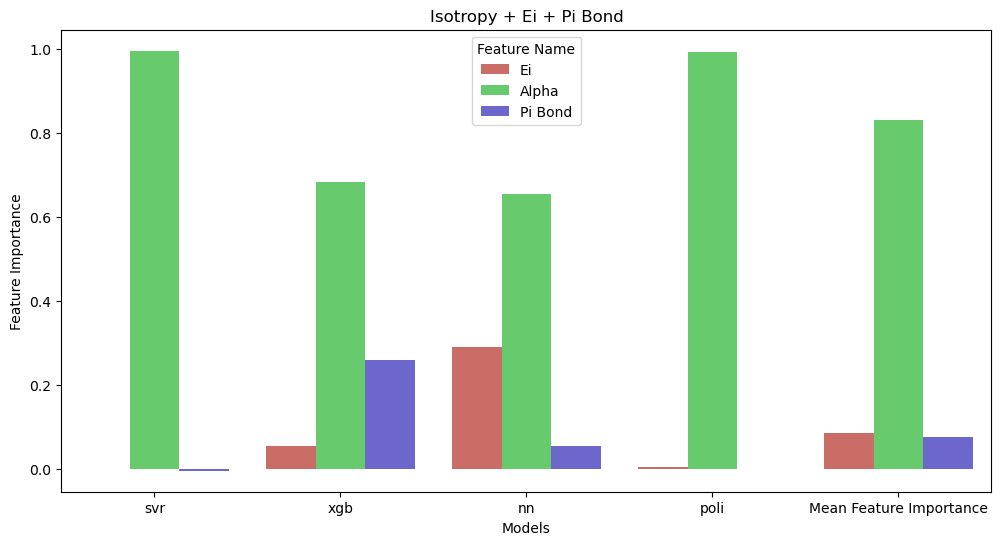

In [282]:
get_feat_graph(feat_import0, title='Isotropy + Ei + Pi Bond')

In [283]:
#Para all features + aniso
plt.figure(figsize=(12,8))
features = ['Ei','axx','ayy','azz','pi_bond']
scaler = att_scaler(scaler, features)
feat_import1 = feat_importance(estim_list01, ['svr','xgb','nn','poli'], ['Ei','axx','ayy','azz', 'Pi Bond'], x_alpha, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

<Figure size 1200x800 with 0 Axes>

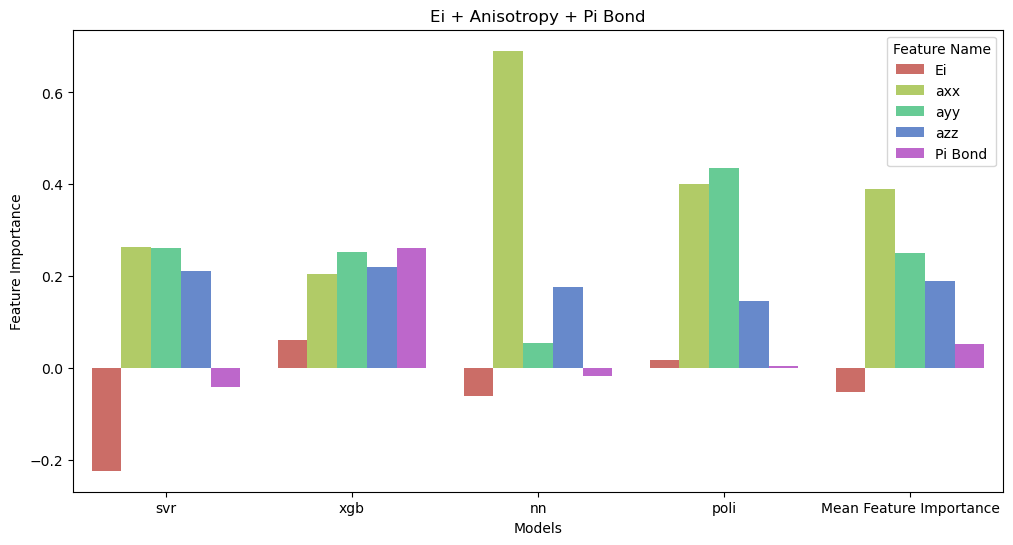

In [284]:
get_feat_graph(feat_import1, title='Ei + Anisotropy + Pi Bond')

In [173]:
#x0: aniso + Ei
plt.figure(figsize=(12,8))
features = ['axx','ayy','azz', 'Ei']
feat_import4 = feat_importance(estim_list04, ['svr','xgb','nn','poli'], ['axx','ayy','azz','Ei'], x0, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

<Figure size 1200x800 with 0 Axes>

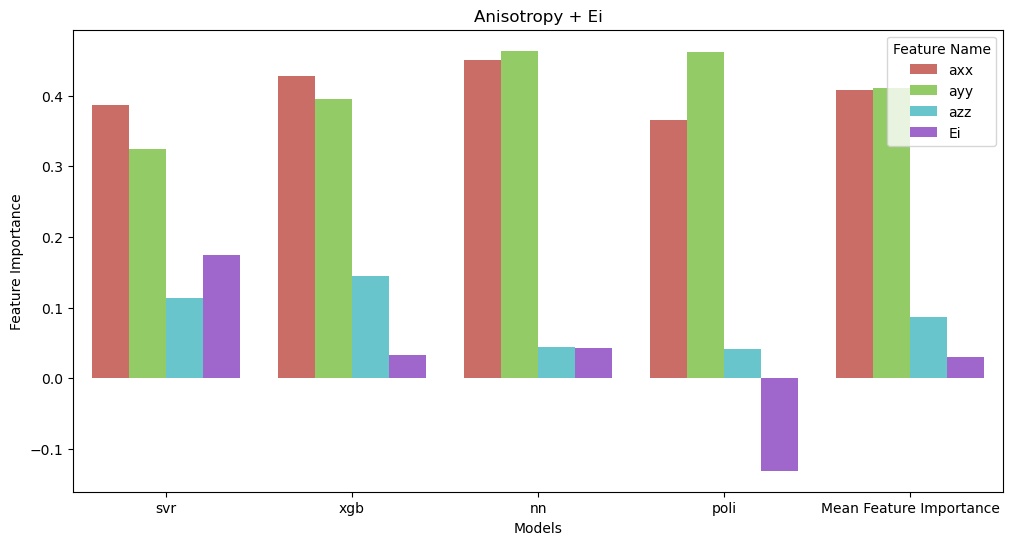

In [174]:
get_feat_graph(feat_import4, title='Anisotropy + Ei')

In [363]:
#x1: Anisotropy + Pi Bond
features = ['axx','ayy','azz','pi_bond']
scaler = att_scaler(scaler, features)
feat_import5 = feat_importance(estim_list05, ['svr','xgb','nn','poli'], ['axx','ayy','azz','Pi Bond'], x1, y.ravel(), 
                5, n_repeats = 150,n_rounds=30)

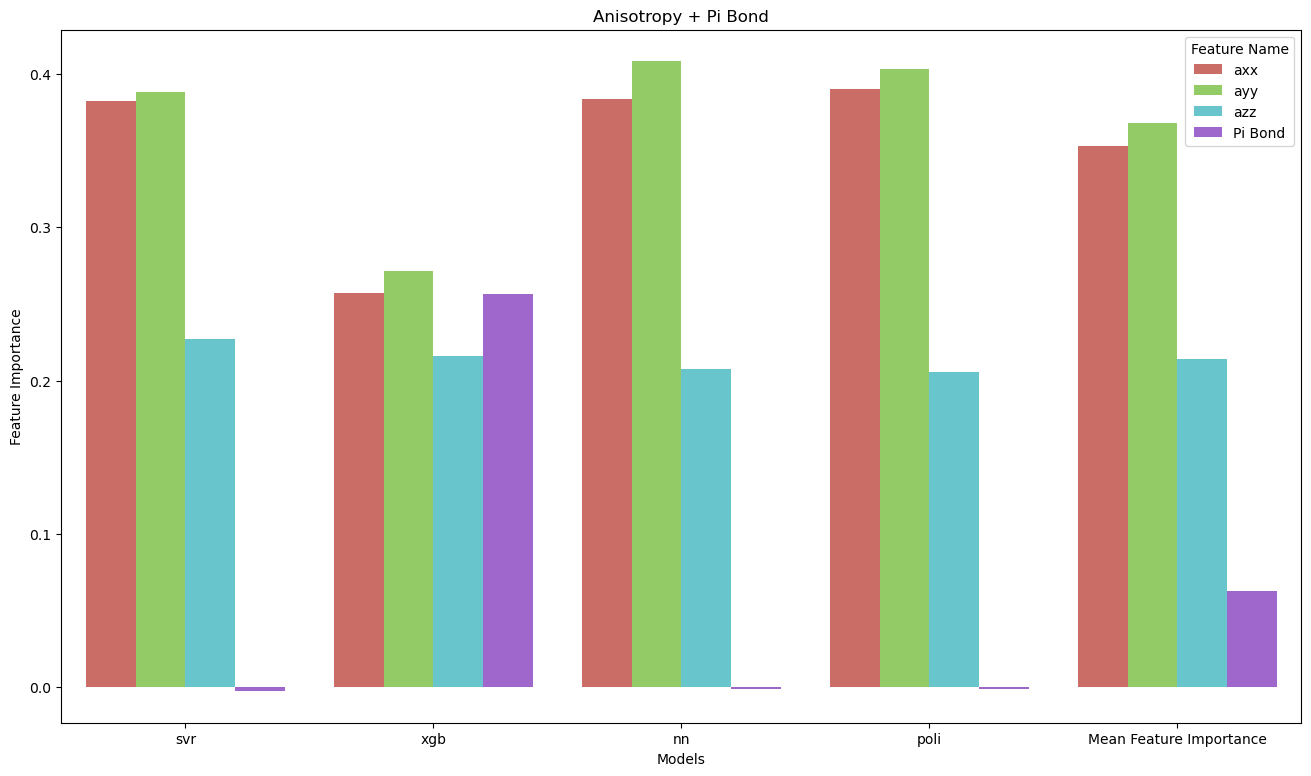

In [364]:
get_feat_graph(feat_import5, title='Anisotropy + Pi Bond',figsize=(16,9))

In [333]:
x1 = df_pol[['axx','ayy','azz','pi_bond']]
x1.shape[1]

4

In [360]:
np.abs(np.corrcoef(x1.T)).shape[1]

4

In [330]:
from sklearn.inspection import permutation_importance
import numpy as np

def feature_importance(estimators, X, y):
    """
    Calcula a importância das features por meio da permutação.
    
    Args:
        - estimators: lista de modelos para os quais deseja calcular a importância das features
        - X: matriz de features
        - y: vetor de targets
        
    Returns:
        Um dicionário onde as chaves são os nomes das features e os valores são as importâncias calculadas.
    """
    feature_importances = {}
    for i, estimator in enumerate(estimators):
        result = permutation_importance(estimator, X, y, n_repeats=100, random_state=0)
        for j in range(X.shape[1]):
            feature_name = f'feature_{j}'
            if feature_name not in feature_importances:
                feature_importances[feature_name] = {'importances': [], 'mean': None}
            feature_importances[feature_name]['importances'].append(result.importances[j])
            
    # Calcula a importância média para cada feature
    for feature_name, values in feature_importances.items():
        feature_importances[feature_name]['mean'] = np.mean(values['importances'])
        
    return feature_importances

In [365]:
fi = feature_importance(estim_list04, x0, y)

In [366]:
print('Pro modelo SVR:')
print("axx:", fi['feature_0']['importances'][0].mean())
print("ayy:", fi['feature_1']['importances'][0].mean())
print("azz:", fi['feature_2']['importances'][0].mean())
print("pi bond:", fi['feature_3']['importances'][0].mean())

Pro modelo SVR:
axx: 0.24410526790753512
ayy: 0.11617857801654857
azz: 0.06010700420580587
pi bond: 0.14932166353706777


In [367]:
print('Pro modelo XGB:')
print("axx:", fi['feature_0']['importances'][1].mean())
print("ayy:", fi['feature_1']['importances'][1].mean())
print("azz:", fi['feature_2']['importances'][1].mean())
print("pi bond:", fi['feature_3']['importances'][1].mean())

Pro modelo XGB:
axx: 0.13649569809959086
ayy: 0.2317040430260456
azz: 0.29564201464304474
pi bond: 0.01831954489244952


In [368]:
print('Pro modelo NN:')
print("axx:", fi['feature_0']['importances'][2].mean())
print("ayy:", fi['feature_1']['importances'][2].mean())
print("azz:", fi['feature_2']['importances'][2].mean())
print("pi bond:", fi['feature_3']['importances'][2].mean())

Pro modelo NN:
axx: 0.3486199397862567
ayy: 0.27496879074973984
azz: -0.040696311032265314
pi bond: -0.03400556445497245


In [369]:
print('Pro modelo Poli:')
print("axx:", fi['feature_0']['importances'][3].mean())
print("ayy:", fi['feature_1']['importances'][3].mean())
print("azz:", fi['feature_2']['importances'][3].mean())
print("pi bond:", fi['feature_3']['importances'][3].mean())

Pro modelo Poli:
axx: 0.5155546169953356
ayy: 0.6258429602615767
azz: 0.06100808884476677
pi bond: -0.07960314816219498


In [370]:
print('Pro modelo médio:')
print("axx:", fi['feature_0']['mean'])
print("ayy:", fi['feature_1']['mean'])
print("azz:", fi['feature_2']['mean'])
print("pi bond:", fi['feature_3']['mean'])

Pro modelo médio:
axx: 0.31119388069717957
ayy: 0.3121735930134777
azz: 0.094015199165338
pi bond: 0.01350812395308747


In [287]:
#x2: Ei + Pi Bond
plt.figure(figsize=(12,8))
features = ['Ei','pi_bond']
scaler = att_scaler(scaler, features)
feat_import6 = feat_importance(estim_list06, ['svr','xgb','nn','poli'], ['Ei','Pi Bond'], x2, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

<Figure size 1200x800 with 0 Axes>

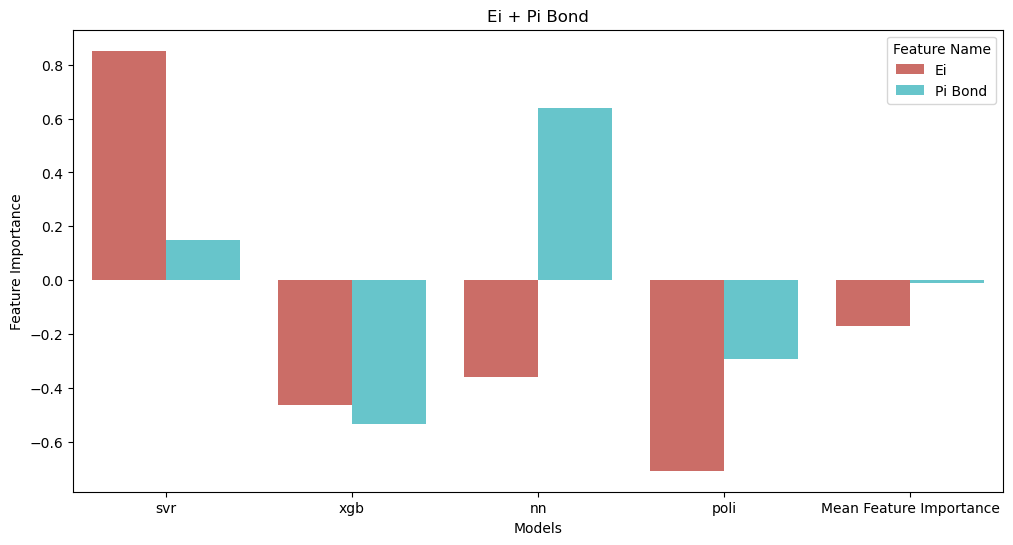

In [288]:
get_feat_graph(feat_import6, title='Ei + Pi Bond')

## Feature Selection Isotropia

In [61]:
#Combinations of all features with isotropy
x0_iso = df_pol[['Alpha','Ei']].values
x1_iso = df_pol[['Alpha','pi_bond']].values

In [115]:
#Pra x0
cv_scores0 = []
train_error0 = []
std0 = []
dict_errors0 = {
}
for i,j,k in zip(estim, spaces,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x0_iso,y,10,5,neural=neural)
    cv_scores0.append(cv_error)
    std0.append(std)
    train_error0.append(train_error)
    dict_errors0[f"{k} pred"] = test_pred
    dict_errors0[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 4/10.
Out folder 5/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The obje

Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Estamos em xgb
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.
Estamos em nn
Out folder 1/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 2/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 3/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 4/10.
Out folder 5/10.
Out folder 6/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 7/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 8/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Out folder 9/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Out folder 10/10.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Estamos em poli
Out folder 1/10.
Out folder 2/10.
Out folder 3/10.
Out folder 4/10.
Out folder 5/10.
Out folder 6/10.
Out folder 7/10.
Out folder 8/10.
Out folder 9/10.
Out folder 10/10.


In [116]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores0)
print("O desvio padrão pra cada algoritmo é:", std0)
print("O erro de treino pra cada algorítmo é:",train_error0)
polar0_df = pd.DataFrame(dict_errors0)
polar0_df.to_csv("x0_apolar_aniso_error.csv", index=False)

O erro pra cada algorítmo no Nested-CV é: [1.113014012193349, 0.7916823642096553, 0.9083588629760209, 0.8970933760288089]
O desvio padrão pra cada algoritmo é: [1.18, 0.5, 1.02, 0.87]
O erro de treino pra cada algorítmo é: [0.5495372681722115, 0.3327484665913244, 0.388991108821959, 0.443973469159508]


In [73]:
#Pra x0_iso stk
nested_cv(stk_lin, space_stk_lin,x0_iso,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 1.5607908861670607
Desvio Padrão: 1.94
Score de Treino: 0.7790616700370055


(1.5607908861670607,
 1.94,
 0.7790616700370055,
 array([ 59.60199904,  62.62670097,  63.37464476,  76.77004674,
        117.49525082, 150.32874321, -18.05489135,  88.0695514 ,
         65.02027753,  57.08358338, 217.61188727,  75.74352386,
         47.97674602,  -3.2114588 , 320.14098121, 107.5533793 ,
         44.17201656]),
 array([0.70291426, 0.04377835, 0.20781694, 0.2688567 , 0.02169783,
        0.03674995, 1.90274457, 7.80695514, 0.18724653, 0.61944278,
        0.27462704, 0.01631787, 0.20038757, 1.32114588, 4.61650844,
        6.17022529, 0.41103978]))

In [62]:
stacked_nested_cv(estim, estim_names, spaces, x0_iso, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.8718384610727444
Desvio Padrão: 0.89
Score de Treino: 0.3382962453929655


(0.8718384610727444,
 0.89,
 0.3382962453929655,
 array([ 21.50161893,  55.89552702,  82.42588377,  68.4138556 ,
        127.97580898, 142.54093889,   6.87944953,  39.31592181,
         72.86336996,  59.07705179, 134.47844427,  60.77974984,
         39.58180658,  37.3599307 , 127.91225007,  60.98820754,
         28.54707656]),
 array([0.38566803, 0.06840788, 0.03032355, 0.34843947, 0.11283312,
        0.01695904, 0.65602752, 2.93159218, 0.08920788, 0.60615299,
        0.55173852, 0.2106526 , 0.34030322, 2.73599307, 1.24407456,
        3.0658805 , 0.61937231]))

In [117]:
# O erro pra cada algorítmo no Nested-CV é: [1.113014012193349, 0.7916823642096553, 0.9083588629760209, 0.8970933760288089]
# O desvio padrão pra cada algoritmo é: [1.18, 0.5, 1.02, 0.87]
# O erro de treino pra cada algorítmo é: [0.5495372681722115, 0.3327484665913244, 0.388991108821959, 0.443973469159508]

In [119]:
#Pra x1
cv_scores1 = []
train_error1 = []
std1 = []
dict_errors1 = {
}
features = ['Alpha','pi_bond']
scaler=att_scaler(scaler, features)

for i,j,k in zip(estim_pi, spaces_pi,estim_names):
    print(f"Estamos em {k}")
    neural = False
    if 'nn' in k:
        neural = True
    cv_error, std, train_error, test_pred, test_error = nested_cv(i,j,x1_iso,y,10,5,neural=neural,verbose=1)
    cv_scores1.append(cv_error)
    std1.append(std)
    train_error1.append(train_error)
    dict_errors1[f"{k} pred"] = test_pred
    dict_errors1[f"{k} error"] = test_error

Estamos em svr
Out folder 1/10.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0236
Function value obtained: 3.1930
Current minimum: 3.1930
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0204
Function value obtained: 3.2536
Current minimum: 3.1930
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0211
Function value obtained: 3.2536
Current minimum: 3.1930
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0203
Function value obtained: 3.2536
Current minimum: 3.1930
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0245
Function value obtained: 3.2536
Current minimum: 3.1930
Ite

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.2771
Function value obtained: 3.0345
Current minimum: 0.3905
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.4455
Function value obtained: 1.1312
Current minimum: 0.3905
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2080
Function value obtained: 1.2215
Current minimum: 0.3905
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.1115
Function value obtained: 2.8185
Current minimum: 0.3905
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.2723
Function value obtained: 0.5668
Current minimum: 0.3905
Iteration No: 111 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.2811
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 118 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.3300
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.3881
Function value obtained: 0.5067
Current minimum: 0.3905
Iteration No: 120 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.4626
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 121 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.5551
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 122 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.4605
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.4571
Function value obtained: 0.4144
Current minimum: 0.3905
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.3335
Function value obtained: 0.7709
Current minimum: 0.3905
Iteration No: 125 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.4970
Function value obtained: 0.4183
Current minimum: 0.3905
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.4043
Function value obtained: 0.9278
Current minimum: 0.3905
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.7378
Function value obtained: 0.4062
Current minimum: 0.3905
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.8399
Function value obtained: 0.3891
Current minimum: 0.3891
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.7455
Function value obtained: 0.3891
Current minimum: 0.3891
Iteration No: 130 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 1.8060
Function value obtained: 0.2791
Current minimum: 0.1929
Iteration No: 109 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 1.9713
Function value obtained: 0.6820
Current minimum: 0.1929
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 1.9366
Function value obtained: 2.9235
Current minimum: 0.1929
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 1.8490
Function value obtained: 8.5056
Current minimum: 0.1929
Iteration No: 112 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 1.8648
Function value obtained: 0.3739
Current minimum: 0.1929
Iteration No: 113 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.1111
Function value obtained: 0.2823
Current minimum: 0.1929
Iteration No: 114 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 1.9103
Function value obtained: 0.2224
Current minimum: 0.1929
Iteration No: 115 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 1.9715
Function value obtained: 0.2594
Current minimum: 0.1929
Iteration No: 116 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.1542
Function value obtained: 0.3562
Current minimum: 0.1929
Iteration No: 117 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.1477
Function value obtained: 0.3187
Current minimum: 0.1929
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.0153
Function value obtained: 0.3277
Current minimum: 0.1929
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.1254
Function value obtained: 2.9235
Current minimum: 0.1929
Iteration No: 120 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 1.9720
Function value obtained: 0.2574
Current minimum: 0.1929
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.2776
Function value obtained: 1.1940
Current minimum: 0.1929
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.1484
Function value obtained: 2.8580
Current minimum: 0.1929
Iteration No: 123 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.3142
Function value obtained: 0.3712
Current minimum: 0.1929
Iteration No: 124 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.3602
Function value obtained: 0.3664
Current minimum: 0.1929
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.3455
Function value obtained: 0.2741
Current minimum: 0.1929
Iteration No: 126 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.1679
Function value obtained: 0.3042
Current minimum: 0.1929
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.1632
Function value obtained: 0.7672
Current minimum: 0.1929
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.2416
Function value obtained: 25.6167
Current minimum: 0.1929
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.1697
Function value obtained: 0.3317
Current minimum: 0.1929
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.1977
Function value obtained: 1.7644
Current minimum: 0.1929
Iteration No: 131 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 2.6455
Function value obtained: 0.3055
Current minimum: 0.1929
Iteration No: 146 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 2.7746
Function value obtained: 0.3169
Current minimum: 0.1929
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 2.8057
Function value obtained: 0.4233
Current minimum: 0.1929
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 2.8417
Function value obtained: 337.4333
Current minimum: 0.1929
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.1723
Function value obtained: 2.9235
Current minimum: 0.1929
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.1049
Function value obtained: 2.1906
Current minimum: 0.1929
Out folder 4/10.
I

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.0071
Function value obtained: 0.3243
Current minimum: 0.2640
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.0661
Function value obtained: 0.2643
Current minimum: 0.2640
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.3567
Function value obtained: 0.2633
Current minimum: 0.2633
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.0313
Function value obtained: 0.2644
Current minimum: 0.2633
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.3017
Function value obtained: 0.2648
Current minimum: 0.2633
Iteration No: 112 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 2.1259
Function value obtained: 0.2588
Current minimum: 0.2588
Iteration No: 103 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 2.1024
Function value obtained: 0.4637
Current minimum: 0.2588
Iteration No: 104 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.3024
Function value obtained: 0.5182
Current minimum: 0.2588
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.1917
Function value obtained: 0.4123
Current minimum: 0.2588
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 1.9126
Function value obtained: 1.1390
Current minimum: 0.2588
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.0075
Function value obtained: 0.3555
Current minimum: 0.2588
Iteration No: 108 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.2645
Function value obtained: 0.8551
Current minimum: 0.2588
Iteration No: 109 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.3467
Function value obtained: 0.3744
Current minimum: 0.2588
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.4295
Function value obtained: 0.3627
Current minimum: 0.2588
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.0301
Function value obtained: 0.4309
Current minimum: 0.2588
Iteration No: 112 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.0039
Function value obtained: 0.3912
Current minimum: 0.2588
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.1068
Function value obtained: 0.4841
Current minimum: 0.2588
Iteration No: 114 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.0024
Function value obtained: 0.4212
Current minimum: 0.2588
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.0550
Function value obtained: 0.7434
Current minimum: 0.2588
Iteration No: 116 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.3632
Function value obtained: 0.4800
Current minimum: 0.2588
Iteration No: 117 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.5491
Function value obtained: 0.4492
Current minimum: 0.2588
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.5429
Function value obtained: 0.9541
Current minimum: 0.2588
Iteration No: 119 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.7745
Function value obtained: 0.5514
Current minimum: 0.2588
Iteration No: 120 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 3.2647
Function value obtained: 0.5382
Current minimum: 0.2588
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.9472
Function value obtained: 0.4312
Current minimum: 0.2588
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.8249
Function value obtained: 0.4272
Current minimum: 0.2588
Iteration No: 123 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.8961
Function value obtained: 0.4687
Current minimum: 0.2588
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.5797
Function value obtained: 0.4498
Current minimum: 0.2588
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.8469
Function value obtained: 0.4703
Current minimum: 0.2588
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.7947
Function value obtained: 0.4501
Current minimum: 0.2588
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.8901
Function value obtained: 0.3456
Current minimum: 0.2588
Iteration No: 128 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 3.0863
Function value obtained: 0.5113
Current minimum: 0.2588
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 3.2504
Function value obtained: 0.3741
Current minimum: 0.2588
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 3.1362
Function value obtained: 0.4816
Current minimum: 0.2588
Iteration No: 131 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 3.2309
Function value obtained: 0.2706
Current minimum: 0.2588
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 3.2032
Function value obtained: 0.3678
Current minimum: 0.2588
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.7262
Function value obtained: 0.3772
Current minimum: 0.2588
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.4038
Function value obtained: 0.3903
Current minimum: 0.2588
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.6266
Function value obtained: 0.3318
Current minimum: 0.2588
Iteration No: 136 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.9654
Function value obtained: 0.2698
Current minimum: 0.2346
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.0365
Function value obtained: 1.0120
Current minimum: 0.2346
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.0069
Function value obtained: 0.4078
Current minimum: 0.2346
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.3236
Function value obtained: 0.9565
Current minimum: 0.2346
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.3223
Function value obtained: 0.4510
Current minimum: 0.2346
Iteration No: 145 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.4860
Function value obtained: 0.2698
Current minimum: 0.2346
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 3.4802
Function value obtained: 0.2376
Current minimum: 0.2346
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.3601
Function value obtained: 0.4078
Current minimum: 0.2346
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.1326
Function value obtained: 0.4078
Current minimum: 0.2346
Iteration No: 150 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.3260
Function value obtained: 0.4078
Current minimum: 0.2346
Out folder 6/10.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0225
Function value obtained: 3.6453
Current minimum: 3.6453
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0174
Function value obtained: 3.6453
Current minimum: 3.6453
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0177
Function value obtained: 3.6453
Current minimum: 3.6453
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0178
Function value obtained: 3.6453
Current minimum: 3.6453
Iteration No: 5 started. Evaluating function at random point.
Itera

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 1.9025
Function value obtained: 2.8255
Current minimum: 0.4416
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 1.9652
Function value obtained: 0.5383
Current minimum: 0.4416
Iteration No: 106 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.0273
Function value obtained: 0.6562
Current minimum: 0.4416
Iteration No: 107 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.1932
Function value obtained: 0.3319
Current minimum: 0.3319
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 1.9551
Function value obtained: 9.9172
Current minimum: 0.3319
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 2.0596
Function value obtained: 1.4660
Current minimum: 0.3319
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 2.1048
Function value obtained: 1.4660
Current minimum: 0.3319
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 2.2297
Function value obtained: 1.1391
Current minimum: 0.3319
Iteration No: 112 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 2.3400
Function value obtained: 2.7896
Current minimum: 0.3319
Iteration No: 113 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.1810
Function value obtained: 0.6903
Current minimum: 0.3319
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.0463
Function value obtained: 1.4660
Current minimum: 0.3319
Iteration No: 115 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.2767
Function value obtained: 0.3405
Current minimum: 0.3319
Iteration No: 116 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.4518
Function value obtained: 0.3405
Current minimum: 0.3319
Iteration No: 117 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.3220
Function value obtained: 0.5234
Current minimum: 0.3319
Iteration No: 118 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 2.2317
Function value obtained: 11.2573
Current minimum: 0.3319
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 2.4422
Function value obtained: 3.6453
Current minimum: 0.3319
Iteration No: 120 started. Searching for the next optimal point.
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.4256
Function value obtained: 0.1974
Current minimum: 0.1974
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.4634
Function value obtained: 0.5669
Current minimum: 0.1974
Iteration No: 122 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.2285
Function value obtained: 0.3405
Current minimum: 0.1974
Iteration No: 123 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.7705
Function value obtained: 0.3405
Current minimum: 0.1974
Iteration No: 124 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.4103
Function value obtained: 67.3732
Current minimum: 0.1974
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.5331
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 126 started. Searching for the next optimal point.
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.9105
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 127 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.5509
Function value obtained: 0.5028
Current minimum: 0.1974
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.6341
Function value obtained: 0.9785
Current minimum: 0.1974
Iteration No: 129 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.5965
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 130 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.7057
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 131 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.6709
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 132 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.8565
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 133 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 3.5191
Function value obtained: 0.3647
Current minimum: 0.1974
Iteration No: 134 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 3.0186
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 135 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 3.1767
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.9520
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 137 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.7671
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 138 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.0424
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 3.1059
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.7596
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 141 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.0710
Function value obtained: 0.3319
Current minimum: 0.1974
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.0496
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.3835
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.3113
Function value obtained: 3.6453
Current minimum: 0.1974
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.5030
Function value obtained: 0.7699
Current minimum: 0.1974
Iteration No: 146 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 2.1977
Function value obtained: 0.6433
Current minimum: 0.2137
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 2.0671
Function value obtained: 3.5488
Current minimum: 0.2137
Iteration No: 115 started. Searching for the next optimal point.
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 2.3371
Function value obtained: 0.1953
Current minimum: 0.1953
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 2.3116
Function value obtained: 1.2489
Current minimum: 0.1953
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 2.3536
Function value obtained: 0.2233
Current minimum: 0.1953
Iteration No: 118 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 2.4642
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 121 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 2.4958
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 2.3806
Function value obtained: 0.5080
Current minimum: 0.1953
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 2.4009
Function value obtained: 0.2106
Current minimum: 0.1953
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 2.4790
Function value obtained: 0.2227
Current minimum: 0.1953
Iteration No: 125 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 2.6352
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 126 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.4267
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 127 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.6646
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.5141
Function value obtained: 1.0623
Current minimum: 0.1953
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.6577
Function value obtained: 0.8158
Current minimum: 0.1953
Iteration No: 130 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.8920
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 131 started. Searching for the next optimal point.
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 2.6562
Function value obtained: 0.2000
Current minimum: 0.1953
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 2.7602
Function value obtained: 0.3909
Current minimum: 0.1953
Iteration No: 133 started. Searching for the next optimal point.
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.9543
Function value obtained: 0.2083
Current minimum: 0.1953
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 2.6793
Function value obtained: 3.5488
Current minimum: 0.1953
Iteration No: 135 st

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.8739
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.7546
Function value obtained: 0.2730
Current minimum: 0.1953
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 2.7787
Function value obtained: 2.5058
Current minimum: 0.1953
Iteration No: 140 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.8478
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.1217
Function value obtained: 0.1964
Current minimum: 0.1953
Iteration No: 142 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 2.9940
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 143 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 2.8187
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 144 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.1392
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 145 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver te

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 2.8932
Function value obtained: 0.4140
Current minimum: 0.1953
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 2.9621
Function value obtained: 0.1988
Current minimum: 0.1953
Iteration No: 147 started. Searching for the next optimal point.
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 2.9422
Function value obtained: 0.2457
Current minimum: 0.1953
Iteration No: 148 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 3.1667
Function value obtained: 0.6057
Current minimum: 0.1953
Iteration No: 149 started. Searching for the next optimal point.
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 3.1358
Function value obtained: 166.9150
Current minimum: 0.1953
Iteration No: 150 started. Searching for the next optimal point.
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 3.0470
Function value obtained: 1.5330
Current minimum: 0.1953
Out folder 8/10.
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0188
Function value obtained: 3.0309
Current minimum: 3.0309
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0174
Function value obtained: 3.1395
Current minimum: 3.0309
Iteration No: 3 started. Evaluati

/home/miguel/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 2.5321
Function value obtained: 0.4727
Current minimum: 0.2608
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 2.5036
Function value obtained: 0.4780
Current minimum: 0.2608
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 2.5315
Function value obtained: 0.2869
Current minimum: 0.2608
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 2.7058
Function value obtained: 0.4994
Current minimum: 0.2608
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 2.9071
Function value obtained: 3.0425
Current minimum: 0.2608
Iteration No: 143 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 2.6344
Function value obtained: 1.0298
Current minimum: 0.2772
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 2.6320
Function value obtained: 2.1705
Current minimum: 0.2772
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 2.2409
Function value obtained: 0.3657
Current minimum: 0.2772
Iteration No: 107 started. Searching for the next optimal point.
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 2.5042
Function value obtained: 0.2159
Current minimum: 0.2159
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 2.1474
Function value obtained: 0.2668
Current minimum: 0.2159
Iteration No: 109 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 2.6027
Function value obtained: 0.1605
Current minimum: 0.1605
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 2.7421
Function value obtained: 0.2050
Current minimum: 0.1605
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 2.5995
Function value obtained: 0.2119
Current minimum: 0.1605
Iteration No: 129 started. Searching for the next optimal point.
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 2.8249
Function value obtained: 0.2005
Current minimum: 0.1605
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 2.8186
Function value obtained: 2.4975
Current minimum: 0.1605
Iteration No: 131 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 2.6337
Function value obtained: 0.2638
Current minimum: 0.1605
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.6106
Function value obtained: 0.1170
Current minimum: 0.1170
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.6645
Function value obtained: 0.1934
Current minimum: 0.1170
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.8164
Function value obtained: 0.1844
Current minimum: 0.1170
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 3.0821
Function value obtained: 0.3108
Current minimum: 0.1170
Iteration No: 139 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 3.1150
Function value obtained: 0.3577
Current minimum: 0.1170
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 3.1038
Function value obtained: 0.1898
Current minimum: 0.1170
Iteration No: 142 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 3.0652
Function value obtained: 0.2041
Current minimum: 0.1170
Iteration No: 143 started. Searching for the next optimal point.
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 3.1694
Function value obtained: 0.1959
Current minimum: 0.1170
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 3.1632
Function value obtained: 0.2014
Current minimum: 0.1170
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 3.1330
Function value obtained: 0.1266
Current minimum: 0.1170
Iteration No: 146 started. Searching for the next optimal point.
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 3.0125
Function value obtained: 0.1635
Current minimum: 0.1170
Iteration No: 147 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: Conver

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 2.6488
Function value obtained: 1.0043
Current minimum: 0.2093
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 2.7612
Function value obtained: 0.2597
Current minimum: 0.2093
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 2.9058
Function value obtained: 0.5021
Current minimum: 0.2093
Iteration No: 136 started. Searching for the next optimal point.
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 2.9170
Function value obtained: 0.4021
Current minimum: 0.2093
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 2.9319
Function value obtained: 0.7514
Current minimum: 0.2093
Iteration No: 138 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.9519
Function value obtained: 0.9440
Current minimum: 0.3771
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3419
Function value obtained: 2.1304
Current minimum: 0.3771
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0312
Function value obtained: 1.0048
Current minimum: 0.3771
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3213
Function value obtained: 0.5119
Current minimum: 0.3771
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0327
Function value obtained: 5.1871
Current minimum: 0.3771
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.8153
Function value obtained: 1.0705
Current minimum: 0.3771
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0545
Function value obtained: 2.0888
Current minimum: 0.3771
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 2.9989
Function value obtained: 0.4764
Current minimum: 0.3771
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0936
Function value obtained: 1.8459
Current minimum: 0.3771
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2231
Function value obtained: 1.4164
Current minimum: 0.3771
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.3391
Function value obtained: 0.9281
Current minimum: 0.3531
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0435
Function value obtained: 1.9011
Current minimum: 0.3531
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1402
Function value obtained: 1.6642
Current minimum: 0.3531
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.4481
Function value obtained: 0.4985
Current minimum: 0.3531
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5939
Function value obtained: 1.7945
Current minimum: 0.3531
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.8610
Function value obtained: 1.0420
Current minimum: 0.4153
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0402
Function value obtained: 2.0795
Current minimum: 0.4153
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.1280
Function value obtained: 0.4375
Current minimum: 0.4153
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0950
Function value obtained: 1.7419
Current minimum: 0.4153
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1848
Function value obtained: 1.3209
Current minimum: 0.4153
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.2427
Function value obtained: 0.9545
Current minimum: 0.4153
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0424
Function value obtained: 1.8744
Current minimum: 0.4153
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1029
Function value obtained: 1.6028
Current minimum: 0.4153
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3130
Function value obtained: 0.6312
Current minimum: 0.4153
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5987
Function value obtained: 1.6877
Current minimum: 0.4153
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.9279
Function value obtained: 0.8300
Current minimum: 0.3858
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3227
Function value obtained: 1.4056
Current minimum: 0.3858
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0317
Function value obtained: 0.8686
Current minimum: 0.3858
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3753
Function value obtained: 0.3902
Current minimum: 0.3858
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0372
Function value obtained: 4.7276
Current minimum: 0.3858
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.7674
Function value obtained: 0.9271
Current minimum: 0.3858
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0366
Function value obtained: 1.6553
Current minimum: 0.3858
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.2493
Function value obtained: 0.2811
Current minimum: 0.2811
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0954
Function value obtained: 1.4989
Current minimum: 0.2811
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.1602
Function value obtained: 1.1039
Current minimum: 0.2811
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.6812
Function value obtained: 0.8228
Current minimum: 0.2811
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0426
Function value obtained: 1.5019
Current minimum: 0.2811
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1083
Function value obtained: 1.3291
Current minimum: 0.2811
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.5449
Function value obtained: 0.3306
Current minimum: 0.2811
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5394
Function value obtained: 1.4510
Current minimum: 0.2811
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.1195
Function value obtained: 0.7996
Current minimum: 0.3770
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0443
Function value obtained: 2.1238
Current minimum: 0.3770
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1203
Function value obtained: 1.7091
Current minimum: 0.3770
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3942
Function value obtained: 0.5566
Current minimum: 0.3770
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5923
Function value obtained: 1.8391
Current minimum: 0.3770
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.3873
Function value obtained: 0.8929
Current minimum: 0.3729
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3664
Function value obtained: 1.6797
Current minimum: 0.3729
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0441
Function value obtained: 1.0456
Current minimum: 0.3729
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3549
Function value obtained: 0.6637
Current minimum: 0.3729
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.0326
Function value obtained: 5.4980
Current minimum: 0.3729
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Eval

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.8907
Function value obtained: 1.0100
Current minimum: 0.3729
Iteration No: 22 started. Evaluating function at random point.
Iteration No: 22 ended. Evaluation done at random point.
Time taken: 0.0446
Function value obtained: 2.2254
Current minimum: 0.3729
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 3.5036
Function value obtained: 0.4782
Current minimum: 0.3729
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 0.0975
Function value obtained: 1.8721
Current minimum: 0.3729
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 0.2110
Function value obtained: 1.3835
Current minimum: 0.3729
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.5618
Function value obtained: 0.8992
Current minimum: 0.3729
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0541
Function value obtained: 2.0059
Current minimum: 0.3729
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1108
Function value obtained: 1.6801
Current minimum: 0.3729
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.4880
Function value obtained: 0.7292
Current minimum: 0.3729
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.6226
Function value obtained: 1.8154
Current minimum: 0.3729
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 52 ended. Evaluation done at random point.
Time taken: 4.8713
Function value obtained: 1.2105
Current minimum: 0.3729
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 0.0441
Function value obtained: 1.4110
Current minimum: 0.3729
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 0.7474
Function value obtained: 1.9489
Current minimum: 0.3729
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended. Evaluation done at random point.
Time taken: 0.1190
Function value obtained: 1.8609
Current minimum: 0.3729
Iteration No: 56 started. Evaluating function at random point.
Iteration No: 56 ended. Evaluation done at random point.
Time taken: 0.1290
Function value obtained: 1.9139
Current minimum: 0.3729
Iteration No: 57 started. Evaluating function at random point.
Iteration No: 57 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.4448
Function value obtained: 0.9714
Current minimum: 0.2835
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0458
Function value obtained: 1.7794
Current minimum: 0.2835
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1393
Function value obtained: 1.4307
Current minimum: 0.2835
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3285
Function value obtained: 0.2950
Current minimum: 0.2835
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.6705
Function value obtained: 1.5502
Current minimum: 0.2835
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.7195
Function value obtained: 0.7651
Current minimum: 0.2254
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0516
Function value obtained: 1.6695
Current minimum: 0.2254
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1752
Function value obtained: 1.3009
Current minimum: 0.2254
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.4101
Function value obtained: 0.2495
Current minimum: 0.2254
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5836
Function value obtained: 1.4477
Current minimum: 0.2254
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 36 ended. Evaluation done at random point.
Time taken: 7.5170
Function value obtained: 0.9416
Current minimum: 0.2846
Iteration No: 37 started. Evaluating function at random point.
Iteration No: 37 ended. Evaluation done at random point.
Time taken: 0.0376
Function value obtained: 2.0558
Current minimum: 0.2846
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.1908
Function value obtained: 1.5240
Current minimum: 0.2846
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 0.3543
Function value obtained: 0.2954
Current minimum: 0.2846
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 0.5831
Function value obtained: 1.6560
Current minimum: 0.2846
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. E

In [120]:
print("O erro pra cada algorítmo no Nested-CV é:",cv_scores1)
print("O desvio padrão pra cada algoritmo é:", std1)
print("O erro de treino pra cada algorítmo é:",train_error1)
polar1_df = pd.DataFrame(dict_errors1)
polar1_df.to_csv("x1_apolar_aniso_error.csv", index=False)

O erro pra cada algorítmo no Nested-CV é: [0.3348696326113936, 0.5002271509503483, 0.32897172728360324, 0.5611404898967144]
O desvio padrão pra cada algoritmo é: [0.41, 0.56, 0.28, 0.84]
O erro de treino pra cada algorítmo é: [0.08912377939168695, 0.07559935663188415, 0.10480784938793837, 0.35751678303141643]


In [74]:
#Pra x1_iso stk
features = ['Alpha','pi_bond']
scaler = att_scaler(scaler, features)
nested_cv(stk_lin_pi, space_stk_lin,x1_iso,y,out_cv = 10, inner_cv = 5, neural=True, stacked=True, print_mode=True)

Cv Score: 0.38359426663914153
Desvio Padrão: 0.81
Score de Treino: 0.20786737763858687


(0.38359426663914153,
 0.81,
 0.20786737763858687,
 array([ 36.72937569,  54.17039672,  77.39541943, 102.07217949,
        130.73409807, 132.63951743,   9.93548281,  10.57887622,
         79.26052999, 158.40478936, 254.87715636,  79.98940915,
         56.64309785,  11.51649589,  33.03455989,  56.87884497,
         80.55789163]),
 array([0.04941073, 0.09716005, 0.03255726, 0.027884  , 0.13681824,
        0.08524471, 0.50322586, 0.05788762, 0.00924338, 0.05603193,
        0.15040948, 0.0388235 , 0.05594837, 0.15164959, 0.42044632,
        2.791923  , 0.07410522]))

In [63]:
features = ['Alpha','pi_bond']
scaler = att_scaler(scaler, features)
stacked_nested_cv(estim_pi, estim_pi_names, spaces_pi, x1_iso, y,out_cv = 10, inner_cv = 5, neural=True,print_mode=True)

Cv Score: 0.3913988649067037
Desvio Padrão: 0.52
Score de Treino: 0.14893535997850063


(0.3913988649067037,
 0.52,
 0.14893535997850063,
 array([ 23.78133251,  57.96663842,  76.90334936,  92.19188211,
        131.92406685, 138.98499681,   9.14700123,   8.79348421,
         73.40455361, 159.18792893, 157.79250811,  55.50761076,
         56.30754351,  16.77811007,  96.43142507,  43.55108436,
         58.26711593]),
 array([0.32053336, 0.03388936, 0.03870813, 0.12198208, 0.1471658 ,
        0.04148278, 0.54264994, 0.12065158, 0.08244308, 0.06125286,
        0.47402497, 0.27912194, 0.06154094, 0.67781101, 0.69177939,
        1.90340562, 0.22310512]))

In [121]:
# O erro pra cada algorítmo no Nested-CV é: [0.3348696326113936, 0.5002271509503483, 0.32897172728360324, 0.5611404898967144]
# O desvio padrão pra cada algoritmo é: [0.41, 0.56, 0.28, 0.84]
# O erro de treino pra cada algorítmo é: [0.08912377939168695, 0.07559935663188415, 0.10480784938793837, 0.35751678303141643]

In [201]:
cv_scores0_iso = [1.113014012193349, 0.7916823642096553, 0.9083588629760209, 0.8970933760288089] #Alpha + Ei
cv_scores1_iso = [0.3348696326113936, 0.5002271509503483, 0.32897172728360324, 0.5611404898967144] #Alpha + Pi Bond
cv_scores2 = [1.0963391983555506, 1.012743682037893, 1.3157547217423733, 0.9962428047569614] # Ei + Pi Bond
errorx0 = [0.8577438290570095, 0.9634033427914103, 0.9048556249955915, 0.8330685869714245] #All features w/Isotropy

In [202]:
mean_results = [np.mean(cv_scores0_iso), np.mean(cv_scores1_iso), np.mean(cv_scores2),np.mean(errorx0)]
cv_scores0_iso.append(mean_results[0])
cv_scores1_iso.append(mean_results[1])
cv_scores2.append(mean_results[2])
errorx0.append(mean_results[3])

### Gráfico Feature Selection Isotropia

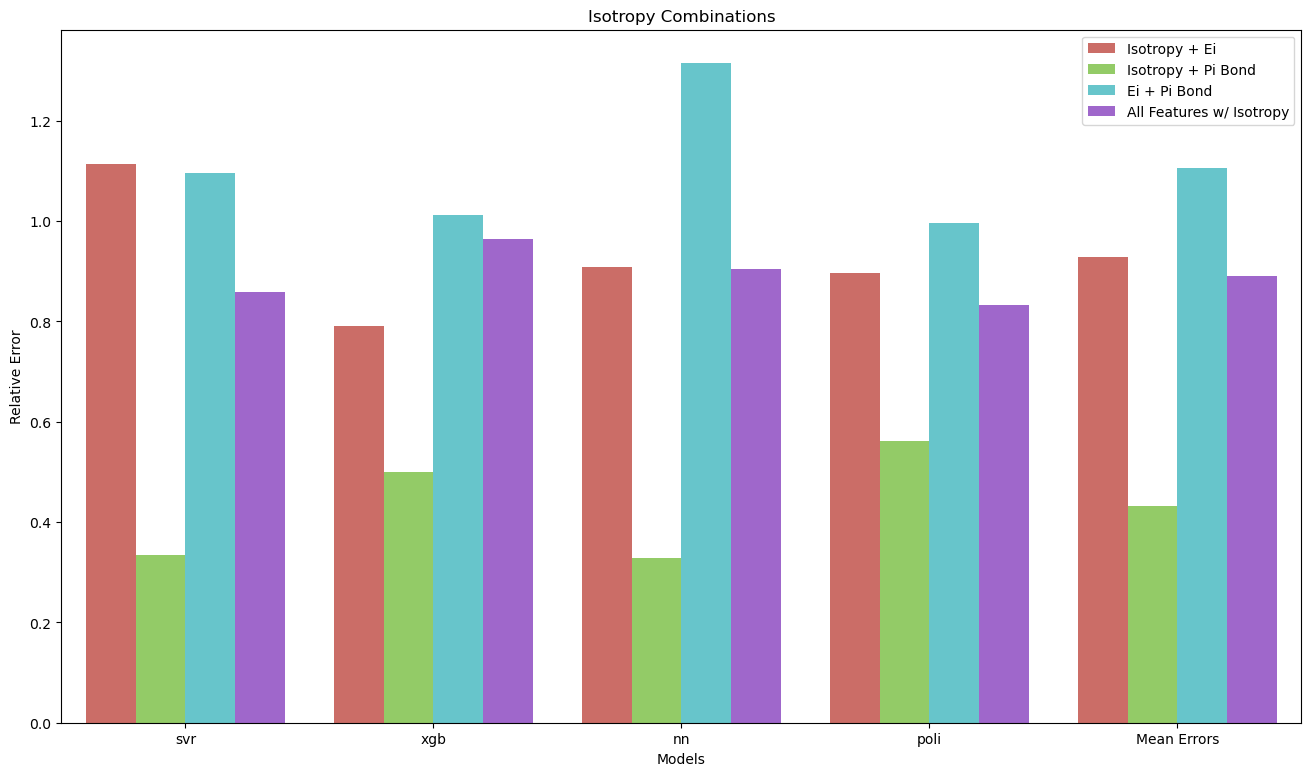

In [210]:
plt.figure(figsize=(16,9))
all_cv_error = cv_scores0_iso + cv_scores1_iso + cv_scores2 + errorx0 
create_fast_graph(all_cv_error, aux_model=['svr','xgb','nn','poli','Mean Errors'],hue=['Isotropy + Ei', 
                                                                                       'Isotropy + Pi Bond', 'Ei + Pi Bond','All Features w/ Isotropy'], title='Isotropy Combinations')

### Feature Importance Isotropia

In [ ]:
#Otimizando x0_iso e x1_iso // Alpha + Ei e Alpha + Pi Bond

In [234]:
#For x0_iso
features = ['Alpha', 'Ei']
#scaler=att_scaler(scaler, features)
estim_x0_iso = opt_all(estim,estim_names,x0_iso,y,5,spaces, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['poly', 'scale', 2, 6.278306453884706, 1.0, 0.19510862240624474, StandardScaler(), MinMaxScaler()]
Cujo score de teste é: 0.5061154956739845

Para o estimador xgb, os parâmetros são: [0.07908288448246621, 2000, 15, 3, 0.39574924693990554, 0.3240994963212318, 0.1, 0.0, 0.9436219337453507]
Cujo score de teste é: 0.5659088531234299

Para o estimador nn, os parâmetros são: ['relu', 0.000742675205834415, 3, 6, 0.5328230981459784, 0.8061082335193039, StandardScaler(), StandardScaler()]
Cujo score de teste é: 0.5211441709552157

Para o estimador poli, os parâmetros são: [0.96376287755994, False, False, 10, False, False, MinMaxScaler(), MinMaxScaler()]
Cujo score de teste é: 0.4933564909749274



In [51]:
stk_opt = gp_optimize(stk_lin, x0_iso, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.4460
Function value obtained: 2.3842
Current minimum: 2.3842
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.9891
Function value obtained: 1.2485
Current minimum: 1.2485
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0182
Function value obtained: 1.5735
Current minimum: 1.2485
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.4768
Function value obtained: 1.8601
Current minimum: 1.2485
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.6026
Function value obtained: 1.2041
Current minimum: 1.2041
Iteration No: 6 started. Evaluating

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 13.2434
Function value obtained: 0.9283
Current minimum: 0.9283
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.4488
Function value obtained: 1.1110
Current minimum: 0.9283
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.6702
Function value obtained: 1.5729
Current minimum: 0.9283
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.4861
Function value obtained: 2.1712
Current minimum: 0.9283
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 1.8574
Function value obtained: 1.4775
Current minimum: 0.9283
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evalu

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 40 ended. Evaluation done at random point.
Time taken: 15.1257
Function value obtained: 1.5082
Current minimum: 0.9283
Iteration No: 41 started. Evaluating function at random point.
Iteration No: 41 ended. Evaluation done at random point.
Time taken: 13.8158
Function value obtained: 1.4872
Current minimum: 0.9283
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 5.3259
Function value obtained: 1.1591
Current minimum: 0.9283
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 5.3101
Function value obtained: 1.4858
Current minimum: 0.9283
Iteration No: 44 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 44 ended. Evaluation done at random point.
Time taken: 9.0764
Function value obtained: 1.5734
Current minimum: 0.9283
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 3.5856
Function value obtained: 1.0290
Current minimum: 0.9283
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 3.4875
Function value obtained: 1.0242
Current minimum: 0.9283
Iteration No: 47 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.28224e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.68977e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.10949e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.48276e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 1.4543
Function value obtained: 1.8843
Current minimum: 0.9283
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 17.8762
Function value obtained: 1.6420
Current minimum: 0.9283
Iteration No: 49 started. Evaluating function at random point.
Iteration No: 49 ended. Evaluation done at random point.
Time taken: 3.0589
Function value obtained: 21.9361
Current minimum: 0.9283
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 5.7886
Function value obtained: 1.2836
Current minimum: 0.9283
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.0842
Function value obtained: 1.3147
Current minimum: 0.9283
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended.

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/pyth

Iteration No: 97 ended. Evaluation done at random point.
Time taken: 10.4936
Function value obtained: 2.3111
Current minimum: 0.8407
Iteration No: 98 started. Evaluating function at random point.
Iteration No: 98 ended. Evaluation done at random point.
Time taken: 3.8709
Function value obtained: 1.3578
Current minimum: 0.8407
Iteration No: 99 started. Evaluating function at random point.
Iteration No: 99 ended. Evaluation done at random point.
Time taken: 2.8480
Function value obtained: 1.6535
Current minimum: 0.8407
Iteration No: 100 started. Evaluating function at random point.
Iteration No: 100 ended. Evaluation done at random point.
Time taken: 6.0921
Function value obtained: 1.3893
Current minimum: 0.8407
Iteration No: 101 started. Searching for the next optimal point.
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 5.6966
Function value obtained: 1.2909
Current minimum: 0.8407
Iteration No: 102 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 9.0630
Function value obtained: 2.1186
Current minimum: 0.8407
Iteration No: 103 started. Searching for the next optimal point.
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 18.7624
Function value obtained: 1.0070
Current minimum: 0.8407
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 9.5791
Function value obtained: 2.7159
Current minimum: 0.8407
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 5.2555
Function value obtained: 1.9336
Current minimum: 0.8407
Iteration No: 106 started. Searching for the next optimal point.
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 8.7835
Function value obtained: 4.3031
Current minimum: 0.8407
Iteration No: 107 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 8.7362
Function value obtained: 1.2381
Current minimum: 0.8407
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 6.1614
Function value obtained: 1.6101
Current minimum: 0.8407
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 4.1003
Function value obtained: 0.8557
Current minimum: 0.8407
Iteration No: 111 started. Searching for the next optimal point.
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 4.9000
Function value obtained: 1.2615
Current minimum: 0.8407
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 8.8066
Function value obtained: 2.1553
Current minimum: 0.8407
Iteration No: 113 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.66122e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.55357e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.53701e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.64007e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 4.6532
Function value obtained: 1.3624
Current minimum: 0.8407
Iteration No: 121 started. Searching for the next optimal point.
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 9.3424
Function value obtained: 2.0304
Current minimum: 0.8407
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 4.1826
Function value obtained: 1.1654
Current minimum: 0.8407
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 6.3696
Function value obtained: 1.0975
Current minimum: 0.8407
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 7.7264
Function value obtained: 1.0478
Current minimum: 0.8407
Iteration No: 125 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 7.6831
Function value obtained: 1.0921
Current minimum: 0.8407
Iteration No: 136 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 6.0955
Function value obtained: 0.8717
Current minimum: 0.8407
Iteration No: 137 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 5.3094
Function value obtained: 1.1512
Current minimum: 0.8407
Iteration No: 138 started. Searching for the next optimal point.
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 6.5424
Function value obtained: 1.3715
Current minimum: 0.8407
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 10.4029
Function value obtained: 1.6382
Current minimum: 0.8407
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 8.3012
Function value obtained: 3.0243
Current minimum: 0.8407
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 5.7502
Function value obtained: 1.1180
Current minimum: 0.8407
Iteration No: 142 s

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 6.7933
Function value obtained: 0.8359
Current minimum: 0.8359
Iteration No: 144 started. Searching for the next optimal point.
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 8.8273
Function value obtained: 1.2382
Current minimum: 0.8359
Iteration No: 145 started. Searching for the next optimal point.
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 6.6074
Function value obtained: 1.4019
Current minimum: 0.8359
Iteration No: 146 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 6.2567
Function value obtained: 1.0224
Current minimum: 0.8359
Iteration No: 147 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 6.6982
Function value obtained: 0.8396
Current minimum: 0.8359
Iteration No: 148 started. Searching for the next optimal point.
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 6.3078
Function value obtained: 0.8995
Current minimum: 0.8359
Iteration No: 149 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 7.8000
Function value obtained: 1.0610
Current minimum: 0.8359
Iteration No: 150 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 7.1929
Function value obtained: 0.9387
Current minimum: 0.8359


In [52]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [1e-05, 1, 'poly', 'auto', 1.0, 0.2, 898, 1, 0.1, 'logistic', 0.001, 1, 1]
Valor de função:  0.8359125251980359


In [71]:
params_stk = [1e-05, 1, 'poly', 'auto', 1.0, 0.2, 898, 1, 0.1, 'logistic', 0.001, 1, 1]
att_model(stk_lin, space_stk_lin, params_stk, neural = True, stacked = True)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scaling', MinMaxScaler()),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge0_iso = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge0_iso_params = [0.96376287755994, False, False, 10, False, False, MinMaxScaler(), MinMaxScaler()]
att_model(ridge0_iso, space_poli, ridge0_iso_params)

pipe = Pipeline([('scale',StandardScaler()), ('reg',SVR(max_iter=10000))])
svr0_iso = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr0_iso_params=['poly', 'scale', 2, 6.278306453884706, 1.0, 0.19510862240624474, StandardScaler(), MinMaxScaler()]
att_model(svr0_iso, space_svr, svr0_iso_params)

xgb0_iso = XGBRegressor(random_state=0)
xgb0_iso_params = [0.07908288448246621, 2000, 15, 3, 0.39574924693990554, 0.3240994963212318, 0.1, 0.0, 0.9436219337453507]
att_model(xgb0_iso, space_xgb, xgb0_iso_params)

pipe = Pipeline([('scale', MinMaxScaler()), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn0_iso = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn0_iso_params = ['relu', 0.000742675205834415, 3, 6, 0.5328230981459784, 0.8061082335193039, StandardScaler(), StandardScaler()]
att_model(nn0_iso, space_nn,nn0_iso_params,neural=True)

estim_list0_iso = [svr0_iso,xgb0_iso,nn0_iso, ridge0_iso, stk_lin]

In [72]:
pickle.dump(estim_list0_iso, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_iso_x0.sav', 'wb'))

In [235]:
#For x1_iso
features = ['Alpha', 'pi_bond']
scaler=att_scaler(scaler, features)
estim_x1_iso = opt_all(estim_pi,estim_names,x1_iso,y,5,spaces_pi, shuffle=True)

---------Polarizabilidade Isotrópica---------


Para o estimador svr, os parâmetros são: ['rbf', 'auto', 7, 5.92854403273602, 0.8915707206489035, 0.01, StandardScaler(), MinMaxScaler()]
Cujo score de teste é: 0.23272531180872127

Para o estimador xgb, os parâmetros são: [0.018781222953107284, 1734, 14, 2, 2.517431527378652, 0.39847233276148264, 0.16659508851255567, 0.0, 0.5436214931166946]
Cujo score de teste é: 0.28142222708635345

Para o estimador nn, os parâmetros são: ['tanh', 0.000432797653204658, 8, 15, 0.598782112633391, 0.64969049453831, MinMaxScaler(), RobustScaler()]
Cujo score de teste é: 0.20300729922767066

Para o estimador poli, os parâmetros são: [1.1739561887448542, True, False, 3, False, False, RobustScaler(), MinMaxScaler()]
Cujo score de teste é: 0.3713025496748494



In [56]:
stk_opt = gp_optimize(stk_lin, x1_iso, y ,space_stk_lin, cv=5,neural=True, stacked=True)

Iteration No: 1 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.16524e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.44166e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.53625e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.53587e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.4706
Function value obtained: 39.2414
Current minimum: 39.2414
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.0013
Function value obtained: 0.5378
Current minimum: 0.5378
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8495
Function value obtained: 31.3371
Current minimum: 0.5378
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.8701
Function value obtained: 0.4352
Current minimum: 0.4352
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.1040
Function value obtained: 1.6735
Current minimum: 0.4352
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluatio

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.31758e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.8457
Function value obtained: 287.7772
Current minimum: 0.4352
Iteration No: 11 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 2.1204
Function value obtained: 2.9655
Current minimum: 0.4352
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.8451
Function value obtained: 1.7836
Current minimum: 0.4352
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.8170
Function value obtained: 0.4133
Current minimum: 0.4133
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 13.7367
Function value obtained: 0.8127
Current minimum: 0.4133
Iteration No: 15 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.10861e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.72181e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.88301e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.47397e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 3.1398
Function value obtained: 107.9552
Current minimum: 0.4133
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 4.2381
Function value obtained: 1.9341
Current minimum: 0.4133
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 4.4293
Function value obtained: 5.7875
Current minimum: 0.4133
Iteration No: 18 started. Evaluating function at random point.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 4.4027
Function value obtained: 0.4988
Current minimum: 0.4133
Iteration No: 19 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.31029e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.33167e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.73867e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.1088
Function value obtained: 4.2928
Current minimum: 0.4133
Iteration No: 20 started. Evaluating function at random point.
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 4.5293
Function value obtained: 0.2573
Current minimum: 0.2573
Iteration No: 21 started. Evaluating function at random point.
Iteration No: 21 ended. Evaluation done at random point.
Time taken: 7.0198
Function value obtained: 0.6271
Current minimum: 0.2573
Iteration No: 22 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.00527e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.93113e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.03548e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.64862e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 3.8972
Function value obtained: 37.6372
Current minimum: 0.2573
Iteration No: 23 started. Evaluating function at random point.
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 4.7565
Function value obtained: 5.0372
Current minimum: 0.2573
Iteration No: 24 started. Evaluating function at random point.
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 2.2665
Function value obtained: 1.0883
Current minimum: 0.2573
Iteration No: 25 started. Evaluating function at random point.
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 4.1741
Function value obtained: 2.4587
Current minimum: 0.2573
Iteration No: 26 started. Evaluating function at random point.
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 7.8766
Function value obtained: 1.4327
Current minimum: 0.2573
Iteration No: 27 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.47222e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.88611e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 3.7485
Function value obtained: 29.7568
Current minimum: 0.2573
Iteration No: 28 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 28 ended. Evaluation done at random point.
Time taken: 2.6958
Function value obtained: 1.7623
Current minimum: 0.2573
Iteration No: 29 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.89477e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.21718e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.17841e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.7454
Function value obtained: 10.9366
Current minimum: 0.2573
Iteration No: 30 started. Evaluating function at random point.
Iteration No: 30 ended. Evaluation done at random point.
Time taken: 3.1331
Function value obtained: 2.1004
Current minimum: 0.2573
Iteration No: 31 started. Evaluating function at random point.
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 3.7218
Function value obtained: 0.6209
Current minimum: 0.2573
Iteration No: 32 started. Evaluating function at random point.
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 3.8284
Function value obtained: 0.3234
Current minimum: 0.2573
Iteration No: 33 started. Evaluating function at random point.
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 2.5555
Function value obtained: 0.8358
Current minimum: 0.2573
Iteration No: 34 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.58278e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.86873e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.78152e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.54342e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 2.0805
Function value obtained: 5.7464
Current minimum: 0.2573
Iteration No: 35 started. Evaluating function at random point.
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 2.4476
Function value obtained: 14.2225
Current minimum: 0.2573
Iteration No: 36 started. Evaluating function at random point.
Iteration No: 36 ended. Evaluation done at random point.
Time taken: 3.0066
Function value obtained: 1.5582
Current minimum: 0.2573
Iteration No: 37 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.16802e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.44644e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.33871e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.00964e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 37 ended. Evaluation done at random point.
Time taken: 2.7376
Function value obtained: 20.3560
Current minimum: 0.2573
Iteration No: 38 started. Evaluating function at random point.
Iteration No: 38 ended. Evaluation done at random point.
Time taken: 0.6242
Function value obtained: 1.4134
Current minimum: 0.2573
Iteration No: 39 started. Evaluating function at random point.
Iteration No: 39 ended. Evaluation done at random point.
Time taken: 2.3767
Function value obtained: 0.9644
Current minimum: 0.2573
Iteration No: 40 started. Evaluating function at random point.
Iteration No: 40 ended. Evaluation done at random point.
Time taken: 9.7881
Function value obtained: 0.9956
Current minimum: 0.2573
Iteration No: 41 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.52682e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.60398e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.15709e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 14.7278
Function value obtained: 26.7762
Current minimum: 0.2573
Iteration No: 42 started. Evaluating function at random point.
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 4.8222
Function value obtained: 0.8278
Current minimum: 0.2573
Iteration No: 43 started. Evaluating function at random point.
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.8090
Function value obtained: 5.4577
Current minimum: 0.2573
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 5.3758
Function value obtained: 0.7066
Current minimum: 0.2573
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 2.8385
Function value obtained: 0.7279
Current minimum: 0.2573
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended.

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 1.4545
Function value obtained: 98.4193
Current minimum: 0.2573
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. Evaluation done at random point.
Time taken: 14.3229
Function value obtained: 1.8548
Current minimum: 0.2573
Iteration No: 49 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.69417e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.61303e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned m

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 2.8560
Function value obtained: 516.0898
Current minimum: 0.2573
Iteration No: 50 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.21047e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.48375e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.34108e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.37662e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 50 ended. Evaluation done at random point.
Time taken: 6.0713
Function value obtained: 64.3728
Current minimum: 0.2573
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 3.4082
Function value obtained: 1.3514
Current minimum: 0.2573
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 6.1168
Function value obtained: 0.5374
Current minimum: 0.2573
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 5.9076
Function value obtained: 2.2106
Current minimum: 0.2573
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 5.8930
Function value obtained: 69.7908
Current minimum: 0.2573
Iteration No: 55 started. Evaluating function at random point.
Iteration No: 55 ended.

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.75382e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.67944e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Iteration No: 67 ended. Evaluation done at random point.
Time taken: 2.0150
Function value obtained: 8.4613
Current minimum: 0.2573
Iteration No: 68 started. Evaluating function at random point.
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 1.1937
Function value obtained: 4.9752
Current minimum: 0.2573
Iteration No: 69 started. Evaluating function at random point.
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 0.7397
Function value obtained: 2.0374
Current minimum: 0.2573
Iteration No: 70 started. Evaluating function at random point.
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 1.8364
Function value obtained: 1.0275
Current minimum: 0.2573
Iteration No: 71 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 71 ended. Evaluation done at random point.
Time taken: 10.2762
Function value obtained: 1.4094
Current minimum: 0.2573
Iteration No: 72 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.60125e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.87069e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.00102e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=8.75461e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 72 ended. Evaluation done at random point.
Time taken: 7.9939
Function value obtained: 4.2455
Current minimum: 0.2573
Iteration No: 73 started. Evaluating function at random point.
Iteration No: 73 ended. Evaluation done at random point.
Time taken: 2.6072
Function value obtained: 98.0290
Current minimum: 0.2573
Iteration No: 74 started. Evaluating function at random point.
Iteration No: 74 ended. Evaluation done at random point.
Time taken: 1.7739
Function value obtained: 0.7059
Current minimum: 0.2573
Iteration No: 75 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12173e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.26065e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.12326e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.23192e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 75 ended. Evaluation done at random point.
Time taken: 2.3002
Function value obtained: 40.8925
Current minimum: 0.2573
Iteration No: 76 started. Evaluating function at random point.
Iteration No: 76 ended. Evaluation done at random point.
Time taken: 8.6320
Function value obtained: 0.2725
Current minimum: 0.2573
Iteration No: 77 started. Evaluating function at random point.
Iteration No: 77 ended. Evaluation done at random point.
Time taken: 3.8499
Function value obtained: 2.0828
Current minimum: 0.2573
Iteration No: 78 started. Evaluating function at random point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.32244e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.14404e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.83122e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.30388e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 78 ended. Evaluation done at random point.
Time taken: 15.4467
Function value obtained: 28.0973
Current minimum: 0.2573
Iteration No: 79 started. Evaluating function at random point.
Iteration No: 79 ended. Evaluation done at random point.
Time taken: 2.2183
Function value obtained: 1.1582
Current minimum: 0.2573
Iteration No: 80 started. Evaluating function at random point.
Iteration No: 80 ended. Evaluation done at random point.
Time taken: 1.8936
Function value obtained: 0.4063
Current minimum: 0.2573
Iteration No: 81 started. Evaluating function at random point.
Iteration No: 81 ended. Evaluation done at random point.
Time taken: 1.6805
Function value obtained: 1.3149
Current minimum: 0.2573
Iteration No: 82 started. Evaluating function at random point.
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 3.8535
Function value obtained: 1.6027
Current minimum: 0.2573
Iteration No: 83 started. Evaluating function at random point.
Iteration No: 83 ended.

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 89 ended. Evaluation done at random point.
Time taken: 4.3207
Function value obtained: 0.3354
Current minimum: 0.2573
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 4.6953
Function value obtained: 0.5357
Current minimum: 0.2573
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. Evaluation done at random point.
Time taken: 5.1876
Function value obtained: 0.2504
Current minimum: 0.2504
Iteration No: 92 started. Evaluating function at random point.
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 3.5113
Function value obtained: 33.1006
Current minimum: 0.2504
Iteration No: 93 started. Evaluating function at random point.
Iteration No: 93 ended. Evaluation done at random point.
Time taken: 17.8838
Function value obtained: 30.0490
Current minimum: 0.2504
Iteration No: 94 started. Evaluating function at random point.
Iteration No: 94 ended

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.66583e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.04761e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.18924e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.23711e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 6.0251
Function value obtained: 7.7401
Current minimum: 0.2504
Iteration No: 103 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.72089e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.30589e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.17666e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.38283e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 4.7048
Function value obtained: 25.5528
Current minimum: 0.2504
Iteration No: 104 started. Searching for the next optimal point.
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 15.1847
Function value obtained: 3.0875
Current minimum: 0.2504
Iteration No: 105 started. Searching for the next optimal point.
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 5.9803
Function value obtained: 19.0312
Current minimum: 0.2504
Iteration No: 106 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 5.6567
Function value obtained: 32.8382
Current minimum: 0.2504
Iteration No: 107 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/mi

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 3.7168
Function value obtained: 176.5252
Current minimum: 0.2504
Iteration No: 108 started. Searching for the next optimal point.
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 4.3663
Function value obtained: 21.3985
Current minimum: 0.2504
Iteration No: 109 started. Searching for the next optimal point.
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 7.2193
Function value obtained: 3.9987
Current minimum: 0.2504
Iteration No: 110 started. Searching for the next optimal point.
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 11.7429
Function value obtained: 10.5323
Current minimum: 0.2504
Iteration No: 111 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.17489e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.96962e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=3.75527e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.65304e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 4.5854
Function value obtained: 62.9297
Current minimum: 0.2504
Iteration No: 112 started. Searching for the next optimal point.
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 5.5327
Function value obtained: 0.6389
Current minimum: 0.2504
Iteration No: 113 started. Searching for the next optimal point.
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 5.1562
Function value obtained: 1.0613
Current minimum: 0.2504
Iteration No: 114 started. Searching for the next optimal point.
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 4.5189
Function value obtained: 1.1410
Current minimum: 0.2504
Iteration No: 115 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.31148e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.43836e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.09527e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.95885e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 5.2807
Function value obtained: 8.7020
Current minimum: 0.2504
Iteration No: 116 started. Searching for the next optimal point.
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 5.3520
Function value obtained: 0.6205
Current minimum: 0.2504
Iteration No: 117 started. Searching for the next optimal point.
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 6.8258
Function value obtained: 1.5266
Current minimum: 0.2504
Iteration No: 118 started. Searching for the next optimal point.
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 7.0148
Function value obtained: 0.7696
Current minimum: 0.2504
Iteration No: 119 started. Searching for the next optimal point.
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 5.8930
Function value obtained: 0.8152
Current minimum: 0.2504
Iteration No: 120 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 7.1701
Function value obtained: 0.5253
Current minimum: 0.2504
Iteration No: 127 started. Searching for the next optimal point.
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 6.0949
Function value obtained: 0.3166
Current minimum: 0.2504
Iteration No: 128 started. Searching for the next optimal point.
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 6.0330
Function value obtained: 0.9893
Current minimum: 0.2504
Iteration No: 129 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 7.1440
Function value obtained: 0.3106
Current minimum: 0.2504
Iteration No: 130 started. Searching for the next optimal point.
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 5.3127
Function value obtained: 0.5184
Current minimum: 0.2504
Iteration No: 131 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.8627e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.88161e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.69834e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.92971e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/p

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 6.7036
Function value obtained: 5.3780
Current minimum: 0.2504
Iteration No: 132 started. Searching for the next optimal point.
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 5.4946
Function value obtained: 0.7034
Current minimum: 0.2504
Iteration No: 133 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.36883e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.04475e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.42586e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.52603e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 8.9847
Function value obtained: 1.9910
Current minimum: 0.2504
Iteration No: 134 started. Searching for the next optimal point.
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 7.5049
Function value obtained: 1.1176
Current minimum: 0.2504
Iteration No: 135 started. Searching for the next optimal point.
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 7.5870
Function value obtained: 2.4688
Current minimum: 0.2504
Iteration No: 136 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.47508e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 4.4944
Function value obtained: 17.1600
Current minimum: 0.2504
Iteration No: 137 started. Searching for the next optimal point.
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 6.5573
Function value obtained: 7.5099
Current minimum: 0.2504
Iteration No: 138 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.45351e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 5.5862
Function value obtained: 2.8554
Current minimum: 0.2504
Iteration No: 139 started. Searching for the next optimal point.
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 6.7601
Function value obtained: 1.3782
Current minimum: 0.2504
Iteration No: 140 started. Searching for the next optimal point.
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 7.5116
Function value obtained: 1.5696
Current minimum: 0.2504
Iteration No: 141 started. Searching for the next optimal point.
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 6.4368
Function value obtained: 1.4292
Current minimum: 0.2504
Iteration No: 142 started. Searching for the next optimal point.
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 8.6690
Function value obtained: 0.7710
Current minimum: 0.2504
Iteration No: 143 st

/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.22745e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.0952e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.65601e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-p

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 5.3445
Function value obtained: 16.5624
Current minimum: 0.2504
Iteration No: 149 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.45351e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:251: UserWarning: Singular matrix in solving dual problem. Using least-squares solu

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 6.7765
Function value obtained: 2.8439
Current minimum: 0.2504
Iteration No: 150 started. Searching for the next optimal point.


/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.38881e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.06926e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.94061e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.07261e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/miguel/miniconda3/lib/

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 12.8675
Function value obtained: 47.0397
Current minimum: 0.2504


In [57]:
print("Parâmetros: ", stk_opt.x)
print("Valor de função: ", stk_opt.fun)

Parâmetros:  [0.028518995572762204, 2, 'rbf', 'scale', 0.5057845654405763, 0.1193501158534209, 1243, 9, 0.7632867136746168, 'relu', 0.00027917174194302426, 16, 18]
Valor de função:  0.2504172023026378


In [76]:
stk_params = [0.028518995572762204, 2, 'rbf', 'scale', 0.5057845654405763, 0.1193501158534209, 1243, 9, 0.7632867136746168, 'relu', 0.00027917174194302426, 16, 18]
att_model(stk_lin, space_stk_lin, stk_params, neural = True, stacked=True)

features = ['Alpha', 'pi_bond']
scaler=att_scaler(scaler, features)

pipe_elastic = Pipeline([('poli', PolynomialFeatures()), ('scale', scaler),  ('reg', linear_model.Ridge(max_iter=30000))])
ridge01_iso = TransformedTargetRegressor(regressor = pipe_elastic, transformer = StandardScaler())
ridge01_iso_params = [1.1739561887448542, True, False, 3, False, False, RobustScaler(), MinMaxScaler()]
att_model(ridge01_iso, space_pi_poli, ridge01_iso_params)

pipe = Pipeline([('scale',scaler),('reg',SVR())])
svr01_iso = TransformedTargetRegressor(transformer = StandardScaler(), regressor = pipe)
svr01_iso_params = ['rbf', 'auto', 7, 5.92854403273602, 0.8915707206489035, 0.01, StandardScaler(), MinMaxScaler()]
att_model(svr01_iso, space_pi_svr, svr01_iso_params)

xgb01_iso = XGBRegressor(random_state=0)
xgb01_iso_params = [0.018781222953107284, 1734, 14, 2, 2.517431527378652, 0.39847233276148264, 0.16659508851255567, 0.0, 0.5436214931166946]
att_model(xgb01_iso, space_pi_xgb, xgb01_iso_params)

pipe = Pipeline([('scale', scaler), ('reg', MLPRegressor(max_iter = 5000, random_state = 0, solver = 'adam'))])
nn01_iso = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
nn01_iso_params = ['tanh', 0.000432797653204658, 8, 15, 0.598782112633391, 0.64969049453831, MinMaxScaler(), RobustScaler()]
att_model(nn01_iso, space_pi_nn, nn01_iso_params, neural=True)

estim_list01_iso = [svr01_iso,xgb01_iso,nn01_iso, ridge01_iso, stk_lin]

In [77]:
pickle.dump(estim_list01_iso, open('/home/miguel/Mestrado/GitHub/Mestrado-Things/csv_and_models/apolar_models/apolar17_iso_x1.sav', 'wb'))

In [293]:
feat_import0_iso = feat_importance(estim_list0_iso, ['svr','xgb','nn','poli'], ['Alpha','Ei'], x0_iso, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

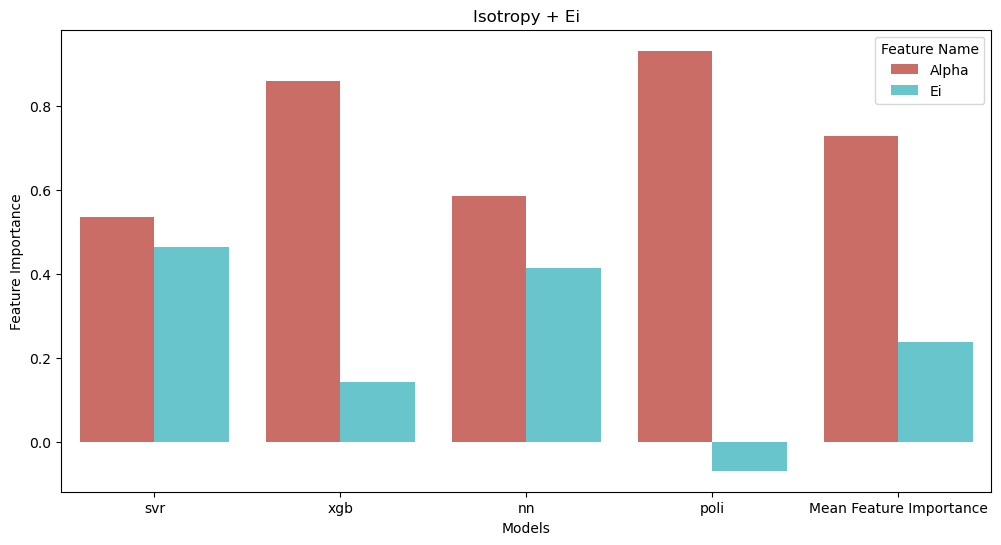

In [294]:
get_feat_graph(feat_import0_iso, title='Isotropy + Ei')

In [295]:
features = ['Alpha', 'pi_bond']
scaler=att_scaler(scaler, features)
feat_import1_iso = feat_importance(estim_list01_iso, ['svr','xgb','nn','poli'], ['Alpha','Pi Bond'], x1_iso, y.ravel(), 
                5, n_repeats = 100,n_rounds=30)

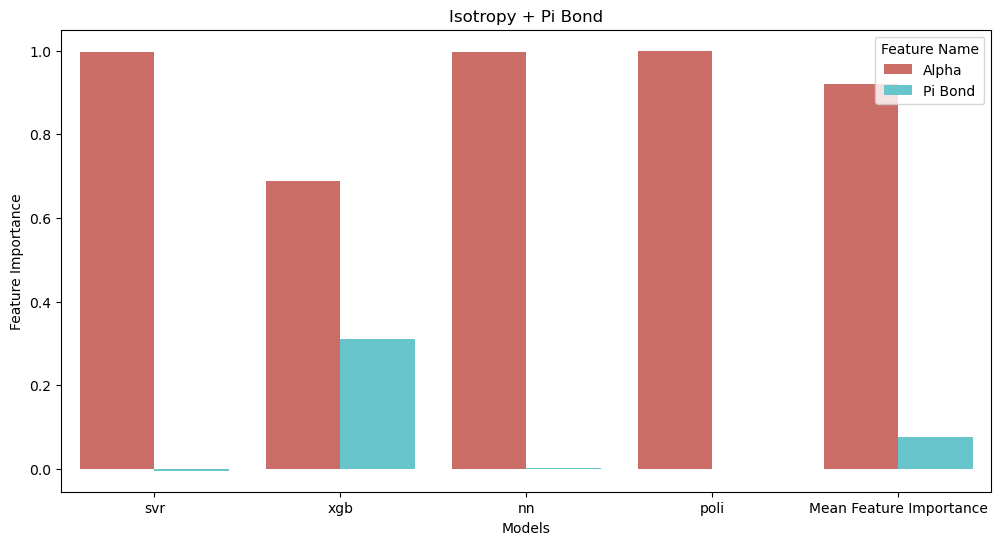

In [296]:
get_feat_graph(feat_import1_iso, title='Isotropy + Pi Bond')

## Iso vs Aniso Errors

In [298]:
cv_scores1_iso = [0.3348696326113936, 0.5002271509503483, 0.32897172728360324, 0.5611404898967144] #Alpha + Pi Bond Isotropy
cv_scores1 = [0.6764931923356459, 0.5750660857560128, 0.8009079819090521, 0.633181220994915] #Alpha + Pi Anisotropy
mean_alpha_pi = [np.mean(cv_scores1_iso), np.mean(cv_scores1)]
cv_scores1_iso.append(mean_alpha_pi[0])
cv_scores1.append(mean_alpha_pi[1])

cv_scores0_iso = [1.113014012193349, 0.7916823642096553, 0.9083588629760209, 0.8970933760288089] #Alpha + Ei Isotropy
cv_scores0 = [1.0152723399614774, 1.069177294606293, 1.088765926401479, 0.8608315444325934] #Alpha + Ei Anisotropy
mean_alpha_Ei = [np.mean(cv_scores0_iso), np.mean(cv_scores0)]
cv_scores0_iso.append(mean_alpha_Ei[0])
cv_scores0.append(mean_alpha_Ei[1])

all_feat_isotropy = [0.8577438290570095, 0.9634033427914103, 0.9048556249955915, 0.8330685869714245] #All feature w/isotropy
all_feat_anisotropy = [0.815207450017606, 0.8092087790321199, 1.1388293602722248, 0.6554296437229616] #All feature w/anisotropy
mean_alpha_all = [np.mean(all_feat_isotropy), np.mean(all_feat_anisotropy)]
all_feat_isotropy.append(mean_alpha_all[0])
all_feat_anisotropy.append(mean_alpha_all[1])


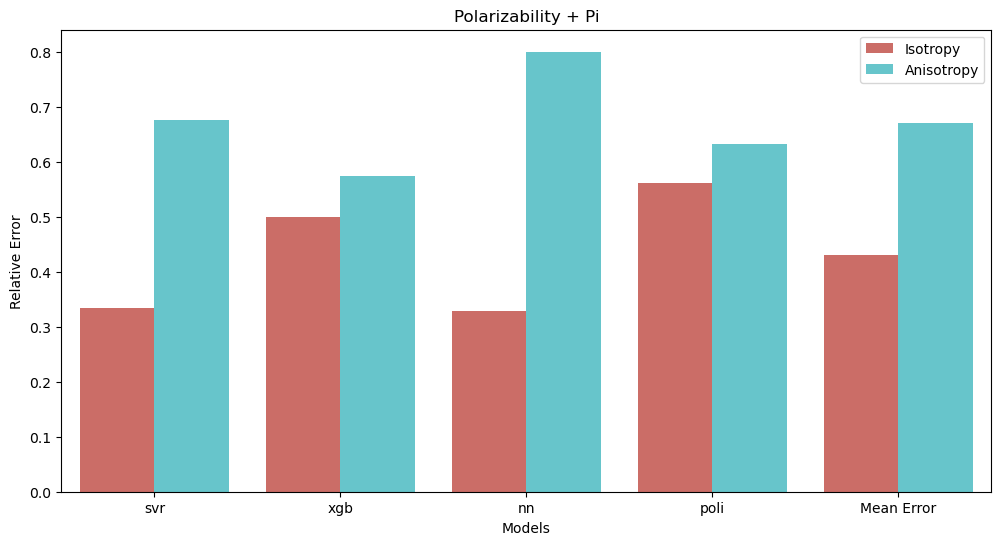

In [307]:
#Comparando Alpha + Pi
plt.figure(figsize=(12,6))
create_fast_graph(cv_scores1_iso + cv_scores1, aux_model=['svr','xgb','nn','poli','Mean Error'], hue=['Isotropy','Anisotropy'],title='Polarizability + Pi')

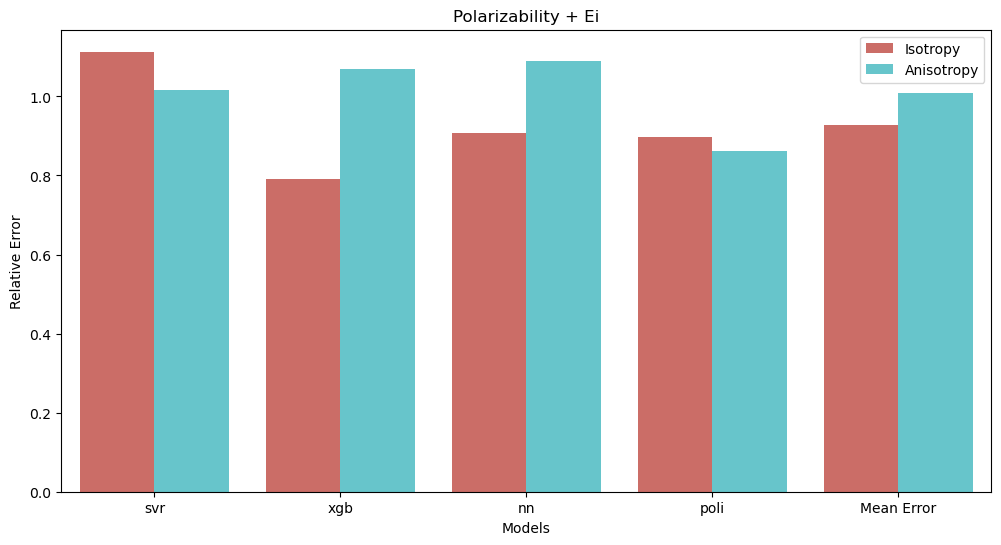

In [308]:
#Comparando Alpha + Ei
plt.figure(figsize=(12,6))
create_fast_graph(cv_scores0_iso + cv_scores0, aux_model=['svr','xgb','nn','poli','Mean Error'], hue=['Isotropy','Anisotropy'],title='Polarizability + Ei')

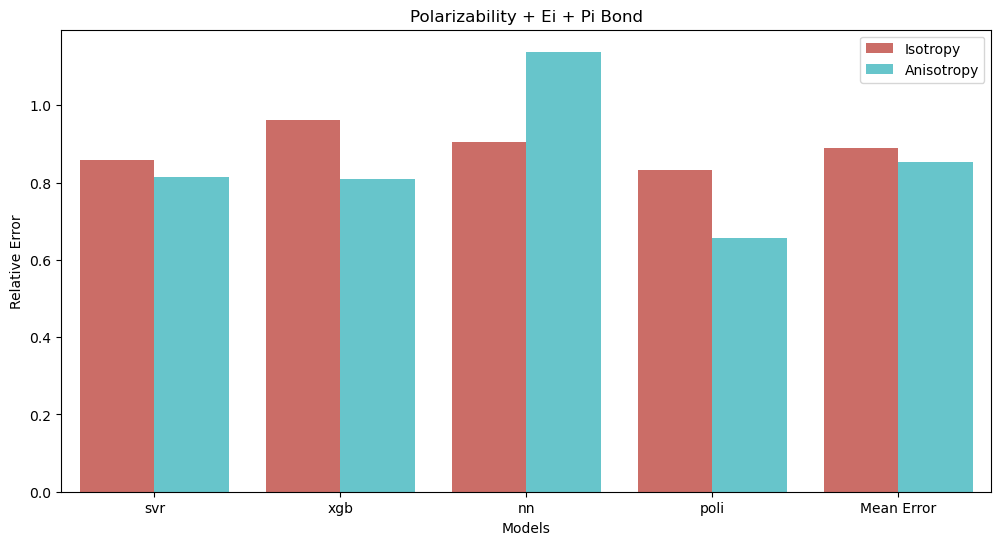

In [309]:
#Comparando all features
plt.figure(figsize=(12,6))
create_fast_graph(all_feat_isotropy + all_feat_anisotropy, aux_model=['svr','xgb','nn','poli','Mean Error'], hue=['Isotropy','Anisotropy'],title='Polarizability + Ei + Pi Bond')